In [21]:
%matplotlib inline
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
with open('raw.chartblock.json') as f:
    json_str = f.read()

In [22]:
data = pd.read_json(json_str)

In [23]:
data.ticks[0][0:5]

[[1613480802018319, 0.056936999999999995],
 [1613480802106023, 0.056935],
 [1613480802191776, 0.056935],
 [1613480802277234, 0.056935],
 [1613480802367687, 0.056935]]

In [24]:
data

,id,name,ticks,timeSpan
0,e60e8371-1037-56d1-8859-5b353ff9cb2e,bid,"[[1613480802018319, 0.056936999999999995], [16...",3600000000
1,9a13bcd4-695c-59a4-8713-e642721ef97d,ask,"[[1613480802018319, 0.056939], [16134808021060...",3600000000


Мы будем пользоваться целыми числами для избежания ошибок округления. Для этого все цены увеличим в $10^6$ раз.

In [25]:
for i in data.ticks[0]:
    i[1] *= 10**6
    i[1] = round(i[1])

In [26]:
for i in data.ticks[1]:
    i[1] *= 10**6
    i[1] = round(i[1])

In [27]:
bid = np.array(data.ticks[0])
ask = np.array(data.ticks[1])

In [28]:
bid = bid[:, 1]
ask = ask[:, 1]

In [29]:
bid[0:5]

array([56937, 56935, 56935, 56935, 56935])

In [30]:
ask[0:5]

array([56939, 56939, 56939, 56939, 56939])

Посмотрим на спред

In [31]:
spread = ask - bid

In [32]:
print(spread.mean())
print(np.median(spread))

10.99479648762915
8.0


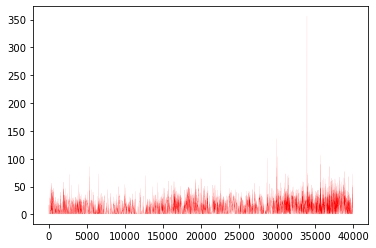

In [33]:
plt.plot(spread, color='red', linewidth=0.06)

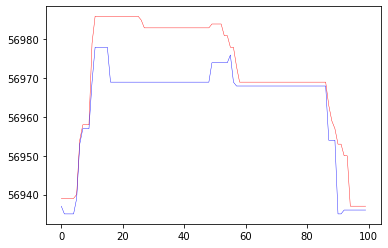

In [72]:
plt.plot(ask[0:100], color='red', linewidth=0.4)
plt.plot(bid[0:100], color='blue', linewidth=0.4)

Теперь напишем алгоритм для торговли.

In [149]:
def algo(money, ask, bid):
    """
    money - start money
    bid - array of bid price * 10^6
    ask - array of ask price * 10^6
    """
    num_of_stocks = 0
    num_of_purchased = 0
    prev_ask_price = 0 # ask price at last purchase
    for i in range(len(bid) - 1):
        if ask[i] < bid[i + 1] and ask[i] <= money:
            prev_ask_price = ask[i]
            num_of_stocks += money // ask[i]
            num_of_purchased += money // ask[i]
            money = money % ask[i] # buy stocks as much as I can
        elif bid[i] > bid[i + 1] and bid[i] > prev_ask_price and num_of_stocks != 0:
            money += bid[i] * num_of_stocks
            num_of_stocks = 0 # sell stocks as much as I can
    i = -1
    money += bid[i] * num_of_stocks
    num_of_stocks = 0 # sell stocks as much as I can
    return money, num_of_stocks, num_of_purchased

In [263]:
import math

def is_low_ex(mas, ind):
    return mas[ind-1] >= mas[ind] <= mas[ind+1]

def is_high_ex(mas, ind):
    return mas[ind-1] <= mas[ind] >= mas[ind+1]

def buy(money, num, buy_price, sell_price):
    
    if num:
        return money, num, math.inf, sell_price
    
    num = money // buy_price
    money %= buy_price
    
    return money, num, math.inf, sell_price

def sell(money, num, sell_price, buy_price):
    if sell_price <= buy_price:
        return money, num, 0, buy_price
    
    money += num * sell_price
    num = 0
    return money, num, 0, buy_price
    

In [264]:
def algo_1(money, ask, bid):
    price = 0
    inf = 10e12
    num_of_stocks = 0
    num_of_purchased = 0
    prev_ask_price = 0 # ask price at last purchase
    min_bid = 56939 # min extremum in bid
    max_ask = 0 # max extremum in ask

    for i in range(1, len(bid) - 1):
        
        low = is_low_ex(bid, i)
        high = is_high_ex(ask, i)
        if low and high:
            print(i, min_bid, max_ask, num_of_stocks, money, bid[i], ask[i])
            if bid[i] <= min_bid:
                
                min_bid = min(min_bid, bid[i])
                money, num_of_stocks, max_ask, min_bid = sell(money, num_of_stocks, max_ask, min_bid)
                
            elif ask[i] > min_bid:
                
                max_ask = max(max_ask, ask[i])
                money, num_of_stocks, min_bid, max_ask = buy(money, num_of_stocks, min_bid, max_ask)
            print('lh', min_bid, max_ask, num_of_stocks, money, bid[i], ask[i])
            
        elif low:
            print(i, min_bid, max_ask, num_of_stocks, money, bid[i], ask[i])
            
            min_bid = min(min_bid, bid[i])
            money, num_of_stocks, max_ask, min_bid = sell(money, num_of_stocks, max_ask, min_bid)
            print('l', min_bid, max_ask, num_of_stocks, money, bid[i], ask[i])
            
        elif high:
            print(i, min_bid, max_ask, num_of_stocks, money, bid[i], ask[i])
            
            max_ask = max(max_ask, ask[i])
            money, num_of_stocks, min_bid, max_ask = buy(money, num_of_stocks, min_bid, max_ask)
            print('h', min_bid, max_ask, num_of_stocks, money, bid[i], ask[i])
            
        
        '''print(i, min_bid, max_ask, num_of_stocks, money, bid[i], ask[i])
        if bid[i - 1] >= bid[i] <= bid[i + 1]:
            min_bid = min(min_bid, bid[i])
            
            if max_ask > price:
                money += num_of_stocks * max_ask
                #print(money)
                num_of_stocks = 0
                
            max_ask = 0
        print(i, min_bid, max_ask, num_of_stocks, money, bid[i], ask[i])
        
        if ask[i - 1] <= ask[i] >= ask[i + 1]:
            max_ask = max(max_ask, ask[i])
            
            if min_bid < inf:
                num_of_stocks = money // min_bid
                money = money % min_bid
                num_of_purchased += num_of_stocks
                price = min_bid
            
            min_bid = inf
        print(i, min_bid, max_ask, num_of_stocks, money, bid[i], ask[i])'''

    money += num_of_stocks * ask[-1]
    num_of_stocks = 0
    return money, num_of_stocks, num_of_purchased

Алгоритм работает так:
1) Если мы можем купить сейчай, а продать на следующей итерации с профитом, то мы покупаем акций на всю сумму. (но не обязательно мы их продадим на след. итерации)

2) Если мы можем продать акции с выгодой, при этом мы находимся в локальном максимуме bid'а, то мы продаем.

3) На последней итерации продаем оставшиеся акции.

In [265]:
x, y, z = algo(10**6, bid, ask)

In [266]:
x1, y, z = algo_1(10**6, bid, ask)

1 56939 0 0 1000000 56939 56935
l 56939 0 0 1000000 56939 56935
2 56939 0 0 1000000 56939 56935
lh 56939 0 0 1000000 56939 56935
3 56939 0 0 1000000 56939 56935
lh 56939 0 0 1000000 56939 56935
4 56939 0 0 1000000 56939 56935
l 56939 0 0 1000000 56939 56935
7 56939 0 0 1000000 56958 56957
h inf 56957 17 32037 56958 56957
8 inf 56957 17 32037 56958 56957
lh 56958 0 17 32037 56958 56957
9 56958 0 17 32037 56958 56957
l 56958 0 17 32037 56958 56957
11 56958 0 17 32037 56986 56978
h inf 56978 17 32037 56986 56978
12 inf 56978 17 32037 56986 56978
lh 56986 0 17 32037 56986 56978
13 56986 0 17 32037 56986 56978
lh 56986 0 17 32037 56986 56978
14 56986 0 17 32037 56986 56978
lh 56986 0 17 32037 56986 56978
15 56986 0 17 32037 56986 56978
lh 56986 0 17 32037 56986 56978
16 56986 0 17 32037 56986 56969
l 56986 0 17 32037 56986 56969
17 56986 0 17 32037 56986 56969
lh 56986 0 17 32037 56986 56969
18 56986 0 17 32037 56986 56969
lh 56986 0 17 32037 56986 56969
19 56986 0 17 32037 56986 56969
lh 5

h inf 56892 17 33125 56900 56892
225 inf 56892 17 33125 56900 56892
lh 56900 0 17 33125 56900 56892
226 56900 0 17 33125 56900 56892
lh 56900 0 17 33125 56900 56892
227 56900 0 17 33125 56900 56892
lh 56900 0 17 33125 56900 56892
228 56900 0 17 33125 56900 56892
h inf 56892 17 33125 56900 56892
229 inf 56892 17 33125 56899 56884
l 56899 0 17 33125 56899 56884
230 56899 0 17 33125 56900 56884
h inf 56884 17 33125 56900 56884
231 inf 56884 17 33125 56900 56884
lh 56900 0 17 33125 56900 56884
232 56900 0 17 33125 56900 56884
lh 56900 0 17 33125 56900 56884
233 56900 0 17 33125 56900 56884
l 56900 0 17 33125 56900 56884
234 56900 0 17 33125 56900 56888
l 56900 0 17 33125 56900 56888
235 56900 0 17 33125 56900 56889
lh 56900 0 17 33125 56900 56889
236 56900 0 17 33125 56900 56889
h inf 56889 17 33125 56900 56889
237 inf 56889 17 33125 56899 56888
l 56899 0 17 33125 56899 56888
238 56899 0 17 33125 56899 56888
lh 56899 0 17 33125 56899 56888
239 56899 0 17 33125 56899 56888
lh 56899 0 17 331

424 inf 56682 17 38871 56681 56655
l 56681 0 0 1002465 56681 56655
426 56681 0 0 1002465 56699 56676
h inf 56676 17 38888 56699 56676
427 inf 56676 17 38888 56699 56676
h inf 56676 17 38888 56699 56676
428 inf 56676 17 38888 56698 56676
h inf 56676 17 38888 56698 56676
429 inf 56676 17 38888 56687 56676
h inf 56676 17 38888 56687 56676
430 inf 56676 17 38888 56685 56676
l 56685 0 17 38888 56685 56676
432 56685 0 17 38888 56695 56680
h inf 56680 17 38888 56695 56680
433 inf 56680 17 38888 56695 56680
h inf 56680 17 38888 56695 56680
434 inf 56680 17 38888 56681 56680
lh 56681 0 17 38888 56681 56680
435 56681 0 17 38888 56681 56680
lh 56681 0 17 38888 56681 56680
436 56681 0 17 38888 56681 56680
h inf 56680 17 38888 56681 56680
437 inf 56680 17 38888 56677 56660
l 56677 0 0 1002448 56677 56660
440 56677 0 0 1002448 56699 56683
lh inf 56683 17 38939 56699 56683
441 inf 56683 17 38939 56707 56683
h inf 56683 17 38939 56707 56683
442 inf 56683 17 38939 56696 56683
lh 56696 0 17 38939 56696 

736 56958 0 17 41931 56973 56968
h inf 56968 17 41931 56973 56968
737 inf 56968 17 41931 56970 56968
h inf 56968 17 41931 56970 56968
741 inf 56968 17 41931 56950 56928
h inf 56968 17 41931 56950 56928
744 inf 56968 17 41931 56936 56935
lh 56936 0 0 1010387 56936 56935
745 56936 0 0 1010387 56936 56935
lh 56936 0 0 1010387 56936 56935
746 56936 0 0 1010387 56936 56935
lh 56936 0 0 1010387 56936 56935
747 56936 0 0 1010387 56936 56935
lh 56936 0 0 1010387 56936 56935
748 56936 0 0 1010387 56936 56935
lh 56936 0 0 1010387 56936 56935
749 56936 0 0 1010387 56936 56935
lh 56936 0 0 1010387 56936 56935
750 56936 0 0 1010387 56936 56935
lh 56936 0 0 1010387 56936 56935
751 56936 0 0 1010387 56936 56935
lh 56936 0 0 1010387 56936 56935
752 56936 0 0 1010387 56936 56935
h inf 56935 17 42475 56936 56935
753 inf 56935 17 42475 56934 56930
l 56934 0 0 1010370 56934 56930
754 56934 0 0 1010370 56934 56930
h inf 56930 17 42492 56934 56930
755 inf 56930 17 42492 56930 56929
l 56930 0 17 42492 56930 

912 56994 0 17 43104 56995 56993
l 56994 0 17 43104 56995 56993
913 56994 0 17 43104 56995 56994
lh 56994 0 17 43104 56995 56994
914 56994 0 17 43104 56995 56994
lh 56994 0 17 43104 56995 56994
915 56994 0 17 43104 56995 56994
lh 56994 0 17 43104 56995 56994
916 56994 0 17 43104 56995 56994
lh 56994 0 17 43104 56995 56994
917 56994 0 17 43104 56995 56994
lh 56994 0 17 43104 56995 56994
918 56994 0 17 43104 56995 56994
lh 56994 0 17 43104 56995 56994
919 56994 0 17 43104 56995 56994
lh 56994 0 17 43104 56995 56994
920 56994 0 17 43104 56995 56994
lh 56994 0 17 43104 56995 56994
921 56994 0 17 43104 56995 56994
lh 56994 0 17 43104 56995 56994
922 56994 0 17 43104 56995 56994
h inf 56994 17 43104 56995 56994
924 inf 56994 17 43104 56992 56987
l 56992 0 0 1012002 56992 56987
925 56992 0 0 1012002 56992 56989
lh 56992 0 0 1012002 56992 56989
926 56992 0 0 1012002 56992 56989
lh 56992 0 0 1012002 56992 56989
927 56992 0 0 1012002 56992 56989
lh 56992 0 0 1012002 56992 56989
928 56992 0 0 101

lh 57041 0 17 44056 57041 57040
1099 57041 0 17 44056 57041 57040
lh 57041 0 17 44056 57041 57040
1100 57041 0 17 44056 57041 57040
lh 57041 0 17 44056 57041 57040
1101 57041 0 17 44056 57041 57040
lh 57041 0 17 44056 57041 57040
1102 57041 0 17 44056 57041 57040
lh 57041 0 17 44056 57041 57040
1103 57041 0 17 44056 57041 57040
lh 57041 0 17 44056 57041 57040
1104 57041 0 17 44056 57041 57040
lh 57041 0 17 44056 57041 57040
1105 57041 0 17 44056 57041 57040
lh 57041 0 17 44056 57041 57040
1106 57041 0 17 44056 57041 57040
lh 57041 0 17 44056 57041 57040
1107 57041 0 17 44056 57041 57040
lh 57041 0 17 44056 57041 57040
1108 57041 0 17 44056 57041 57040
l 57041 0 17 44056 57041 57040
1110 57041 0 17 44056 57048 57047
lh inf 57047 17 44056 57048 57047
1111 inf 57047 17 44056 57048 57047
lh 57048 0 17 44056 57048 57047
1113 57048 0 17 44056 57072 57071
h inf 57071 17 44056 57072 57071
1114 inf 57071 17 44056 57072 57071
h inf 57071 17 44056 57072 57071
1115 inf 57071 17 44056 57067 57058
l

h inf 57077 17 45297 57092 57077
1313 inf 57077 17 45297 57090 57075
l 57090 0 17 45297 57090 57075
1314 57090 0 17 45297 57090 57076
lh 57090 0 17 45297 57090 57076
1315 57090 0 17 45297 57090 57076
l 57090 0 17 45297 57090 57076
1316 57090 0 17 45297 57090 57083
lh 57090 0 17 45297 57090 57083
1317 57090 0 17 45297 57090 57083
lh 57090 0 17 45297 57090 57083
1318 57090 0 17 45297 57090 57083
lh 57090 0 17 45297 57090 57083
1319 57090 0 17 45297 57090 57083
lh 57090 0 17 45297 57090 57083
1321 57090 0 17 45297 57088 57086
l 57088 0 17 45297 57088 57086
1323 57088 0 17 45297 57090 57088
l 57088 0 17 45297 57090 57088
1325 57088 0 17 45297 57100 57094
h inf 57094 17 45297 57100 57094
1326 inf 57094 17 45297 57098 57094
lh 57098 0 17 45297 57098 57094
1327 57098 0 17 45297 57098 57088
l 57098 0 17 45297 57098 57088
1328 57098 0 17 45297 57098 57097
lh 57098 0 17 45297 57098 57097
1329 57098 0 17 45297 57098 57088
l 57098 0 17 45297 57098 57088
1330 57098 0 17 45297 57098 57088
lh 57098 0

h inf 57082 17 45688 57069 57056
1511 inf 57082 17 45688 57067 57056
lh 57067 0 0 1016082 57067 57056
1512 57067 0 0 1016082 57067 57056
lh 57067 0 0 1016082 57067 57056
1513 57067 0 0 1016082 57067 57042
l 57067 0 0 1016082 57067 57042
1514 57067 0 0 1016082 57067 57065
lh 57067 0 0 1016082 57067 57065
1515 57067 0 0 1016082 57067 57065
h inf 57065 17 45943 57067 57065
1516 inf 57065 17 45943 57066 57065
lh 57066 0 17 45943 57066 57065
1517 57066 0 17 45943 57066 57065
lh 57066 0 17 45943 57066 57065
1518 57066 0 17 45943 57066 57065
lh 57066 0 17 45943 57066 57065
1519 57066 0 17 45943 57066 57065
h inf 57065 17 45943 57066 57065
1520 inf 57065 17 45943 57064 57042
l 57064 0 0 1016048 57064 57042
1521 57064 0 0 1016048 57064 57042
h inf 57042 17 45960 57064 57042
1522 inf 57042 17 45960 57053 57042
h inf 57042 17 45960 57053 57042
1523 inf 57042 17 45960 57052 57042
h inf 57042 17 45960 57052 57042
1524 inf 57042 17 45960 57051 57040
l 57051 0 17 45960 57051 57040
1525 57051 0 17 459

lh 57082 0 0 1016592 57082 57081
1668 57082 0 0 1016592 57082 57081
lh 57082 0 0 1016592 57082 57081
1669 57082 0 0 1016592 57082 57081
lh 57082 0 0 1016592 57082 57081
1670 57082 0 0 1016592 57082 57081
lh 57082 0 0 1016592 57082 57081
1671 57082 0 0 1016592 57082 57081
lh 57082 0 0 1016592 57082 57081
1672 57082 0 0 1016592 57082 57081
lh 57082 0 0 1016592 57082 57081
1673 57082 0 0 1016592 57082 57081
lh 57082 0 0 1016592 57082 57081
1674 57082 0 0 1016592 57082 57081
lh 57082 0 0 1016592 57082 57081
1675 57082 0 0 1016592 57082 57081
lh 57082 0 0 1016592 57082 57081
1676 57082 0 0 1016592 57082 57081
lh 57082 0 0 1016592 57082 57081
1677 57082 0 0 1016592 57082 57081
lh 57082 0 0 1016592 57082 57081
1678 57082 0 0 1016592 57082 57081
lh 57082 0 0 1016592 57082 57081
1679 57082 0 0 1016592 57082 57081
lh 57082 0 0 1016592 57082 57081
1680 57082 0 0 1016592 57082 57081
lh 57082 0 0 1016592 57082 57081
1681 57082 0 0 1016592 57082 57081
lh 57082 0 0 1016592 57082 57081
1682 57082 0 0 

1875 inf 57104 17 46351 57105 57104
lh 57105 0 17 46351 57105 57104
1876 57105 0 17 46351 57105 57104
lh 57105 0 17 46351 57105 57104
1877 57105 0 17 46351 57105 57104
lh 57105 0 17 46351 57105 57104
1880 57105 0 17 46351 57117 57116
lh inf 57116 17 46351 57117 57116
1881 inf 57116 17 46351 57117 57116
lh 57117 0 17 46351 57117 57116
1882 57117 0 17 46351 57117 57116
lh 57117 0 17 46351 57117 57116
1883 57117 0 17 46351 57117 57116
lh 57117 0 17 46351 57117 57116
1884 57117 0 17 46351 57117 57116
h inf 57116 17 46351 57117 57116
1885 inf 57116 17 46351 57113 57087
l 57113 0 0 1017323 57113 57087
1890 57113 0 0 1017323 57106 57098
l 57106 0 0 1017323 57106 57098
1891 57106 0 0 1017323 57106 57102
h inf 57102 17 46521 57106 57102
1892 inf 57102 17 46521 57103 57102
lh 57103 0 17 46521 57103 57102
1893 57103 0 17 46521 57103 57102
lh 57103 0 17 46521 57103 57102
1894 57103 0 17 46521 57103 57080
l 57103 0 17 46521 57103 57080
1895 57103 0 17 46521 57103 57085
h inf 57085 17 46521 57103 57

lh 56833 0 17 51910 56833 56832
2193 56833 0 17 51910 56833 56832
lh 56833 0 17 51910 56833 56832
2194 56833 0 17 51910 56833 56832
l 56833 0 17 51910 56833 56832
2197 56833 0 17 51910 56849 56844
l 56833 0 17 51910 56849 56844
2198 56833 0 17 51910 56849 56848
lh inf 56848 17 51910 56849 56848
2199 inf 56848 17 51910 56849 56848
lh 56849 0 17 51910 56849 56848
2200 56849 0 17 51910 56849 56848
lh 56849 0 17 51910 56849 56848
2202 56849 0 17 51910 56856 56850
lh inf 56850 17 51910 56856 56850
2203 inf 56850 17 51910 56856 56850
l 56856 0 17 51910 56856 56850
2204 56856 0 17 51910 56856 56855
lh 56856 0 17 51910 56856 56855
2205 56856 0 17 51910 56856 56855
lh 56856 0 17 51910 56856 56855
2206 56856 0 17 51910 56856 56855
l 56856 0 17 51910 56856 56855
2207 56856 0 17 51910 56858 56857
h inf 56857 17 51910 56858 56857
2208 inf 56857 17 51910 56858 56857
lh 56858 0 17 51910 56858 56857
2209 56858 0 17 51910 56858 56857
h inf 56857 17 51910 56858 56857
2210 inf 56857 17 51910 56855 56851


lh 56735 0 17 53780 56735 56734
2392 56735 0 17 53780 56735 56734
lh 56735 0 17 53780 56735 56734
2394 56735 0 17 53780 56733 56732
l 56733 0 17 53780 56733 56732
2396 56733 0 17 53780 56746 56741
h inf 56741 17 53780 56746 56741
2398 inf 56741 17 53780 56758 56732
l 56758 0 17 53780 56758 56732
2399 56758 0 17 53780 56758 56739
lh 56758 0 17 53780 56758 56739
2400 56758 0 17 53780 56758 56733
l 56758 0 17 53780 56758 56733
2401 56758 0 17 53780 56758 56736
lh 56758 0 17 53780 56758 56736
2402 56758 0 17 53780 56758 56734
l 56758 0 17 53780 56758 56734
2403 56758 0 17 53780 56758 56736
lh 56758 0 17 53780 56758 56736
2405 56758 0 17 53780 56756 56732
l 56756 0 17 53780 56756 56732
2406 56756 0 17 53780 56756 56736
l 56756 0 17 53780 56756 56736
2407 56756 0 17 53780 56756 56746
lh 56756 0 17 53780 56756 56746
2408 56756 0 17 53780 56756 56746
l 56756 0 17 53780 56756 56746
2409 56756 0 17 53780 56756 56748
lh 56756 0 17 53780 56756 56748
2410 56756 0 17 53780 56756 56748
lh 56756 0 17 

lh 56753 0 17 54409 56753 56752
2551 56753 0 17 54409 56753 56752
lh 56753 0 17 54409 56753 56752
2552 56753 0 17 54409 56753 56752
lh 56753 0 17 54409 56753 56752
2553 56753 0 17 54409 56753 56752
lh 56753 0 17 54409 56753 56752
2554 56753 0 17 54409 56753 56752
lh 56753 0 17 54409 56753 56752
2555 56753 0 17 54409 56753 56752
lh 56753 0 17 54409 56753 56752
2556 56753 0 17 54409 56753 56752
lh 56753 0 17 54409 56753 56752
2557 56753 0 17 54409 56753 56752
lh 56753 0 17 54409 56753 56752
2558 56753 0 17 54409 56753 56752
lh 56753 0 17 54409 56753 56752
2559 56753 0 17 54409 56753 56752
lh 56753 0 17 54409 56753 56752
2560 56753 0 17 54409 56753 56752
lh 56753 0 17 54409 56753 56752
2561 56753 0 17 54409 56753 56752
lh 56753 0 17 54409 56753 56752
2562 56753 0 17 54409 56753 56752
lh 56753 0 17 54409 56753 56752
2563 56753 0 17 54409 56753 56752
lh 56753 0 17 54409 56753 56752
2564 56753 0 17 54409 56753 56752
lh 56753 0 17 54409 56753 56752
2565 56753 0 17 54409 56753 56752
lh 56753 0

lh 56805 0 17 54885 56805 56804
2702 56805 0 17 54885 56805 56804
lh 56805 0 17 54885 56805 56804
2703 56805 0 17 54885 56805 56804
lh 56805 0 17 54885 56805 56804
2704 56805 0 17 54885 56805 56804
lh 56805 0 17 54885 56805 56804
2705 56805 0 17 54885 56805 56804
l 56805 0 17 54885 56805 56804
2706 56805 0 17 54885 56814 56810
h inf 56810 17 54885 56814 56810
2707 inf 56810 17 54885 56814 56810
h inf 56810 17 54885 56814 56810
2708 inf 56810 17 54885 56810 56809
l 56810 0 17 54885 56810 56809
2709 56810 0 17 54885 56810 56809
lh 56810 0 17 54885 56810 56809
2710 56810 0 17 54885 56810 56809
lh 56810 0 17 54885 56810 56809
2711 56810 0 17 54885 56810 56809
lh 56810 0 17 54885 56810 56809
2712 56810 0 17 54885 56810 56809
lh 56810 0 17 54885 56810 56809
2713 56810 0 17 54885 56810 56809
lh 56810 0 17 54885 56810 56809
2714 56810 0 17 54885 56810 56809
lh 56810 0 17 54885 56810 56809
2715 56810 0 17 54885 56810 56809
lh 56810 0 17 54885 56810 56809
2716 56810 0 17 54885 56810 56809
lh 568

lh 56796 0 17 55684 56796 56795
2889 56796 0 17 55684 56796 56795
lh 56796 0 17 55684 56796 56795
2890 56796 0 17 55684 56796 56795
lh 56796 0 17 55684 56796 56795
2891 56796 0 17 55684 56796 56795
lh 56796 0 17 55684 56796 56795
2892 56796 0 17 55684 56796 56795
lh 56796 0 17 55684 56796 56795
2893 56796 0 17 55684 56796 56795
lh 56796 0 17 55684 56796 56795
2894 56796 0 17 55684 56796 56795
lh 56796 0 17 55684 56796 56795
2895 56796 0 17 55684 56796 56795
lh 56796 0 17 55684 56796 56795
2896 56796 0 17 55684 56796 56795
lh 56796 0 17 55684 56796 56795
2897 56796 0 17 55684 56796 56795
lh 56796 0 17 55684 56796 56795
2898 56796 0 17 55684 56796 56795
lh 56796 0 17 55684 56796 56795
2899 56796 0 17 55684 56801 56795
h inf 56795 17 55684 56801 56795
2900 inf 56795 17 55684 56796 56795
l 56796 0 17 55684 56796 56795
2901 56796 0 17 55684 56800 56796
h inf 56796 17 55684 56800 56796
2902 inf 56796 17 55684 56801 56796
h inf 56796 17 55684 56801 56796
2903 inf 56796 17 55684 56801 56796
lh

3026 56860 0 17 56177 56860 56859
lh 56860 0 17 56177 56860 56859
3027 56860 0 17 56177 56860 56859
lh 56860 0 17 56177 56860 56859
3028 56860 0 17 56177 56860 56859
lh 56860 0 17 56177 56860 56859
3029 56860 0 17 56177 56860 56859
lh 56860 0 17 56177 56860 56859
3030 56860 0 17 56177 56860 56859
lh 56860 0 17 56177 56860 56859
3031 56860 0 17 56177 56860 56859
lh 56860 0 17 56177 56860 56859
3032 56860 0 17 56177 56860 56859
lh 56860 0 17 56177 56860 56859
3033 56860 0 17 56177 56880 56859
h inf 56859 17 56177 56880 56859
3034 inf 56859 17 56177 56880 56859
h inf 56859 17 56177 56880 56859
3035 inf 56859 17 56177 56877 56859
l 56877 0 17 56177 56877 56859
3036 56877 0 17 56177 56877 56876
lh 56877 0 17 56177 56877 56876
3037 56877 0 17 56177 56877 56876
lh 56877 0 17 56177 56877 56876
3038 56877 0 17 56177 56877 56876
lh 56877 0 17 56177 56877 56876
3039 56877 0 17 56177 56877 56876
lh 56877 0 17 56177 56877 56876
3040 56877 0 17 56177 56877 56876
lh 56877 0 17 56177 56877 56876
3041 

h inf 56875 18 133 56878 56875
3297 inf 56875 18 133 56877 56875
lh 56877 0 18 133 56877 56875
3298 56877 0 18 133 56877 56875
lh 56877 0 18 133 56877 56875
3299 56877 0 18 133 56877 56875
h inf 56875 18 133 56877 56875
3301 inf 56875 18 133 56872 56864
lh 56872 0 0 1023883 56872 56864
3303 56872 0 0 1023883 56868 56867
lh 56868 0 0 1023883 56868 56867
3304 56868 0 0 1023883 56868 56867
lh 56868 0 0 1023883 56868 56867
3305 56868 0 0 1023883 56868 56867
lh 56868 0 0 1023883 56868 56867
3306 56868 0 0 1023883 56868 56867
lh 56868 0 0 1023883 56868 56867
3309 56868 0 0 1023883 56857 56852
h inf 56852 18 259 56857 56852
3310 inf 56852 18 259 56855 56852
h inf 56852 18 259 56855 56852
3312 inf 56852 18 259 56851 56850
lh 56851 0 0 1023595 56851 56850
3313 56851 0 0 1023595 56851 56850
lh 56851 0 0 1023595 56851 56850
3314 56851 0 0 1023595 56851 56850
lh 56851 0 0 1023595 56851 56850
3315 56851 0 0 1023595 56851 56850
lh 56851 0 0 1023595 56851 56850
3316 56851 0 0 1023595 56851 56850
lh 5

lh 56872 0 18 313 56872 56871
3459 56872 0 18 313 56872 56871
lh 56872 0 18 313 56872 56871
3460 56872 0 18 313 56872 56871
lh 56872 0 18 313 56872 56871
3461 56872 0 18 313 56872 56871
lh 56872 0 18 313 56872 56871
3462 56872 0 18 313 56872 56871
lh 56872 0 18 313 56872 56871
3463 56872 0 18 313 56872 56871
lh 56872 0 18 313 56872 56871
3464 56872 0 18 313 56872 56871
h inf 56871 18 313 56872 56871
3466 inf 56871 18 313 56864 56849
l 56864 0 0 1023991 56864 56849
3467 56864 0 0 1023991 56864 56849
lh 56864 0 0 1023991 56864 56849
3468 56864 0 0 1023991 56864 56849
h inf 56849 18 439 56864 56849
3469 inf 56849 18 439 56863 56849
h inf 56849 18 439 56863 56849
3470 inf 56849 18 439 56862 56849
h inf 56849 18 439 56862 56849
3471 inf 56849 18 439 56860 56847
l 56860 0 18 439 56860 56847
3472 56860 0 18 439 56860 56847
lh 56860 0 18 439 56860 56847
3473 56860 0 18 439 56860 56847
lh 56860 0 18 439 56860 56847
3474 56860 0 18 439 56860 56847
lh 56860 0 18 439 56860 56847
3475 56860 0 18 43

h inf 56863 18 1645 56864 56863
3632 inf 56863 18 1645 56864 56863
lh 56864 0 18 1645 56864 56863
3633 56864 0 18 1645 56864 56863
lh 56864 0 18 1645 56864 56863
3634 56864 0 18 1645 56864 56863
lh 56864 0 18 1645 56864 56863
3636 56864 0 18 1645 56872 56865
lh inf 56865 18 1645 56872 56865
3637 inf 56865 18 1645 56872 56865
lh 56872 0 18 1645 56872 56865
3638 56872 0 18 1645 56876 56865
h inf 56865 18 1645 56876 56865
3639 inf 56865 18 1645 56876 56865
l 56876 0 18 1645 56876 56865
3640 56876 0 18 1645 56884 56868
h inf 56868 18 1645 56884 56868
3641 inf 56868 18 1645 56878 56868
lh 56878 0 18 1645 56878 56868
3642 56878 0 18 1645 56878 56868
lh 56878 0 18 1645 56878 56868
3643 56878 0 18 1645 56878 56868
lh 56878 0 18 1645 56878 56868
3644 56878 0 18 1645 56878 56868
lh 56878 0 18 1645 56878 56868
3645 56878 0 18 1645 56878 56868
l 56878 0 18 1645 56878 56868
3646 56878 0 18 1645 56878 56869
l 56878 0 18 1645 56878 56869
3647 56878 0 18 1645 56878 56874
l 56878 0 18 1645 56878 56874


3800 57001 0 18 1771 57001 56978
lh 57001 0 18 1771 57001 56978
3801 57001 0 18 1771 57001 56978
lh 57001 0 18 1771 57001 56978
3802 57001 0 18 1771 57001 56978
lh 57001 0 18 1771 57001 56978
3803 57001 0 18 1771 57001 56978
l 57001 0 18 1771 57001 56978
3805 57001 0 18 1771 57004 56984
l 57001 0 18 1771 57004 56984
3806 57001 0 18 1771 57004 56995
lh 57001 0 18 1771 57004 56995
3807 57001 0 18 1771 57004 56993
l 57001 0 18 1771 57004 56993
3808 57001 0 18 1771 57004 56993
h inf 56993 18 1771 57004 56993
3809 inf 56993 18 1771 57003 56993
lh 57003 0 18 1771 57003 56993
3811 57003 0 18 1771 57027 56995
lh 57003 0 18 1771 57027 56995
3812 57003 0 18 1771 57027 56995
l 57003 0 18 1771 57027 56995
3813 57003 0 18 1771 57027 57011
h inf 57011 18 1771 57027 57011
3814 inf 57011 18 1771 57026 57011
lh 57026 0 18 1771 57026 57011
3815 57026 0 18 1771 57028 57011
h inf 57011 18 1771 57028 57011
3816 inf 57011 18 1771 57028 57011
lh 57028 0 18 1771 57028 57011
3817 57028 0 18 1771 57028 57011
lh

3968 57064 0 18 3355 57064 57059
h inf 57059 18 3355 57064 57059
3969 inf 57059 18 3355 57062 57059
h inf 57059 18 3355 57062 57059
3970 inf 57059 18 3355 57060 57057
l 57060 0 18 3355 57060 57057
3971 57060 0 18 3355 57060 57057
l 57060 0 18 3355 57060 57057
3972 57060 0 18 3355 57060 57059
lh 57060 0 18 3355 57060 57059
3973 57060 0 18 3355 57060 57059
l 57060 0 18 3355 57060 57059
3974 57060 0 18 3355 57061 57060
h inf 57060 18 3355 57061 57060
3975 inf 57060 18 3355 57061 57060
lh 57061 0 18 3355 57061 57060
3976 57061 0 18 3355 57061 57060
lh 57061 0 18 3355 57061 57060
3977 57061 0 18 3355 57061 57060
lh 57061 0 18 3355 57061 57060
3978 57061 0 18 3355 57074 57060
h inf 57060 18 3355 57074 57060
3981 inf 57060 18 3355 57059 57047
l 57059 0 0 1030435 57059 57047
3982 57059 0 0 1030435 57059 57058
lh 57059 0 0 1030435 57059 57058
3983 57059 0 0 1030435 57059 57058
lh 57059 0 0 1030435 57059 57058
3984 57059 0 0 1030435 57059 57058
lh 57059 0 0 1030435 57059 57058
3985 57059 0 0 103

lh 57010 0 18 4471 57010 57009
4151 57010 0 18 4471 57010 57009
lh 57010 0 18 4471 57010 57009
4152 57010 0 18 4471 57010 57009
lh 57010 0 18 4471 57010 57009
4153 57010 0 18 4471 57010 57009
h inf 57009 18 4471 57010 57009
4154 inf 57009 18 4471 56996 56989
l 56996 0 0 1030633 56996 56989
4156 56996 0 0 1030633 56998 56988
lh 56996 0 0 1030633 56998 56988
4157 56996 0 0 1030633 56998 56988
lh 56996 0 0 1030633 56998 56988
4158 56996 0 0 1030633 56998 56988
lh 56996 0 0 1030633 56998 56988
4159 56996 0 0 1030633 56998 56988
l 56996 0 0 1030633 56998 56988
4160 56996 0 0 1030633 56998 56997
h inf 56997 18 4705 56998 56997
4162 inf 56997 18 4705 56993 56988
l 56993 0 0 1030651 56993 56988
4163 56993 0 0 1030651 56994 56993
h inf 56993 18 4777 56994 56993
4164 inf 56993 18 4777 56994 56988
l 56994 0 18 4777 56994 56988
4165 56994 0 18 4777 56994 56990
l 56994 0 18 4777 56994 56990
4166 56994 0 18 4777 56994 56993
lh 56994 0 18 4777 56994 56993
4167 56994 0 18 4777 56994 56989
l 56994 0 18

l 57045 0 0 1032109 57045 57043
4316 57045 0 0 1032109 57045 57044
lh 57045 0 0 1032109 57045 57044
4317 57045 0 0 1032109 57045 57044
lh 57045 0 0 1032109 57045 57044
4318 57045 0 0 1032109 57045 57044
lh 57045 0 0 1032109 57045 57044
4319 57045 0 0 1032109 57045 57044
lh 57045 0 0 1032109 57045 57044
4320 57045 0 0 1032109 57045 57044
lh 57045 0 0 1032109 57045 57044
4322 57045 0 0 1032109 57046 57041
h inf 57041 18 5299 57046 57041
4323 inf 57041 18 5299 57045 57041
h inf 57041 18 5299 57045 57041
4324 inf 57041 18 5299 57040 57038
l 57040 0 0 1032037 57040 57038
4325 57040 0 0 1032037 57040 57025
l 57040 0 0 1032037 57040 57025
4326 57040 0 0 1032037 57040 57028
l 57040 0 0 1032037 57040 57028
4328 57040 0 0 1032037 57046 57039
l 57040 0 0 1032037 57046 57039
4329 57040 0 0 1032037 57046 57041
lh inf 57041 18 5317 57046 57041
4330 inf 57041 18 5317 57046 57041
lh 57046 0 18 5317 57046 57041
4331 57046 0 18 5317 57046 57041
lh 57046 0 18 5317 57046 57041
4332 57046 0 18 5317 57056 5

lh 57051 0 18 5407 57052 57051
4485 57051 0 18 5407 57052 57051
lh 57051 0 18 5407 57052 57051
4486 57051 0 18 5407 57052 57051
lh 57051 0 18 5407 57052 57051
4487 57051 0 18 5407 57052 57051
lh 57051 0 18 5407 57052 57051
4488 57051 0 18 5407 57052 57051
lh 57051 0 18 5407 57052 57051
4489 57051 0 18 5407 57052 57051
lh 57051 0 18 5407 57052 57051
4490 57051 0 18 5407 57052 57051
lh 57051 0 18 5407 57052 57051
4491 57051 0 18 5407 57052 57051
h inf 57051 18 5407 57052 57051
4492 inf 57051 18 5407 57048 57039
l 57048 0 0 1032325 57048 57039
4493 57048 0 0 1032325 57048 57039
lh 57048 0 0 1032325 57048 57039
4494 57048 0 0 1032325 57048 57039
lh 57048 0 0 1032325 57048 57039
4495 57048 0 0 1032325 57048 57039
lh 57048 0 0 1032325 57048 57039
4496 57048 0 0 1032325 57048 57039
h inf 57039 18 5461 57048 57039
4497 inf 57039 18 5461 57042 57039
lh 57042 0 18 5461 57042 57039
4498 57042 0 18 5461 57042 57039
l 57042 0 18 5461 57042 57039
4499 57042 0 18 5461 57042 57041
lh 57042 0 18 5461 5

lh 57086 0 0 1033585 57086 57085
4647 57086 0 0 1033585 57086 57085
lh 57086 0 0 1033585 57086 57085
4648 57086 0 0 1033585 57086 57085
lh 57086 0 0 1033585 57086 57085
4649 57086 0 0 1033585 57086 57085
lh 57086 0 0 1033585 57086 57085
4650 57086 0 0 1033585 57086 57085
l 57086 0 0 1033585 57086 57085
4652 57086 0 0 1033585 57099 57093
l 57086 0 0 1033585 57099 57093
4653 57086 0 0 1033585 57099 57095
lh inf 57095 18 6037 57099 57095
4654 inf 57095 18 6037 57099 57095
l 57099 0 18 6037 57099 57095
4655 57099 0 18 6037 57099 57096
h inf 57096 18 6037 57099 57096
4656 inf 57096 18 6037 57097 57096
lh 57097 0 18 6037 57097 57096
4657 57097 0 18 6037 57097 57096
lh 57097 0 18 6037 57097 57096
4658 57097 0 18 6037 57097 57096
lh 57097 0 18 6037 57097 57096
4659 57097 0 18 6037 57097 57096
lh 57097 0 18 6037 57097 57096
4660 57097 0 18 6037 57097 57096
lh 57097 0 18 6037 57097 57096
4661 57097 0 18 6037 57097 57096
lh 57097 0 18 6037 57097 57096
4662 57097 0 18 6037 57097 57096
lh 57097 0 1

h inf 57049 18 7693 57050 57049
4819 inf 57049 18 7693 56997 56970
l 56997 0 0 1034575 56997 56970
4820 56997 0 0 1034575 56997 56975
l 56997 0 0 1034575 56997 56975
4821 56997 0 0 1034575 56997 56982
l 56997 0 0 1034575 56997 56982
4822 56997 0 0 1034575 57009 56986
h inf 56986 18 8629 57009 56986
4823 inf 56986 18 8629 57009 56986
l 57009 0 18 8629 57009 56986
4824 57009 0 18 8629 57009 56988
lh 57009 0 18 8629 57009 56988
4825 57009 0 18 8629 57009 56988
lh 57009 0 18 8629 57009 56988
4826 57009 0 18 8629 57009 56988
lh 57009 0 18 8629 57009 56988
4827 57009 0 18 8629 57009 56988
lh 57009 0 18 8629 57009 56988
4828 57009 0 18 8629 57009 56988
lh 57009 0 18 8629 57009 56988
4829 57009 0 18 8629 57009 56988
lh 57009 0 18 8629 57009 56988
4830 57009 0 18 8629 57009 56988
l 57009 0 18 8629 57009 56988
4831 57009 0 18 8629 57009 56990
lh 57009 0 18 8629 57009 56990
4832 57009 0 18 8629 57009 56990
l 57009 0 18 8629 57009 56990
4833 57009 0 18 8629 57009 56992
lh 57009 0 18 8629 57009 569

lh 56981 0 18 8701 56981 56980
4970 56981 0 18 8701 56981 56980
lh 56981 0 18 8701 56981 56980
4971 56981 0 18 8701 56981 56980
lh 56981 0 18 8701 56981 56980
4972 56981 0 18 8701 56981 56980
lh 56981 0 18 8701 56981 56980
4973 56981 0 18 8701 56981 56980
lh 56981 0 18 8701 56981 56980
4974 56981 0 18 8701 56981 56980
lh 56981 0 18 8701 56981 56980
4975 56981 0 18 8701 56981 56980
lh 56981 0 18 8701 56981 56980
4976 56981 0 18 8701 56981 56980
lh 56981 0 18 8701 56981 56980
4977 56981 0 18 8701 56981 56980
lh 56981 0 18 8701 56981 56980
4978 56981 0 18 8701 56981 56980
lh 56981 0 18 8701 56981 56980
4979 56981 0 18 8701 56981 56980
lh 56981 0 18 8701 56981 56980
4980 56981 0 18 8701 56981 56980
lh 56981 0 18 8701 56981 56980
4981 56981 0 18 8701 56981 56980
lh 56981 0 18 8701 56981 56980
4982 56981 0 18 8701 56981 56980
lh 56981 0 18 8701 56981 56980
4983 56981 0 18 8701 56981 56980
lh 56981 0 18 8701 56981 56980
4984 56981 0 18 8701 56981 56980
lh 56981 0 18 8701 56981 56980
4985 5698

lh 56973 0 18 8719 56973 56972
5108 56973 0 18 8719 56973 56972
lh 56973 0 18 8719 56973 56972
5109 56973 0 18 8719 56973 56972
lh 56973 0 18 8719 56973 56972
5110 56973 0 18 8719 56973 56972
lh 56973 0 18 8719 56973 56972
5111 56973 0 18 8719 56973 56972
lh 56973 0 18 8719 56973 56972
5112 56973 0 18 8719 56973 56972
h inf 56972 18 8719 56973 56972
5114 inf 56972 18 8719 56952 56951
lh 56952 0 0 1034215 56952 56951
5115 56952 0 0 1034215 56952 56951
lh 56952 0 0 1034215 56952 56951
5116 56952 0 0 1034215 56952 56951
lh 56952 0 0 1034215 56952 56951
5117 56952 0 0 1034215 56952 56951
lh 56952 0 0 1034215 56952 56951
5118 56952 0 0 1034215 56952 56951
lh 56952 0 0 1034215 56952 56951
5119 56952 0 0 1034215 56968 56951
h inf 56951 18 9079 56968 56951
5120 inf 56951 18 9079 56965 56951
lh 56965 0 18 9079 56965 56951
5121 56965 0 18 9079 56965 56951
lh 56965 0 18 9079 56965 56951
5122 56965 0 18 9079 56965 56951
lh 56965 0 18 9079 56965 56951
5123 56965 0 18 9079 56965 56951
lh 56965 0 18 

l 57033 0 18 9655 57033 57026
5272 57033 0 18 9655 57033 57028
lh 57033 0 18 9655 57033 57028
5274 57033 0 18 9655 57042 57037
lh inf 57037 18 9655 57042 57037
5275 inf 57037 18 9655 57042 57037
lh 57042 0 18 9655 57042 57037
5276 57042 0 18 9655 57042 57037
lh 57042 0 18 9655 57042 57037
5278 57042 0 18 9655 57043 57042
lh 57042 0 18 9655 57043 57042
5279 57042 0 18 9655 57043 57042
l 57042 0 18 9655 57043 57042
5280 57042 0 18 9655 57044 57043
h inf 57043 18 9655 57044 57043
5282 inf 57043 18 9655 57051 57047
lh 57051 0 18 9655 57051 57047
5283 57051 0 18 9655 57051 57047
l 57051 0 18 9655 57051 57047
5284 57051 0 18 9655 57051 57050
lh 57051 0 18 9655 57051 57050
5285 57051 0 18 9655 57051 57050
lh 57051 0 18 9655 57051 57050
5286 57051 0 18 9655 57051 57050
lh 57051 0 18 9655 57051 57050
5287 57051 0 18 9655 57051 57050
lh 57051 0 18 9655 57051 57050
5288 57051 0 18 9655 57051 57050
lh 57051 0 18 9655 57051 57050
5289 57051 0 18 9655 57051 57050
l 57051 0 18 9655 57051 57050
5292 5

5458 57006 0 18 11005 57006 57005
lh 57006 0 18 11005 57006 57005
5459 57006 0 18 11005 57006 57005
lh 57006 0 18 11005 57006 57005
5460 57006 0 18 11005 57006 57005
lh 57006 0 18 11005 57006 57005
5461 57006 0 18 11005 57006 57005
lh 57006 0 18 11005 57006 57005
5462 57006 0 18 11005 57006 57005
lh 57006 0 18 11005 57006 57005
5463 57006 0 18 11005 57020 57005
h inf 57005 18 11005 57020 57005
5464 inf 57005 18 11005 57026 57005
h inf 57005 18 11005 57026 57005
5465 inf 57005 18 11005 57021 57005
l 57021 0 18 11005 57021 57005
5466 57021 0 18 11005 57025 57007
h inf 57007 18 11005 57025 57007
5467 inf 57007 18 11005 57024 57007
lh 57024 0 18 11005 57024 57007
5470 57024 0 18 11005 57029 57015
lh 57024 0 18 11005 57029 57015
5471 57024 0 18 11005 57029 57014
l 57024 0 18 11005 57029 57014
5472 57024 0 18 11005 57029 57013
l 57024 0 18 11005 57029 57013
5473 57024 0 18 11005 57029 57013
lh 57024 0 18 11005 57029 57013
5474 57024 0 18 11005 57029 57013
lh 57024 0 18 11005 57029 57013
5475

5627 inf 57068 18 11077 57086 57068
l 57086 0 18 11077 57086 57068
5628 57086 0 18 11077 57086 57070
lh 57086 0 18 11077 57086 57070
5629 57086 0 18 11077 57086 57070
l 57086 0 18 11077 57086 57070
5631 57086 0 18 11077 57087 57078
l 57086 0 18 11077 57087 57078
5632 57086 0 18 11077 57087 57081
l 57086 0 18 11077 57087 57081
5633 57086 0 18 11077 57087 57083
lh 57086 0 18 11077 57087 57083
5634 57086 0 18 11077 57087 57083
l 57086 0 18 11077 57087 57083
5635 57086 0 18 11077 57087 57084
l 57086 0 18 11077 57087 57084
5636 57086 0 18 11077 57087 57086
lh 57086 0 18 11077 57087 57086
5637 57086 0 18 11077 57087 57086
lh 57086 0 18 11077 57087 57086
5638 57086 0 18 11077 57087 57086
lh 57086 0 18 11077 57087 57086
5639 57086 0 18 11077 57087 57086
lh 57086 0 18 11077 57087 57086
5640 57086 0 18 11077 57087 57086
lh 57086 0 18 11077 57087 57086
5641 57086 0 18 11077 57087 57086
lh 57086 0 18 11077 57087 57086
5642 57086 0 18 11077 57087 57086
lh 57086 0 18 11077 57087 57086
5643 57086 0 1

5949 57110 0 18 13075 57156 57137
l 57110 0 18 13075 57156 57137
5950 57110 0 18 13075 57156 57139
l 57110 0 18 13075 57156 57139
5951 57110 0 18 13075 57156 57140
h inf 57140 18 13075 57156 57140
5953 inf 57140 18 13075 57105 57104
l 57105 0 0 1041595 57105 57104
5954 57105 0 0 1041595 57105 57104
lh 57105 0 0 1041595 57105 57104
5955 57105 0 0 1041595 57105 57104
lh 57105 0 0 1041595 57105 57104
5956 57105 0 0 1041595 57105 57104
lh 57105 0 0 1041595 57105 57104
5957 57105 0 0 1041595 57105 57104
h inf 57104 18 13705 57105 57104
5959 inf 57104 18 13705 57086 57080
l 57086 0 0 1041577 57086 57080
5960 57086 0 0 1041577 57088 57080
h inf 57080 18 14029 57088 57080
5961 inf 57080 18 14029 57088 57080
l 57088 0 18 14029 57088 57080
5962 57088 0 18 14029 57088 57085
lh 57088 0 18 14029 57088 57085
5963 57088 0 18 14029 57088 57085
lh 57088 0 18 14029 57088 57085
5964 57088 0 18 14029 57088 57085
lh 57088 0 18 14029 57088 57085
5965 57088 0 18 14029 57088 57085
l 57088 0 18 14029 57088 570

6099 57127 0 18 14029 57127 57126
lh 57127 0 18 14029 57127 57126
6100 57127 0 18 14029 57127 57126
lh 57127 0 18 14029 57127 57126
6101 57127 0 18 14029 57127 57126
lh 57127 0 18 14029 57127 57126
6102 57127 0 18 14029 57127 57126
lh 57127 0 18 14029 57127 57126
6103 57127 0 18 14029 57127 57126
lh 57127 0 18 14029 57127 57126
6104 57127 0 18 14029 57127 57126
lh 57127 0 18 14029 57127 57126
6105 57127 0 18 14029 57127 57126
lh 57127 0 18 14029 57127 57126
6106 57127 0 18 14029 57127 57126
lh 57127 0 18 14029 57127 57126
6107 57127 0 18 14029 57127 57126
lh 57127 0 18 14029 57127 57126
6108 57127 0 18 14029 57127 57126
lh 57127 0 18 14029 57127 57126
6109 57127 0 18 14029 57127 57126
lh 57127 0 18 14029 57127 57126
6110 57127 0 18 14029 57127 57126
lh 57127 0 18 14029 57127 57126
6111 57127 0 18 14029 57127 57126
h inf 57126 18 14029 57127 57126
6113 inf 57126 18 14029 57112 57111
lh 57112 0 0 1042297 57112 57111
6117 57112 0 0 1042297 57112 57108
h inf 57108 18 14281 57112 57108
6118

h inf 57148 18 14281 57153 57148
6247 inf 57148 18 14281 57149 57148
lh 57149 0 18 14281 57149 57148
6248 57149 0 18 14281 57149 57148
lh 57149 0 18 14281 57149 57148
6249 57149 0 18 14281 57153 57148
h inf 57148 18 14281 57153 57148
6250 inf 57148 18 14281 57153 57148
l 57153 0 18 14281 57153 57148
6251 57153 0 18 14281 57153 57150
lh 57153 0 18 14281 57153 57150
6252 57153 0 18 14281 57153 57150
l 57153 0 18 14281 57153 57150
6253 57153 0 18 14281 57153 57151
lh 57153 0 18 14281 57153 57151
6254 57153 0 18 14281 57153 57151
lh 57153 0 18 14281 57153 57151
6255 57153 0 18 14281 57153 57151
lh 57153 0 18 14281 57153 57151
6256 57153 0 18 14281 57153 57151
lh 57153 0 18 14281 57153 57151
6257 57153 0 18 14281 57153 57151
lh 57153 0 18 14281 57153 57151
6259 57153 0 18 14281 57161 57156
lh inf 57156 18 14281 57161 57156
6260 inf 57156 18 14281 57161 57156
lh 57161 0 18 14281 57161 57156
6261 57161 0 18 14281 57161 57156
l 57161 0 18 14281 57161 57156
6262 57161 0 18 14281 57161 57158
lh 

6394 57176 0 18 14407 57177 57176
lh 57176 0 18 14407 57177 57176
6395 57176 0 18 14407 57177 57176
lh 57176 0 18 14407 57177 57176
6396 57176 0 18 14407 57177 57176
l 57176 0 18 14407 57177 57176
6397 57176 0 18 14407 57179 57178
h inf 57178 18 14407 57179 57178
6398 inf 57178 18 14407 57179 57178
lh 57179 0 18 14407 57179 57178
6399 57179 0 18 14407 57179 57178
lh 57179 0 18 14407 57179 57178
6400 57179 0 18 14407 57179 57178
lh 57179 0 18 14407 57179 57178
6401 57179 0 18 14407 57179 57178
h inf 57178 18 14407 57179 57178
6403 inf 57178 18 14407 57165 57164
lh 57165 0 0 1043611 57165 57164
6405 57165 0 0 1043611 57197 57169
l 57165 0 0 1043611 57197 57169
6406 57165 0 0 1043611 57197 57183
lh inf 57183 18 14641 57197 57183
6407 inf 57183 18 14641 57197 57183
lh 57197 0 18 14641 57197 57183
6408 57197 0 18 14641 57197 57183
l 57197 0 18 14641 57197 57183
6410 57197 0 18 14641 57196 57195
h inf 57195 18 14641 57196 57195
6411 inf 57195 18 14641 57195 57194
l 57195 0 18 14641 57195 571

h inf 57281 18 15001 57282 57281
6581 inf 57281 18 15001 57274 57270
l 57274 0 0 1046059 57274 57270
6582 57274 0 0 1046059 57277 57276
h inf 57276 18 15127 57277 57276
6583 inf 57276 18 15127 57277 57276
lh 57277 0 18 15127 57277 57276
6584 57277 0 18 15127 57285 57276
h inf 57276 18 15127 57285 57276
6585 inf 57276 18 15127 57276 57273
l 57276 0 18 15127 57276 57273
6586 57276 0 18 15127 57276 57275
lh 57276 0 18 15127 57276 57275
6587 57276 0 18 15127 57276 57275
lh 57276 0 18 15127 57276 57275
6588 57276 0 18 15127 57276 57275
lh 57276 0 18 15127 57276 57275
6589 57276 0 18 15127 57276 57275
lh 57276 0 18 15127 57276 57275
6590 57276 0 18 15127 57276 57275
l 57276 0 18 15127 57276 57275
6591 57276 0 18 15127 57282 57276
h inf 57276 18 15127 57282 57276
6593 inf 57276 18 15127 57274 57272
h inf 57276 18 15127 57274 57272
6594 inf 57276 18 15127 57273 57272
lh 57273 0 0 1046095 57273 57272
6595 57273 0 0 1046095 57273 57272
lh 57273 0 0 1046095 57273 57272
6596 57273 0 0 1046095 5727

6764 inf 57240 18 16171 57253 57240
h inf 57240 18 16171 57253 57240
6765 inf 57240 18 16171 57250 57240
l 57250 0 18 16171 57250 57240
6766 57250 0 18 16171 57256 57249
h inf 57249 18 16171 57256 57249
6768 inf 57249 18 16171 57254 57248
h inf 57249 18 16171 57254 57248
6770 inf 57249 18 16171 57248 57247
l 57248 0 0 1046653 57248 57247
6771 57248 0 0 1046653 57254 57249
h inf 57249 18 16189 57254 57249
6774 inf 57249 18 16189 57254 57253
lh 57254 0 18 16189 57254 57253
6775 57254 0 18 16189 57254 57253
lh 57254 0 18 16189 57254 57253
6776 57254 0 18 16189 57254 57253
l 57254 0 18 16189 57254 57253
6777 57254 0 18 16189 57260 57254
h inf 57254 18 16189 57260 57254
6779 inf 57254 18 16189 57250 57245
lh 57250 0 0 1046761 57250 57245
6780 57250 0 0 1046761 57250 57245
lh 57250 0 0 1046761 57250 57245
6781 57250 0 0 1046761 57250 57245
h inf 57245 18 16261 57250 57245
6782 inf 57245 18 16261 57246 57245
lh 57246 0 18 16261 57246 57245
6783 57246 0 18 16261 57246 57245
lh 57246 0 18 16261

lh 57214 0 18 17485 57214 57213
6921 57214 0 18 17485 57214 57213
lh 57214 0 18 17485 57214 57213
6922 57214 0 18 17485 57214 57213
l 57214 0 18 17485 57214 57213
6923 57214 0 18 17485 57231 57216
h inf 57216 18 17485 57231 57216
6925 inf 57216 18 17485 57232 57221
lh 57232 0 18 17485 57232 57221
6926 57232 0 18 17485 57232 57221
lh 57232 0 18 17485 57232 57221
6927 57232 0 18 17485 57232 57221
lh 57232 0 18 17485 57232 57221
6928 57232 0 18 17485 57232 57221
l 57232 0 18 17485 57232 57221
6930 57232 0 18 17485 57240 57233
lh inf 57233 18 17485 57240 57233
6933 inf 57233 18 17485 57240 57224
h inf 57233 18 17485 57240 57224
6934 inf 57233 18 17485 57237 57224
l 57237 0 18 17485 57237 57224
6937 57237 0 18 17485 57241 57240
lh inf 57240 18 17485 57241 57240
6938 inf 57240 18 17485 57241 57238
l 57241 0 18 17485 57241 57238
6939 57241 0 18 17485 57265 57238
h inf 57238 18 17485 57265 57238
6941 inf 57238 18 17485 57263 57242
l 57263 0 18 17485 57263 57242
6942 57263 0 18 17485 57264 5724

lh 57254 0 18 17629 57254 57253
7076 57254 0 18 17629 57254 57253
l 57254 0 18 17629 57254 57253
7077 57254 0 18 17629 57255 57254
h inf 57254 18 17629 57255 57254
7078 inf 57254 18 17629 57255 57254
lh 57255 0 18 17629 57255 57254
7079 57255 0 18 17629 57255 57254
lh 57255 0 18 17629 57255 57254
7080 57255 0 18 17629 57255 57254
lh 57255 0 18 17629 57255 57254
7081 57255 0 18 17629 57255 57254
lh 57255 0 18 17629 57255 57254
7082 57255 0 18 17629 57255 57254
lh 57255 0 18 17629 57255 57254
7083 57255 0 18 17629 57255 57254
lh 57255 0 18 17629 57255 57254
7084 57255 0 18 17629 57255 57254
lh 57255 0 18 17629 57255 57254
7085 57255 0 18 17629 57255 57254
lh 57255 0 18 17629 57255 57254
7086 57255 0 18 17629 57255 57254
lh 57255 0 18 17629 57255 57254
7087 57255 0 18 17629 57255 57254
lh 57255 0 18 17629 57255 57254
7088 57255 0 18 17629 57255 57254
lh 57255 0 18 17629 57255 57254
7089 57255 0 18 17629 57255 57254
lh 57255 0 18 17629 57255 57254
7090 57255 0 18 17629 57255 57254
lh 57255

7344 57204 0 18 18475 57205 57190
h inf 57190 18 18475 57205 57190
7345 inf 57190 18 18475 57205 57190
h inf 57190 18 18475 57205 57190
7346 inf 57190 18 18475 57198 57190
lh 57198 0 18 18475 57198 57190
7347 57198 0 18 18475 57198 57190
h inf 57190 18 18475 57198 57190
7348 inf 57190 18 18475 57197 57190
lh 57197 0 18 18475 57197 57190
7349 57197 0 18 18475 57197 57190
lh 57197 0 18 18475 57197 57190
7350 57197 0 18 18475 57197 57190
lh 57197 0 18 18475 57197 57190
7351 57197 0 18 18475 57197 57190
h inf 57190 18 18475 57197 57190
7352 inf 57190 18 18475 57194 57190
lh 57194 0 18 18475 57194 57190
7353 57194 0 18 18475 57194 57189
l 57194 0 18 18475 57194 57189
7354 57194 0 18 18475 57194 57179
l 57194 0 18 18475 57194 57179
7355 57194 0 18 18475 57194 57180
h inf 57180 18 18475 57194 57180
7356 inf 57180 18 18475 57187 57180
lh 57187 0 18 18475 57187 57180
7357 57187 0 18 18475 57187 57180
h inf 57180 18 18475 57187 57180
7358 inf 57180 18 18475 57184 57180
lh 57184 0 18 18475 57184 

lh 57205 0 18 18475 57205 57204
7493 57205 0 18 18475 57206 57204
h inf 57204 18 18475 57206 57204
7495 inf 57204 18 18475 57203 57194
h inf 57204 18 18475 57203 57194
7496 inf 57204 18 18475 57202 57194
h inf 57204 18 18475 57202 57194
7497 inf 57204 18 18475 57201 57194
lh 57201 0 0 1048147 57201 57194
7499 57201 0 0 1048147 57199 57193
h inf 57193 18 18529 57199 57193
7500 inf 57193 18 18529 57194 57193
lh 57194 0 18 18529 57194 57193
7501 57194 0 18 18529 57194 57193
lh 57194 0 18 18529 57194 57193
7502 57194 0 18 18529 57194 57193
lh 57194 0 18 18529 57194 57193
7503 57194 0 18 18529 57194 57193
lh 57194 0 18 18529 57194 57193
7504 57194 0 18 18529 57194 57193
lh 57194 0 18 18529 57194 57193
7505 57194 0 18 18529 57194 57193
lh 57194 0 18 18529 57194 57193
7506 57194 0 18 18529 57194 57193
lh 57194 0 18 18529 57194 57193
7507 57194 0 18 18529 57194 57193
lh 57194 0 18 18529 57194 57193
7508 57194 0 18 18529 57194 57193
lh 57194 0 18 18529 57194 57193
7509 57194 0 18 18529 57194 57

lh 57207 0 18 18709 57207 57206
7641 57207 0 18 18709 57207 57206
lh 57207 0 18 18709 57207 57206
7642 57207 0 18 18709 57207 57206
lh 57207 0 18 18709 57207 57206
7643 57207 0 18 18709 57207 57206
lh 57207 0 18 18709 57207 57206
7644 57207 0 18 18709 57207 57206
lh 57207 0 18 18709 57207 57206
7645 57207 0 18 18709 57207 57206
lh 57207 0 18 18709 57207 57206
7646 57207 0 18 18709 57207 57206
lh 57207 0 18 18709 57207 57206
7647 57207 0 18 18709 57207 57206
lh 57207 0 18 18709 57207 57206
7648 57207 0 18 18709 57207 57206
lh 57207 0 18 18709 57207 57206
7649 57207 0 18 18709 57207 57206
lh 57207 0 18 18709 57207 57206
7650 57207 0 18 18709 57207 57206
lh 57207 0 18 18709 57207 57206
7651 57207 0 18 18709 57207 57206
lh 57207 0 18 18709 57207 57206
7652 57207 0 18 18709 57207 57195
l 57207 0 18 18709 57207 57195
7653 57207 0 18 18709 57207 57196
l 57207 0 18 18709 57207 57196
7654 57207 0 18 18709 57207 57197
lh 57207 0 18 18709 57207 57197
7655 57207 0 18 18709 57207 57197
lh 57207 0 1

lh 57227 0 18 19231 57227 57223
7913 57227 0 18 19231 57227 57223
h inf 57223 18 19231 57227 57223
7914 inf 57223 18 19231 57226 57222
l 57226 0 18 19231 57226 57222
7915 57226 0 18 19231 57226 57225
h inf 57225 18 19231 57226 57225
7916 inf 57225 18 19231 57225 57222
l 57225 0 18 19231 57225 57222
7917 57225 0 18 19231 57225 57224
lh 57225 0 18 19231 57225 57224
7918 57225 0 18 19231 57225 57224
lh 57225 0 18 19231 57225 57224
7919 57225 0 18 19231 57225 57224
lh 57225 0 18 19231 57225 57224
7920 57225 0 18 19231 57225 57224
lh 57225 0 18 19231 57225 57224
7921 57225 0 18 19231 57225 57224
lh 57225 0 18 19231 57225 57224
7922 57225 0 18 19231 57225 57224
h inf 57224 18 19231 57225 57224
7923 inf 57224 18 19231 57223 57216
l 57223 0 0 1049263 57223 57216
7924 57223 0 0 1049263 57223 57216
lh 57223 0 0 1049263 57223 57216
7925 57223 0 0 1049263 57223 57216
lh 57223 0 0 1049263 57223 57216
7926 57223 0 0 1049263 57223 57216
h inf 57216 18 19249 57223 57216
7927 inf 57216 18 19249 57222 5

8047 57217 0 18 19249 57217 57216
lh 57217 0 18 19249 57217 57216
8048 57217 0 18 19249 57217 57216
lh 57217 0 18 19249 57217 57216
8049 57217 0 18 19249 57217 57216
lh 57217 0 18 19249 57217 57216
8050 57217 0 18 19249 57217 57216
lh 57217 0 18 19249 57217 57216
8051 57217 0 18 19249 57217 57216
lh 57217 0 18 19249 57217 57216
8052 57217 0 18 19249 57217 57216
lh 57217 0 18 19249 57217 57216
8053 57217 0 18 19249 57217 57216
lh 57217 0 18 19249 57217 57216
8054 57217 0 18 19249 57217 57216
lh 57217 0 18 19249 57217 57216
8055 57217 0 18 19249 57217 57216
lh 57217 0 18 19249 57217 57216
8056 57217 0 18 19249 57217 57216
lh 57217 0 18 19249 57217 57216
8057 57217 0 18 19249 57217 57216
lh 57217 0 18 19249 57217 57216
8058 57217 0 18 19249 57217 57216
lh 57217 0 18 19249 57217 57216
8059 57217 0 18 19249 57217 57216
lh 57217 0 18 19249 57217 57216
8060 57217 0 18 19249 57217 57216
lh 57217 0 18 19249 57217 57216
8061 57217 0 18 19249 57217 57216
l 57217 0 18 19249 57217 57216
8062 57217 

l 57257 0 18 19357 57257 57242
8206 57257 0 18 19357 57257 57256
lh 57257 0 18 19357 57257 57256
8207 57257 0 18 19357 57257 57256
lh 57257 0 18 19357 57257 57256
8208 57257 0 18 19357 57257 57234
l 57257 0 18 19357 57257 57234
8209 57257 0 18 19357 57257 57234
h inf 57234 18 19357 57257 57234
8210 inf 57234 18 19357 57256 57234
l 57256 0 18 19357 57256 57234
8211 57256 0 18 19357 57256 57236
h inf 57236 18 19357 57256 57236
8214 inf 57236 18 19357 57247 57240
h inf 57240 18 19357 57247 57240
8216 inf 57240 18 19357 57244 57238
h inf 57240 18 19357 57244 57238
8219 inf 57240 18 19357 57236 57229
lh 57236 0 0 1049677 57236 57229
8220 57236 0 0 1049677 57236 57229
h inf 57229 18 19429 57236 57229
8221 inf 57229 18 19429 57234 57229
lh 57234 0 18 19429 57234 57229
8222 57234 0 18 19429 57234 57229
lh 57234 0 18 19429 57234 57229
8223 57234 0 18 19429 57234 57229
h inf 57229 18 19429 57234 57229
8224 inf 57229 18 19429 57232 57224
l 57232 0 18 19429 57232 57224
8225 57232 0 18 19429 57232 

8349 57220 0 0 1049767 57220 57219
lh 57220 0 0 1049767 57220 57219
8350 57220 0 0 1049767 57220 57219
lh 57220 0 0 1049767 57220 57219
8351 57220 0 0 1049767 57220 57219
lh 57220 0 0 1049767 57220 57219
8352 57220 0 0 1049767 57220 57219
lh 57220 0 0 1049767 57220 57219
8353 57220 0 0 1049767 57220 57219
lh 57220 0 0 1049767 57220 57219
8354 57220 0 0 1049767 57220 57219
lh 57220 0 0 1049767 57220 57219
8355 57220 0 0 1049767 57220 57219
lh 57220 0 0 1049767 57220 57219
8356 57220 0 0 1049767 57220 57219
lh 57220 0 0 1049767 57220 57219
8357 57220 0 0 1049767 57220 57219
lh 57220 0 0 1049767 57220 57219
8358 57220 0 0 1049767 57220 57219
lh 57220 0 0 1049767 57220 57219
8359 57220 0 0 1049767 57220 57219
lh 57220 0 0 1049767 57220 57219
8360 57220 0 0 1049767 57220 57219
lh 57220 0 0 1049767 57220 57219
8361 57220 0 0 1049767 57220 57219
lh 57220 0 0 1049767 57220 57219
8362 57220 0 0 1049767 57220 57219
lh 57220 0 0 1049767 57220 57219
8363 57220 0 0 1049767 57220 57219
lh 57220 0 0 

8495 57219 0 18 20455 57220 57206
l 57219 0 18 20455 57220 57206
8496 57219 0 18 20455 57220 57208
h inf 57208 18 20455 57220 57208
8497 inf 57208 18 20455 57219 57200
l 57219 0 18 20455 57219 57200
8498 57219 0 18 20455 57220 57210
h inf 57210 18 20455 57220 57210
8499 inf 57210 18 20455 57220 57210
lh 57220 0 18 20455 57220 57210
8500 57220 0 18 20455 57220 57210
lh 57220 0 18 20455 57220 57210
8501 57220 0 18 20455 57220 57210
lh 57220 0 18 20455 57220 57210
8502 57220 0 18 20455 57220 57210
lh 57220 0 18 20455 57220 57210
8503 57220 0 18 20455 57220 57210
l 57220 0 18 20455 57220 57210
8504 57220 0 18 20455 57220 57215
lh 57220 0 18 20455 57220 57215
8505 57220 0 18 20455 57220 57215
lh 57220 0 18 20455 57220 57215
8506 57220 0 18 20455 57220 57215
lh 57220 0 18 20455 57220 57215
8507 57220 0 18 20455 57220 57215
lh 57220 0 18 20455 57220 57215
8508 57220 0 18 20455 57220 57215
l 57220 0 18 20455 57220 57215
8509 57220 0 18 20455 57220 57217
lh 57220 0 18 20455 57220 57217
8510 572

lh 57218 0 18 21211 57218 57217
8745 57218 0 18 21211 57218 57217
lh 57218 0 18 21211 57218 57217
8746 57218 0 18 21211 57218 57217
lh 57218 0 18 21211 57218 57217
8747 57218 0 18 21211 57218 57217
lh 57218 0 18 21211 57218 57217
8748 57218 0 18 21211 57218 57217
lh 57218 0 18 21211 57218 57217
8749 57218 0 18 21211 57218 57217
lh 57218 0 18 21211 57218 57217
8750 57218 0 18 21211 57218 57217
lh 57218 0 18 21211 57218 57217
8751 57218 0 18 21211 57218 57217
lh 57218 0 18 21211 57218 57217
8752 57218 0 18 21211 57218 57217
lh 57218 0 18 21211 57218 57217
8753 57218 0 18 21211 57218 57217
lh 57218 0 18 21211 57218 57217
8754 57218 0 18 21211 57218 57217
lh 57218 0 18 21211 57218 57217
8755 57218 0 18 21211 57218 57217
lh 57218 0 18 21211 57218 57217
8756 57218 0 18 21211 57218 57217
lh 57218 0 18 21211 57218 57217
8757 57218 0 18 21211 57218 57217
lh 57218 0 18 21211 57218 57217
8758 57218 0 18 21211 57218 57217
lh 57218 0 18 21211 57218 57217
8759 57218 0 18 21211 57218 57217
lh 57218 0

lh 57321 0 18 21211 57321 57320
8910 57321 0 18 21211 57321 57320
lh 57321 0 18 21211 57321 57320
8911 57321 0 18 21211 57321 57320
lh 57321 0 18 21211 57321 57320
8912 57321 0 18 21211 57321 57320
l 57321 0 18 21211 57321 57320
8915 57321 0 18 21211 57334 57325
lh inf 57325 18 21211 57334 57325
8917 inf 57325 18 21211 57333 57308
lh 57333 0 18 21211 57333 57308
8921 57333 0 18 21211 57373 57364
lh inf 57364 18 21211 57373 57364
8922 inf 57364 18 21211 57373 57356
l 57373 0 18 21211 57373 57356
8923 57373 0 18 21211 57373 57364
l 57373 0 18 21211 57373 57364
8924 57373 0 18 21211 57373 57368
lh 57373 0 18 21211 57373 57368
8925 57373 0 18 21211 57373 57364
l 57373 0 18 21211 57373 57364
8926 57373 0 18 21211 57373 57364
h inf 57364 18 21211 57373 57364
8927 inf 57364 18 21211 57329 57325
l 57329 0 0 1053763 57329 57325
8928 57329 0 0 1053763 57330 57329
h inf 57329 18 21841 57330 57329
8929 inf 57329 18 21841 57330 57326
l 57330 0 18 21841 57330 57326
8931 57330 0 18 21841 57329 57318


lh 57320 0 18 23029 57320 57319
9101 57320 0 18 23029 57320 57319
lh 57320 0 18 23029 57320 57319
9102 57320 0 18 23029 57320 57319
lh 57320 0 18 23029 57320 57319
9103 57320 0 18 23029 57320 57319
lh 57320 0 18 23029 57320 57319
9104 57320 0 18 23029 57320 57319
lh 57320 0 18 23029 57320 57319
9105 57320 0 18 23029 57320 57319
lh 57320 0 18 23029 57320 57319
9106 57320 0 18 23029 57320 57319
lh 57320 0 18 23029 57320 57319
9107 57320 0 18 23029 57320 57319
lh 57320 0 18 23029 57320 57319
9108 57320 0 18 23029 57320 57319
lh 57320 0 18 23029 57320 57319
9109 57320 0 18 23029 57320 57319
lh 57320 0 18 23029 57320 57319
9110 57320 0 18 23029 57320 57319
h inf 57319 18 23029 57320 57319
9112 inf 57319 18 23029 57318 57311
h inf 57319 18 23029 57318 57311
9113 inf 57319 18 23029 57317 57311
l 57317 0 0 1054771 57317 57311
9115 57317 0 0 1054771 57329 57323
l 57317 0 0 1054771 57329 57323
9116 57317 0 0 1054771 57330 57327
h inf 57327 18 23065 57330 57327
9117 inf 57327 18 23065 57330 57327

9256 57172 0 18 26017 57172 57162
lh 57172 0 18 26017 57172 57162
9257 57172 0 18 26017 57182 57162
h inf 57162 18 26017 57182 57162
9258 inf 57162 18 26017 57182 57162
lh 57182 0 18 26017 57182 57162
9259 57182 0 18 26017 57182 57162
lh 57182 0 18 26017 57182 57162
9260 57182 0 18 26017 57182 57162
l 57182 0 18 26017 57182 57162
9261 57182 0 18 26017 57182 57164
l 57182 0 18 26017 57182 57164
9262 57182 0 18 26017 57182 57165
l 57182 0 18 26017 57182 57165
9264 57182 0 18 26017 57191 57170
l 57182 0 18 26017 57191 57170
9266 57182 0 18 26017 57191 57177
l 57182 0 18 26017 57191 57177
9267 57182 0 18 26017 57191 57179
l 57182 0 18 26017 57191 57179
9270 57182 0 18 26017 57213 57198
l 57182 0 18 26017 57213 57198
9272 57182 0 18 26017 57217 57204
l 57182 0 18 26017 57217 57204
9274 57182 0 18 26017 57230 57225
l 57182 0 18 26017 57230 57225
9276 57182 0 18 26017 57231 57230
lh inf 57230 18 26017 57231 57230
9277 inf 57230 18 26017 57231 57230
l 57231 0 18 26017 57231 57230
9279 57231 0 

9559 57223 0 18 26359 57223 57216
lh 57223 0 18 26359 57223 57216
9560 57223 0 18 26359 57223 57216
lh 57223 0 18 26359 57223 57216
9561 57223 0 18 26359 57225 57216
h inf 57216 18 26359 57225 57216
9562 inf 57216 18 26359 57224 57216
h inf 57216 18 26359 57224 57216
9564 inf 57216 18 26359 57220 57216
h inf 57216 18 26359 57220 57216
9565 inf 57216 18 26359 57217 57216
lh 57217 0 18 26359 57217 57216
9566 57217 0 18 26359 57217 57216
lh 57217 0 18 26359 57217 57216
9567 57217 0 18 26359 57217 57216
lh 57217 0 18 26359 57217 57216
9568 57217 0 18 26359 57217 57216
lh 57217 0 18 26359 57217 57216
9569 57217 0 18 26359 57217 57216
lh 57217 0 18 26359 57217 57216
9570 57217 0 18 26359 57217 57216
lh 57217 0 18 26359 57217 57216
9571 57217 0 18 26359 57217 57216
lh 57217 0 18 26359 57217 57216
9572 57217 0 18 26359 57217 57216
lh 57217 0 18 26359 57217 57216
9573 57217 0 18 26359 57217 57216
lh 57217 0 18 26359 57217 57216
9574 57217 0 18 26359 57217 57216
lh 57217 0 18 26359 57217 57216
9

9703 57205 0 18 26593 57205 57204
lh 57205 0 18 26593 57205 57204
9704 57205 0 18 26593 57205 57204
lh 57205 0 18 26593 57205 57204
9705 57205 0 18 26593 57209 57204
h inf 57204 18 26593 57209 57204
9706 inf 57204 18 26593 57209 57204
lh 57209 0 18 26593 57209 57204
9707 57209 0 18 26593 57209 57201
l 57209 0 18 26593 57209 57201
9708 57209 0 18 26593 57209 57201
lh 57209 0 18 26593 57209 57201
9709 57209 0 18 26593 57209 57201
lh 57209 0 18 26593 57209 57201
9710 57209 0 18 26593 57209 57201
lh 57209 0 18 26593 57209 57201
9711 57209 0 18 26593 57209 57201
lh 57209 0 18 26593 57209 57201
9712 57209 0 18 26593 57209 57201
lh 57209 0 18 26593 57209 57201
9713 57209 0 18 26593 57209 57201
lh 57209 0 18 26593 57209 57201
9714 57209 0 18 26593 57209 57201
h inf 57201 18 26593 57209 57201
9715 inf 57201 18 26593 57208 57201
h inf 57201 18 26593 57208 57201
9716 inf 57201 18 26593 57207 57201
lh 57207 0 18 26593 57207 57201
9717 57207 0 18 26593 57207 57201
lh 57207 0 18 26593 57207 57201
97

lh 57212 0 0 1057003 57212 57211
9899 57212 0 0 1057003 57212 57211
lh 57212 0 0 1057003 57212 57211
9900 57212 0 0 1057003 57212 57211
lh 57212 0 0 1057003 57212 57211
9901 57212 0 0 1057003 57212 57211
lh 57212 0 0 1057003 57212 57211
9902 57212 0 0 1057003 57212 57211
lh 57212 0 0 1057003 57212 57211
9903 57212 0 0 1057003 57212 57211
lh 57212 0 0 1057003 57212 57211
9904 57212 0 0 1057003 57212 57211
lh 57212 0 0 1057003 57212 57211
9905 57212 0 0 1057003 57212 57211
lh 57212 0 0 1057003 57212 57211
9906 57212 0 0 1057003 57212 57211
lh 57212 0 0 1057003 57212 57211
9907 57212 0 0 1057003 57212 57211
lh 57212 0 0 1057003 57212 57211
9908 57212 0 0 1057003 57212 57211
lh 57212 0 0 1057003 57212 57211
9909 57212 0 0 1057003 57212 57211
lh 57212 0 0 1057003 57212 57211
9910 57212 0 0 1057003 57212 57211
l 57212 0 0 1057003 57212 57211
9911 57212 0 0 1057003 57214 57213
h inf 57213 18 27187 57214 57213
9912 inf 57213 18 27187 57214 57213
lh 57214 0 18 27187 57214 57213
9913 57214 0 18 

10040 57171 0 18 27457 57171 57159
lh 57171 0 18 27457 57171 57159
10042 57171 0 18 27457 57160 57144
l 57160 0 18 27457 57160 57144
10043 57160 0 18 27457 57175 57152
h inf 57152 18 27457 57175 57152
10045 inf 57152 18 27457 57169 57154
l 57169 0 18 27457 57169 57154
10047 57169 0 18 27457 57169 57160
l 57169 0 18 27457 57169 57160
10048 57169 0 18 27457 57169 57166
lh 57169 0 18 27457 57169 57166
10049 57169 0 18 27457 57169 57166
h inf 57166 18 27457 57169 57166
10050 inf 57166 18 27457 57168 57166
lh 57168 0 18 27457 57168 57166
10051 57168 0 18 27457 57168 57166
l 57168 0 18 27457 57168 57166
10052 57168 0 18 27457 57169 57168
h inf 57168 18 27457 57169 57168
10053 inf 57168 18 27457 57169 57168
lh 57169 0 18 27457 57169 57168
10054 57169 0 18 27457 57169 57168
lh 57169 0 18 27457 57169 57168
10055 57169 0 18 27457 57169 57168
lh 57169 0 18 27457 57169 57168
10056 57169 0 18 27457 57169 57168
lh 57169 0 18 27457 57169 57168
10057 57169 0 18 27457 57169 57168
lh 57169 0 18 27457 57

10213 inf 57211 18 28321 57212 57211
lh 57212 0 18 28321 57212 57211
10214 57212 0 18 28321 57212 57211
lh 57212 0 18 28321 57212 57211
10215 57212 0 18 28321 57212 57211
lh 57212 0 18 28321 57212 57211
10216 57212 0 18 28321 57212 57211
lh 57212 0 18 28321 57212 57211
10217 57212 0 18 28321 57212 57211
lh 57212 0 18 28321 57212 57211
10218 57212 0 18 28321 57212 57211
lh 57212 0 18 28321 57212 57211
10219 57212 0 18 28321 57212 57211
h inf 57211 18 28321 57212 57211
10221 inf 57211 18 28321 57201 57193
lh 57201 0 0 1058119 57201 57193
10222 57201 0 0 1058119 57201 57193
lh 57201 0 0 1058119 57201 57193
10223 57201 0 0 1058119 57201 57193
lh 57201 0 0 1058119 57201 57193
10224 57201 0 0 1058119 57201 57193
h inf 57193 18 28501 57201 57193
10226 inf 57193 18 28501 57195 57191
h inf 57193 18 28501 57195 57191
10227 inf 57193 18 28501 57192 57191
lh 57192 0 0 1057975 57192 57191
10228 57192 0 0 1057975 57192 57191
lh 57192 0 0 1057975 57192 57191
10229 57192 0 0 1057975 57205 57191
h inf 

lh 57247 0 18 28735 57247 57246
10380 57247 0 18 28735 57247 57246
lh 57247 0 18 28735 57247 57246
10381 57247 0 18 28735 57247 57246
lh 57247 0 18 28735 57247 57246
10382 57247 0 18 28735 57247 57246
lh 57247 0 18 28735 57247 57246
10383 57247 0 18 28735 57247 57246
lh 57247 0 18 28735 57247 57246
10384 57247 0 18 28735 57247 57246
lh 57247 0 18 28735 57247 57246
10385 57247 0 18 28735 57247 57246
lh 57247 0 18 28735 57247 57246
10386 57247 0 18 28735 57247 57246
lh 57247 0 18 28735 57247 57246
10387 57247 0 18 28735 57247 57246
lh 57247 0 18 28735 57247 57246
10388 57247 0 18 28735 57247 57246
lh 57247 0 18 28735 57247 57246
10389 57247 0 18 28735 57247 57246
lh 57247 0 18 28735 57247 57246
10390 57247 0 18 28735 57247 57246
lh 57247 0 18 28735 57247 57246
10391 57247 0 18 28735 57247 57246
lh 57247 0 18 28735 57247 57246
10392 57247 0 18 28735 57247 57246
lh 57247 0 18 28735 57247 57246
10393 57247 0 18 28735 57247 57246
lh 57247 0 18 28735 57247 57246
10394 57247 0 18 28735 57247 5

10541 57267 0 18 28807 57267 57266
lh 57267 0 18 28807 57267 57266
10542 57267 0 18 28807 57267 57266
lh 57267 0 18 28807 57267 57266
10543 57267 0 18 28807 57267 57266
lh 57267 0 18 28807 57267 57266
10544 57267 0 18 28807 57267 57266
lh 57267 0 18 28807 57267 57266
10545 57267 0 18 28807 57267 57266
lh 57267 0 18 28807 57267 57266
10546 57267 0 18 28807 57267 57266
lh 57267 0 18 28807 57267 57266
10547 57267 0 18 28807 57267 57266
lh 57267 0 18 28807 57267 57266
10548 57267 0 18 28807 57267 57266
lh 57267 0 18 28807 57267 57266
10549 57267 0 18 28807 57267 57266
l 57267 0 18 28807 57267 57266
10551 57267 0 18 28807 57280 57279
lh inf 57279 18 28807 57280 57279
10553 inf 57279 18 28807 57289 57281
h inf 57281 18 28807 57289 57281
10554 inf 57281 18 28807 57282 57281
lh 57282 0 18 28807 57282 57281
10555 57282 0 18 28807 57282 57281
lh 57282 0 18 28807 57282 57281
10556 57282 0 18 28807 57282 57281
lh 57282 0 18 28807 57282 57281
10557 57282 0 18 28807 57282 57281
lh 57282 0 18 28807 5

lh 57183 0 18 30157 57183 57182
10721 57183 0 18 30157 57183 57182
lh 57183 0 18 30157 57183 57182
10722 57183 0 18 30157 57183 57182
lh 57183 0 18 30157 57183 57182
10723 57183 0 18 30157 57183 57182
lh 57183 0 18 30157 57183 57182
10724 57183 0 18 30157 57183 57182
lh 57183 0 18 30157 57183 57182
10725 57183 0 18 30157 57183 57182
lh 57183 0 18 30157 57183 57182
10726 57183 0 18 30157 57183 57182
lh 57183 0 18 30157 57183 57182
10727 57183 0 18 30157 57183 57182
lh 57183 0 18 30157 57183 57182
10728 57183 0 18 30157 57183 57182
lh 57183 0 18 30157 57183 57182
10729 57183 0 18 30157 57183 57182
lh 57183 0 18 30157 57183 57182
10730 57183 0 18 30157 57183 57182
lh 57183 0 18 30157 57183 57182
10731 57183 0 18 30157 57183 57182
lh 57183 0 18 30157 57183 57182
10732 57183 0 18 30157 57183 57182
l 57183 0 18 30157 57183 57182
10734 57183 0 18 30157 57196 57184
l 57183 0 18 30157 57196 57184
10735 57183 0 18 30157 57196 57187
l 57183 0 18 30157 57196 57187
10736 57183 0 18 30157 57196 5718

10883 57275 0 18 30193 57275 57274
lh 57275 0 18 30193 57275 57274
10884 57275 0 18 30193 57275 57274
lh 57275 0 18 30193 57275 57274
10886 57275 0 18 30193 57279 57275
l 57275 0 18 30193 57279 57275
10887 57275 0 18 30193 57279 57276
l 57275 0 18 30193 57279 57276
10888 57275 0 18 30193 57280 57279
h inf 57279 18 30193 57280 57279
10889 inf 57279 18 30193 57280 57279
lh 57280 0 18 30193 57280 57279
10890 57280 0 18 30193 57280 57279
lh 57280 0 18 30193 57280 57279
10891 57280 0 18 30193 57280 57279
lh 57280 0 18 30193 57280 57279
10892 57280 0 18 30193 57280 57279
l 57280 0 18 30193 57280 57279
10893 57280 0 18 30193 57281 57280
h inf 57280 18 30193 57281 57280
10895 inf 57280 18 30193 57282 57281
l 57282 0 18 30193 57282 57281
10896 57282 0 18 30193 57283 57282
h inf 57282 18 30193 57283 57282
10897 inf 57282 18 30193 57283 57282
lh 57283 0 18 30193 57283 57282
10898 57283 0 18 30193 57283 57281
l 57283 0 18 30193 57283 57281
10899 57283 0 18 30193 57283 57282
lh 57283 0 18 30193 572

l 57296 0 0 1062475 57296 57295
11065 57296 0 0 1062475 57296 57295
lh 57296 0 0 1062475 57296 57295
11066 57296 0 0 1062475 57296 57295
lh 57296 0 0 1062475 57296 57295
11067 57296 0 0 1062475 57296 57295
lh 57296 0 0 1062475 57296 57295
11068 57296 0 0 1062475 57296 57295
lh 57296 0 0 1062475 57296 57295
11069 57296 0 0 1062475 57296 57295
lh 57296 0 0 1062475 57296 57295
11070 57296 0 0 1062475 57296 57295
lh 57296 0 0 1062475 57296 57295
11071 57296 0 0 1062475 57296 57295
lh 57296 0 0 1062475 57296 57295
11072 57296 0 0 1062475 57296 57295
lh 57296 0 0 1062475 57296 57295
11073 57296 0 0 1062475 57296 57295
lh 57296 0 0 1062475 57296 57295
11074 57296 0 0 1062475 57296 57295
lh 57296 0 0 1062475 57296 57295
11075 57296 0 0 1062475 57296 57295
lh 57296 0 0 1062475 57296 57295
11076 57296 0 0 1062475 57296 57295
lh 57296 0 0 1062475 57296 57295
11077 57296 0 0 1062475 57296 57295
lh 57296 0 0 1062475 57296 57295
11078 57296 0 0 1062475 57296 57295
lh 57296 0 0 1062475 57296 57295
11

11226 57269 0 0 1062511 57269 57268
lh 57269 0 0 1062511 57269 57268
11227 57269 0 0 1062511 57269 57268
lh 57269 0 0 1062511 57269 57268
11228 57269 0 0 1062511 57269 57268
lh 57269 0 0 1062511 57269 57268
11231 57269 0 0 1062511 57287 57270
l 57269 0 0 1062511 57287 57270
11232 57269 0 0 1062511 57287 57275
h inf 57275 18 31669 57287 57275
11233 inf 57275 18 31669 57276 57275
lh 57276 0 18 31669 57276 57275
11234 57276 0 18 31669 57276 57275
lh 57276 0 18 31669 57276 57275
11235 57276 0 18 31669 57276 57275
lh 57276 0 18 31669 57276 57275
11236 57276 0 18 31669 57276 57275
lh 57276 0 18 31669 57276 57275
11237 57276 0 18 31669 57276 57275
lh 57276 0 18 31669 57276 57275
11238 57276 0 18 31669 57276 57275
lh 57276 0 18 31669 57276 57275
11239 57276 0 18 31669 57276 57275
lh 57276 0 18 31669 57276 57275
11240 57276 0 18 31669 57276 57275
lh 57276 0 18 31669 57276 57275
11241 57276 0 18 31669 57276 57275
lh 57276 0 18 31669 57276 57275
11242 57276 0 18 31669 57276 57275
lh 57276 0 18 31

l 57296 0 18 32011 57296 57295
11408 57296 0 18 32011 57301 57300
h inf 57300 18 32011 57301 57300
11409 inf 57300 18 32011 57301 57300
lh 57301 0 18 32011 57301 57300
11410 57301 0 18 32011 57301 57300
lh 57301 0 18 32011 57301 57300
11411 57301 0 18 32011 57301 57300
lh 57301 0 18 32011 57301 57300
11412 57301 0 18 32011 57301 57300
lh 57301 0 18 32011 57301 57300
11413 57301 0 18 32011 57301 57300
lh 57301 0 18 32011 57301 57300
11414 57301 0 18 32011 57301 57300
lh 57301 0 18 32011 57301 57300
11415 57301 0 18 32011 57301 57300
lh 57301 0 18 32011 57301 57300
11416 57301 0 18 32011 57301 57300
lh 57301 0 18 32011 57301 57300
11417 57301 0 18 32011 57301 57300
lh 57301 0 18 32011 57301 57300
11418 57301 0 18 32011 57301 57300
lh 57301 0 18 32011 57301 57300
11419 57301 0 18 32011 57301 57300
lh 57301 0 18 32011 57301 57300
11420 57301 0 18 32011 57301 57300
l 57301 0 18 32011 57301 57300
11421 57301 0 18 32011 57328 57319
h inf 57319 18 32011 57328 57319
11423 inf 57319 18 32011 573

11583 57329 0 0 1064095 57329 57328
lh 57329 0 0 1064095 57329 57328
11584 57329 0 0 1064095 57329 57328
lh 57329 0 0 1064095 57329 57328
11585 57329 0 0 1064095 57329 57328
lh 57329 0 0 1064095 57329 57328
11586 57329 0 0 1064095 57329 57328
lh 57329 0 0 1064095 57329 57328
11587 57329 0 0 1064095 57329 57328
lh 57329 0 0 1064095 57329 57328
11588 57329 0 0 1064095 57329 57328
lh 57329 0 0 1064095 57329 57328
11589 57329 0 0 1064095 57329 57328
h inf 57328 18 32173 57329 57328
11591 inf 57328 18 32173 57322 57321
l 57322 0 0 1064077 57322 57321
11592 57322 0 0 1064077 57327 57324
h inf 57324 18 32281 57327 57324
11593 inf 57324 18 32281 57327 57324
lh 57327 0 18 32281 57327 57324
11594 57327 0 18 32281 57327 57324
h inf 57324 18 32281 57327 57324
11595 inf 57324 18 32281 57325 57324
lh 57325 0 18 32281 57325 57324
11596 57325 0 18 32281 57325 57324
lh 57325 0 18 32281 57325 57324
11597 57325 0 18 32281 57325 57324
lh 57325 0 18 32281 57325 57324
11598 57325 0 18 32281 57325 57324
lh 5

lh 57285 0 18 32803 57285 57284
11834 57285 0 18 32803 57285 57284
lh 57285 0 18 32803 57285 57284
11835 57285 0 18 32803 57285 57284
lh 57285 0 18 32803 57285 57284
11836 57285 0 18 32803 57285 57284
lh 57285 0 18 32803 57285 57284
11837 57285 0 18 32803 57285 57284
lh 57285 0 18 32803 57285 57284
11838 57285 0 18 32803 57285 57284
lh 57285 0 18 32803 57285 57284
11839 57285 0 18 32803 57285 57284
lh 57285 0 18 32803 57285 57284
11840 57285 0 18 32803 57285 57284
lh 57285 0 18 32803 57285 57284
11843 57285 0 18 32803 57274 57271
lh 57274 0 18 32803 57274 57271
11844 57274 0 18 32803 57274 57271
lh 57274 0 18 32803 57274 57271
11846 57274 0 18 32803 57271 57270
lh 57271 0 18 32803 57271 57270
11847 57271 0 18 32803 57271 57270
lh 57271 0 18 32803 57271 57270
11848 57271 0 18 32803 57271 57270
lh 57271 0 18 32803 57271 57270
11849 57271 0 18 32803 57271 57270
lh 57271 0 18 32803 57271 57270
11850 57271 0 18 32803 57271 57270
lh 57271 0 18 32803 57271 57270
11851 57271 0 18 32803 57271 5

lh 57284 0 18 32803 57284 57283
11996 57284 0 18 32803 57284 57283
lh 57284 0 18 32803 57284 57283
11997 57284 0 18 32803 57284 57283
lh 57284 0 18 32803 57284 57283
11998 57284 0 18 32803 57284 57283
lh 57284 0 18 32803 57284 57283
11999 57284 0 18 32803 57284 57283
lh 57284 0 18 32803 57284 57283
12000 57284 0 18 32803 57284 57283
lh 57284 0 18 32803 57284 57283
12001 57284 0 18 32803 57284 57283
lh 57284 0 18 32803 57284 57283
12002 57284 0 18 32803 57284 57283
lh 57284 0 18 32803 57284 57283
12003 57284 0 18 32803 57284 57283
lh 57284 0 18 32803 57284 57283
12004 57284 0 18 32803 57284 57283
lh 57284 0 18 32803 57284 57283
12005 57284 0 18 32803 57284 57283
lh 57284 0 18 32803 57284 57283
12006 57284 0 18 32803 57284 57283
l 57284 0 18 32803 57284 57283
12007 57284 0 18 32803 57300 57284
h inf 57284 18 32803 57300 57284
12008 inf 57284 18 32803 57300 57284
lh 57300 0 18 32803 57300 57284
12009 57300 0 18 32803 57300 57284
l 57300 0 18 32803 57300 57284
12010 57300 0 18 32803 57300 

lh 57345 0 18 33487 57345 57339
12161 57345 0 18 33487 57345 57339
l 57345 0 18 33487 57345 57339
12162 57345 0 18 33487 57352 57347
h inf 57347 18 33487 57352 57347
12164 inf 57347 18 33487 57354 57348
lh 57354 0 18 33487 57354 57348
12165 57354 0 18 33487 57354 57348
h inf 57348 18 33487 57354 57348
12167 inf 57348 18 33487 57350 57349
lh 57350 0 18 33487 57350 57349
12168 57350 0 18 33487 57350 57349
lh 57350 0 18 33487 57350 57349
12169 57350 0 18 33487 57350 57349
lh 57350 0 18 33487 57350 57349
12170 57350 0 18 33487 57350 57349
lh 57350 0 18 33487 57350 57349
12171 57350 0 18 33487 57350 57349
lh 57350 0 18 33487 57350 57349
12172 57350 0 18 33487 57350 57349
lh 57350 0 18 33487 57350 57349
12173 57350 0 18 33487 57350 57349
l 57350 0 18 33487 57350 57349
12175 57350 0 18 33487 57352 57351
lh inf 57351 18 33487 57352 57351
12176 inf 57351 18 33487 57352 57351
lh 57352 0 18 33487 57352 57351
12177 57352 0 18 33487 57352 57351
lh 57352 0 18 33487 57352 57351
12178 57352 0 18 33487

l 57358 0 18 33631 57358 57354
12321 57358 0 18 33631 57358 57357
lh 57358 0 18 33631 57358 57357
12322 57358 0 18 33631 57358 57357
lh 57358 0 18 33631 57358 57357
12323 57358 0 18 33631 57358 57357
lh 57358 0 18 33631 57358 57357
12324 57358 0 18 33631 57358 57357
lh 57358 0 18 33631 57358 57357
12325 57358 0 18 33631 57360 57357
h inf 57357 18 33631 57360 57357
12326 inf 57357 18 33631 57360 57357
l 57360 0 18 33631 57360 57357
12327 57360 0 18 33631 57360 57358
lh 57360 0 18 33631 57360 57358
12328 57360 0 18 33631 57360 57358
lh 57360 0 18 33631 57360 57358
12330 57360 0 18 33631 57354 57340
l 57354 0 18 33631 57354 57340
12331 57354 0 18 33631 57354 57347
h inf 57347 18 33631 57354 57347
12332 inf 57347 18 33631 57348 57347
lh 57348 0 18 33631 57348 57347
12333 57348 0 18 33631 57348 57347
lh 57348 0 18 33631 57348 57347
12334 57348 0 18 33631 57348 57347
lh 57348 0 18 33631 57348 57347
12335 57348 0 18 33631 57348 57347
lh 57348 0 18 33631 57348 57347
12336 57348 0 18 33631 5734

12476 57333 0 18 33775 57333 57326
lh 57333 0 18 33775 57333 57326
12477 57333 0 18 33775 57333 57326
lh 57333 0 18 33775 57333 57326
12478 57333 0 18 33775 57333 57326
lh 57333 0 18 33775 57333 57326
12479 57333 0 18 33775 57334 57326
h inf 57326 18 33775 57334 57326
12480 inf 57326 18 33775 57334 57326
lh 57334 0 18 33775 57334 57326
12481 57334 0 18 33775 57334 57326
lh 57334 0 18 33775 57334 57326
12482 57334 0 18 33775 57334 57326
lh 57334 0 18 33775 57334 57326
12483 57334 0 18 33775 57334 57326
h inf 57326 18 33775 57334 57326
12484 inf 57326 18 33775 57333 57326
lh 57333 0 18 33775 57333 57326
12485 57333 0 18 33775 57333 57326
lh 57333 0 18 33775 57333 57326
12486 57333 0 18 33775 57333 57326
h inf 57326 18 33775 57333 57326
12487 inf 57326 18 33775 57332 57326
lh 57332 0 18 33775 57332 57326
12488 57332 0 18 33775 57332 57326
lh 57332 0 18 33775 57332 57326
12489 57332 0 18 33775 57332 57326
l 57332 0 18 33775 57332 57326
12490 57332 0 18 33775 57332 57327
l 57332 0 18 33775 

12624 inf 57347 18 33775 57347 57346
l 57347 0 18 33775 57347 57346
12625 57347 0 18 33775 57347 57346
lh 57347 0 18 33775 57347 57346
12626 57347 0 18 33775 57347 57346
lh 57347 0 18 33775 57347 57346
12627 57347 0 18 33775 57347 57346
lh 57347 0 18 33775 57347 57346
12628 57347 0 18 33775 57347 57346
lh 57347 0 18 33775 57347 57346
12629 57347 0 18 33775 57347 57346
lh 57347 0 18 33775 57347 57346
12630 57347 0 18 33775 57347 57346
lh 57347 0 18 33775 57347 57346
12631 57347 0 18 33775 57347 57346
lh 57347 0 18 33775 57347 57346
12632 57347 0 18 33775 57347 57346
lh 57347 0 18 33775 57347 57346
12633 57347 0 18 33775 57347 57346
lh 57347 0 18 33775 57347 57346
12634 57347 0 18 33775 57347 57346
lh 57347 0 18 33775 57347 57346
12635 57347 0 18 33775 57347 57346
lh 57347 0 18 33775 57347 57346
12636 57347 0 18 33775 57347 57346
lh 57347 0 18 33775 57347 57346
12637 57347 0 18 33775 57347 57346
lh 57347 0 18 33775 57347 57346
12638 57347 0 18 33775 57347 57346
lh 57347 0 18 33775 57347 

12774 57351 0 18 35035 57351 57350
lh 57351 0 18 35035 57351 57350
12775 57351 0 18 35035 57351 57350
lh 57351 0 18 35035 57351 57350
12776 57351 0 18 35035 57351 57350
lh 57351 0 18 35035 57351 57350
12777 57351 0 18 35035 57351 57350
lh 57351 0 18 35035 57351 57350
12778 57351 0 18 35035 57351 57350
lh 57351 0 18 35035 57351 57350
12779 57351 0 18 35035 57351 57350
lh 57351 0 18 35035 57351 57350
12780 57351 0 18 35035 57351 57350
lh 57351 0 18 35035 57351 57350
12781 57351 0 18 35035 57351 57350
lh 57351 0 18 35035 57351 57350
12782 57351 0 18 35035 57351 57350
lh 57351 0 18 35035 57351 57350
12783 57351 0 18 35035 57351 57350
lh 57351 0 18 35035 57351 57350
12784 57351 0 18 35035 57351 57350
lh 57351 0 18 35035 57351 57350
12785 57351 0 18 35035 57351 57346
l 57351 0 18 35035 57351 57346
12786 57351 0 18 35035 57351 57350
lh 57351 0 18 35035 57351 57350
12787 57351 0 18 35035 57351 57350
lh 57351 0 18 35035 57351 57350
12788 57351 0 18 35035 57351 57350
lh 57351 0 18 35035 57351 57

12959 57412 0 18 35989 57412 57411
lh 57412 0 18 35989 57412 57411
12960 57412 0 18 35989 57412 57411
lh 57412 0 18 35989 57412 57411
12961 57412 0 18 35989 57412 57411
lh 57412 0 18 35989 57412 57411
12962 57412 0 18 35989 57412 57411
lh 57412 0 18 35989 57412 57411
12963 57412 0 18 35989 57412 57411
lh 57412 0 18 35989 57412 57411
12964 57412 0 18 35989 57412 57411
lh 57412 0 18 35989 57412 57411
12965 57412 0 18 35989 57412 57411
lh 57412 0 18 35989 57412 57411
12966 57412 0 18 35989 57412 57411
lh 57412 0 18 35989 57412 57411
12967 57412 0 18 35989 57412 57411
lh 57412 0 18 35989 57412 57411
12968 57412 0 18 35989 57412 57411
lh 57412 0 18 35989 57412 57411
12969 57412 0 18 35989 57412 57411
lh 57412 0 18 35989 57412 57411
12970 57412 0 18 35989 57412 57411
lh 57412 0 18 35989 57412 57411
12971 57412 0 18 35989 57412 57411
l 57412 0 18 35989 57412 57411
12972 57412 0 18 35989 57413 57412
h inf 57412 18 35989 57413 57412
12973 inf 57412 18 35989 57413 57412
lh 57413 0 18 35989 57413

13116 57328 0 0 1069477 57328 57320
lh 57328 0 0 1069477 57328 57320
13117 57328 0 0 1069477 57328 57320
lh 57328 0 0 1069477 57328 57320
13118 57328 0 0 1069477 57328 57318
l 57328 0 0 1069477 57328 57318
13119 57328 0 0 1069477 57328 57318
l 57328 0 0 1069477 57328 57318
13120 57328 0 0 1069477 57328 57319
l 57328 0 0 1069477 57328 57319
13121 57328 0 0 1069477 57328 57327
lh 57328 0 0 1069477 57328 57327
13122 57328 0 0 1069477 57328 57320
l 57328 0 0 1069477 57328 57320
13124 57328 0 0 1069477 57345 57327
l 57328 0 0 1069477 57345 57327
13125 57328 0 0 1069477 57345 57338
lh inf 57338 18 37573 57345 57338
13126 inf 57338 18 37573 57345 57338
lh 57345 0 18 37573 57345 57338
13127 57345 0 18 37573 57345 57338
lh 57345 0 18 37573 57345 57338
13128 57345 0 18 37573 57345 57338
lh 57345 0 18 37573 57345 57338
13129 57345 0 18 37573 57345 57338
lh 57345 0 18 37573 57345 57338
13130 57345 0 18 37573 57345 57338
lh 57345 0 18 37573 57345 57338
13131 57345 0 18 37573 57345 57338
lh 57345 0 

l 57322 0 18 37627 57322 57299
13266 57322 0 18 37627 57322 57299
lh 57322 0 18 37627 57322 57299
13267 57322 0 18 37627 57322 57299
h inf 57299 18 37627 57322 57299
13268 inf 57299 18 37627 57309 57291
l 57309 0 18 37627 57309 57291
13269 57309 0 18 37627 57309 57291
h inf 57291 18 37627 57309 57291
13270 inf 57291 18 37627 57307 57291
lh 57307 0 18 37627 57307 57291
13271 57307 0 18 37627 57307 57291
lh 57307 0 18 37627 57307 57291
13272 57307 0 18 37627 57307 57291
h inf 57291 18 37627 57307 57291
13273 inf 57291 18 37627 57299 57291
l 57299 0 18 37627 57299 57291
13274 57299 0 18 37627 57299 57292
l 57299 0 18 37627 57299 57292
13275 57299 0 18 37627 57299 57298
lh 57299 0 18 37627 57299 57298
13276 57299 0 18 37627 57299 57290
l 57299 0 18 37627 57299 57290
13277 57299 0 18 37627 57299 57290
lh 57299 0 18 37627 57299 57290
13278 57299 0 18 37627 57299 57290
h inf 57290 18 37627 57299 57290
13279 inf 57290 18 37627 57295 57290
lh 57295 0 18 37627 57295 57290
13280 57295 0 18 37627 

13410 57375 0 18 37753 57375 57374
lh 57375 0 18 37753 57375 57374
13411 57375 0 18 37753 57375 57374
lh 57375 0 18 37753 57375 57374
13412 57375 0 18 37753 57375 57374
lh 57375 0 18 37753 57375 57374
13413 57375 0 18 37753 57375 57374
lh 57375 0 18 37753 57375 57374
13414 57375 0 18 37753 57375 57374
lh 57375 0 18 37753 57375 57374
13415 57375 0 18 37753 57375 57374
lh 57375 0 18 37753 57375 57374
13416 57375 0 18 37753 57375 57374
lh 57375 0 18 37753 57375 57374
13417 57375 0 18 37753 57375 57374
lh 57375 0 18 37753 57375 57374
13418 57375 0 18 37753 57375 57374
lh 57375 0 18 37753 57375 57374
13419 57375 0 18 37753 57375 57374
l 57375 0 18 37753 57375 57374
13421 57375 0 18 37753 57396 57384
l 57375 0 18 37753 57396 57384
13422 57375 0 18 37753 57396 57390
l 57375 0 18 37753 57396 57390
13423 57375 0 18 37753 57396 57395
lh inf 57395 18 37753 57396 57395
13424 inf 57395 18 37753 57396 57395
l 57396 0 18 37753 57396 57395
13426 57396 0 18 37753 57399 57398
lh inf 57398 18 37753 57399

13564 57341 0 18 38491 57341 57340
lh 57341 0 18 38491 57341 57340
13565 57341 0 18 38491 57341 57338
l 57341 0 18 38491 57341 57338
13567 57341 0 18 38491 57339 57337
h inf 57337 18 38491 57339 57337
13568 inf 57337 18 38491 57338 57337
lh 57338 0 18 38491 57338 57337
13569 57338 0 18 38491 57338 57337
lh 57338 0 18 38491 57338 57337
13570 57338 0 18 38491 57338 57337
lh 57338 0 18 38491 57338 57337
13571 57338 0 18 38491 57338 57337
lh 57338 0 18 38491 57338 57337
13572 57338 0 18 38491 57338 57337
lh 57338 0 18 38491 57338 57337
13573 57338 0 18 38491 57338 57337
lh 57338 0 18 38491 57338 57337
13574 57338 0 18 38491 57338 57337
lh 57338 0 18 38491 57338 57337
13575 57338 0 18 38491 57338 57337
lh 57338 0 18 38491 57338 57337
13577 57338 0 18 38491 57336 57335
l 57336 0 18 38491 57336 57335
13578 57336 0 18 38491 57336 57335
lh 57336 0 18 38491 57336 57335
13579 57336 0 18 38491 57336 57335
lh 57336 0 18 38491 57336 57335
13580 57336 0 18 38491 57336 57335
lh 57336 0 18 38491 57336 

13731 57387 0 18 38905 57387 57380
lh 57387 0 18 38905 57387 57380
13732 57387 0 18 38905 57387 57380
lh 57387 0 18 38905 57387 57380
13733 57387 0 18 38905 57387 57380
lh 57387 0 18 38905 57387 57380
13734 57387 0 18 38905 57387 57380
lh 57387 0 18 38905 57387 57380
13735 57387 0 18 38905 57387 57380
h inf 57380 18 38905 57387 57380
13736 inf 57380 18 38905 57385 57380
h inf 57380 18 38905 57385 57380
13737 inf 57380 18 38905 57383 57380
lh 57383 0 18 38905 57383 57380
13738 57383 0 18 38905 57383 57380
lh 57383 0 18 38905 57383 57380
13739 57383 0 18 38905 57383 57380
l 57383 0 18 38905 57383 57380
13740 57383 0 18 38905 57383 57382
lh 57383 0 18 38905 57383 57382
13741 57383 0 18 38905 57383 57382
lh 57383 0 18 38905 57383 57382
13742 57383 0 18 38905 57383 57382
lh 57383 0 18 38905 57383 57382
13743 57383 0 18 38905 57383 57382
l 57383 0 18 38905 57383 57382
13746 57383 0 18 38905 57405 57404
lh inf 57404 18 38905 57405 57404
13747 inf 57404 18 38905 57405 57391
l 57405 0 18 38905 

13967 57405 0 18 39301 57407 57383
h inf 57383 18 39301 57407 57383
13968 inf 57383 18 39301 57406 57383
h inf 57383 18 39301 57406 57383
13969 inf 57383 18 39301 57405 57382
l 57405 0 18 39301 57405 57382
13970 57405 0 18 39301 57405 57382
lh 57405 0 18 39301 57405 57382
13971 57405 0 18 39301 57405 57382
lh 57405 0 18 39301 57405 57382
13972 57405 0 18 39301 57405 57382
lh 57405 0 18 39301 57405 57382
13973 57405 0 18 39301 57405 57382
lh 57405 0 18 39301 57405 57382
13974 57405 0 18 39301 57405 57382
l 57405 0 18 39301 57405 57382
13975 57405 0 18 39301 57410 57391
h inf 57391 18 39301 57410 57391
13976 inf 57391 18 39301 57408 57391
lh 57408 0 18 39301 57408 57391
13977 57408 0 18 39301 57408 57391
h inf 57391 18 39301 57408 57391
13978 inf 57391 18 39301 57407 57391
h inf 57391 18 39301 57407 57391
13981 inf 57391 18 39301 57402 57383
h inf 57391 18 39301 57402 57383
13982 inf 57391 18 39301 57400 57383
h inf 57391 18 39301 57400 57383
13983 inf 57391 18 39301 57399 57383
lh 57399

lh 57375 0 0 1072267 57375 57365
14138 57375 0 0 1072267 57373 57367
lh 57373 0 0 1072267 57373 57367
14139 57373 0 0 1072267 57373 57364
l 57373 0 0 1072267 57373 57364
14141 57373 0 0 1072267 57368 57366
h inf 57366 18 39553 57368 57366
14142 inf 57366 18 39553 57367 57366
lh 57367 0 18 39553 57367 57366
14143 57367 0 18 39553 57367 57366
lh 57367 0 18 39553 57367 57366
14144 57367 0 18 39553 57367 57366
lh 57367 0 18 39553 57367 57366
14145 57367 0 18 39553 57367 57366
lh 57367 0 18 39553 57367 57366
14146 57367 0 18 39553 57367 57366
lh 57367 0 18 39553 57367 57366
14147 57367 0 18 39553 57367 57366
lh 57367 0 18 39553 57367 57366
14148 57367 0 18 39553 57367 57366
lh 57367 0 18 39553 57367 57366
14149 57367 0 18 39553 57367 57366
lh 57367 0 18 39553 57367 57366
14150 57367 0 18 39553 57367 57366
lh 57367 0 18 39553 57367 57366
14151 57367 0 18 39553 57367 57366
lh 57367 0 18 39553 57367 57366
14152 57367 0 18 39553 57367 57366
lh 57367 0 18 39553 57367 57366
14153 57367 0 18 39553

l 57450 0 18 40777 57450 57441
14328 57450 0 18 40777 57450 57446
h inf 57446 18 40777 57450 57446
14329 inf 57446 18 40777 57447 57446
lh 57447 0 18 40777 57447 57446
14330 57447 0 18 40777 57447 57446
lh 57447 0 18 40777 57447 57446
14331 57447 0 18 40777 57447 57446
lh 57447 0 18 40777 57447 57446
14332 57447 0 18 40777 57447 57446
lh 57447 0 18 40777 57447 57446
14333 57447 0 18 40777 57447 57439
l 57447 0 18 40777 57447 57439
14334 57447 0 18 40777 57447 57439
l 57447 0 18 40777 57447 57439
14335 57447 0 18 40777 57447 57446
lh 57447 0 18 40777 57447 57446
14336 57447 0 18 40777 57447 57446
lh 57447 0 18 40777 57447 57446
14337 57447 0 18 40777 57447 57446
lh 57447 0 18 40777 57447 57446
14338 57447 0 18 40777 57447 57446
lh 57447 0 18 40777 57447 57446
14339 57447 0 18 40777 57447 57446
lh 57447 0 18 40777 57447 57446
14340 57447 0 18 40777 57447 57446
lh 57447 0 18 40777 57447 57446
14341 57447 0 18 40777 57447 57446
lh 57447 0 18 40777 57447 57446
14342 57447 0 18 40777 57447 5

h inf 57415 18 42001 57418 57415
14486 inf 57415 18 42001 57416 57415
lh 57416 0 18 42001 57416 57415
14487 57416 0 18 42001 57416 57415
lh 57416 0 18 42001 57416 57415
14488 57416 0 18 42001 57416 57415
h inf 57415 18 42001 57416 57415
14489 inf 57415 18 42001 57414 57403
l 57414 0 0 1075471 57414 57403
14490 57414 0 0 1075471 57414 57403
lh 57414 0 0 1075471 57414 57403
14491 57414 0 0 1075471 57414 57403
l 57414 0 0 1075471 57414 57403
14492 57414 0 0 1075471 57414 57405
lh 57414 0 0 1075471 57414 57405
14493 57414 0 0 1075471 57414 57405
lh 57414 0 0 1075471 57414 57405
14494 57414 0 0 1075471 57414 57405
l 57414 0 0 1075471 57414 57405
14495 57414 0 0 1075471 57414 57412
lh 57414 0 0 1075471 57414 57412
14496 57414 0 0 1075471 57414 57412
lh 57414 0 0 1075471 57414 57412
14497 57414 0 0 1075471 57414 57412
lh 57414 0 0 1075471 57414 57412
14498 57414 0 0 1075471 57414 57412
lh 57414 0 0 1075471 57414 57412
14499 57414 0 0 1075471 57414 57412
lh 57414 0 0 1075471 57414 57412
14500 

14652 inf 57416 18 42811 57428 57416
lh 57428 0 18 42811 57428 57416
14654 57428 0 18 42811 57435 57425
lh 57428 0 18 42811 57435 57425
14655 57428 0 18 42811 57442 57425
h inf 57425 18 42811 57442 57425
14656 inf 57425 18 42811 57436 57425
lh 57436 0 18 42811 57436 57425
14658 57436 0 18 42811 57440 57432
lh 57436 0 18 42811 57440 57432
14659 57436 0 18 42811 57449 57432
h inf 57432 18 42811 57449 57432
14660 inf 57432 18 42811 57438 57432
lh 57438 0 18 42811 57438 57432
14661 57438 0 18 42811 57438 57432
lh 57438 0 18 42811 57438 57432
14662 57438 0 18 42811 57438 57432
lh 57438 0 18 42811 57438 57432
14663 57438 0 18 42811 57438 57432
lh 57438 0 18 42811 57438 57432
14664 57438 0 18 42811 57438 57432
lh 57438 0 18 42811 57438 57432
14666 57438 0 18 42811 57472 57447
h inf 57447 18 42811 57472 57447
14667 inf 57447 18 42811 57470 57447
h inf 57447 18 42811 57470 57447
14669 inf 57447 18 42811 57450 57443
h inf 57447 18 42811 57450 57443
14670 inf 57447 18 42811 57444 57443
lh 57444 0

14818 inf 57405 18 42955 57427 57405
lh 57427 0 18 42955 57427 57405
14820 57427 0 18 42955 57422 57416
l 57422 0 18 42955 57422 57416
14822 57422 0 18 42955 57450 57419
h inf 57419 18 42955 57450 57419
14824 inf 57419 18 42955 57440 57416
h inf 57419 18 42955 57440 57416
14825 inf 57419 18 42955 57436 57416
h inf 57419 18 42955 57436 57416
14827 inf 57419 18 42955 57427 57425
lh 57427 0 18 42955 57427 57425
14828 57427 0 18 42955 57430 57425
h inf 57425 18 42955 57430 57425
14829 inf 57425 18 42955 57426 57425
lh 57426 0 18 42955 57426 57425
14830 57426 0 18 42955 57445 57425
h inf 57425 18 42955 57445 57425
14831 inf 57425 18 42955 57435 57425
h inf 57425 18 42955 57435 57425
14832 inf 57425 18 42955 57427 57425
h inf 57425 18 42955 57427 57425
14833 inf 57425 18 42955 57426 57425
lh 57426 0 18 42955 57426 57425
14834 57426 0 18 42955 57426 57425
lh 57426 0 18 42955 57426 57425
14835 57426 0 18 42955 57426 57425
lh 57426 0 18 42955 57426 57425
14836 57426 0 18 42955 57426 57425
lh 57

15003 57427 0 18 43639 57429 57423
h inf 57423 18 43639 57429 57423
15004 inf 57423 18 43639 57427 57423
lh 57427 0 18 43639 57427 57423
15006 57427 0 18 43639 57443 57424
l 57427 0 18 43639 57443 57424
15009 57427 0 18 43639 57457 57439
lh inf 57439 18 43639 57457 57439
15010 inf 57439 18 43639 57457 57439
h inf 57439 18 43639 57457 57439
15011 inf 57439 18 43639 57454 57439
h inf 57439 18 43639 57454 57439
15012 inf 57439 18 43639 57453 57425
l 57453 0 18 43639 57453 57425
15014 57453 0 18 43639 57445 57426
lh 57445 0 18 43639 57445 57426
15016 57445 0 18 43639 57444 57426
l 57444 0 18 43639 57444 57426
15017 57444 0 18 43639 57444 57430
l 57444 0 18 43639 57444 57430
15018 57444 0 18 43639 57444 57432
h inf 57432 18 43639 57444 57432
15019 inf 57432 18 43639 57438 57432
lh 57438 0 18 43639 57438 57432
15021 57438 0 18 43639 57436 57434
lh 57436 0 18 43639 57436 57434
15023 57436 0 18 43639 57437 57436
lh 57436 0 18 43639 57437 57436
15024 57436 0 18 43639 57437 57436
lh 57436 0 18 4

lh 57473 0 18 43783 57473 57463
15162 57473 0 18 43783 57473 57463
lh 57473 0 18 43783 57473 57463
15164 57473 0 18 43783 57475 57468
lh 57473 0 18 43783 57475 57468
15165 57473 0 18 43783 57475 57468
lh 57473 0 18 43783 57475 57468
15167 57473 0 18 43783 57482 57470
l 57473 0 18 43783 57482 57470
15168 57473 0 18 43783 57482 57476
lh inf 57476 18 43783 57482 57476
15169 inf 57476 18 43783 57485 57476
h inf 57476 18 43783 57485 57476
15170 inf 57476 18 43783 57485 57476
lh 57485 0 18 43783 57485 57476
15171 57485 0 18 43783 57485 57476
l 57485 0 18 43783 57485 57476
15172 57485 0 18 43783 57485 57481
lh 57485 0 18 43783 57485 57481
15173 57485 0 18 43783 57492 57481
h inf 57481 18 43783 57492 57481
15174 inf 57481 18 43783 57491 57481
l 57491 0 18 43783 57491 57481
15175 57491 0 18 43783 57492 57486
h inf 57486 18 43783 57492 57486
15176 inf 57486 18 43783 57490 57486
lh 57490 0 18 43783 57490 57486
15177 57490 0 18 43783 57490 57486
lh 57490 0 18 43783 57490 57486
15178 57490 0 18 437

h inf 57431 18 44737 57430 57429
15339 inf 57431 18 44737 57429 57427
l 57429 0 0 1078495 57429 57427
15340 57429 0 0 1078495 57441 57431
h inf 57431 18 44773 57441 57431
15341 inf 57431 18 44773 57441 57427
l 57441 0 18 44773 57441 57427
15343 57441 0 18 44773 57459 57436
h inf 57436 18 44773 57459 57436
15345 inf 57436 18 44773 57459 57451
h inf 57451 18 44773 57459 57451
15346 inf 57451 18 44773 57452 57451
lh 57452 0 18 44773 57452 57451
15347 57452 0 18 44773 57460 57451
h inf 57451 18 44773 57460 57451
15348 inf 57451 18 44773 57460 57451
lh 57460 0 18 44773 57460 57451
15349 57460 0 18 44773 57460 57451
lh 57460 0 18 44773 57460 57451
15350 57460 0 18 44773 57463 57451
h inf 57451 18 44773 57463 57451
15351 inf 57451 18 44773 57457 57451
lh 57457 0 18 44773 57457 57451
15352 57457 0 18 44773 57459 57451
h inf 57451 18 44773 57459 57451
15353 inf 57451 18 44773 57463 57451
h inf 57451 18 44773 57463 57451
15354 inf 57451 18 44773 57459 57451
h inf 57451 18 44773 57459 57451
15355

lh 57418 0 18 45277 57418 57414
15471 57418 0 18 45277 57418 57414
h inf 57414 18 45277 57418 57414
15472 inf 57414 18 45277 57416 57414
lh 57416 0 18 45277 57416 57414
15473 57416 0 18 45277 57416 57414
h inf 57414 18 45277 57416 57414
15474 inf 57414 18 45277 57415 57414
lh 57415 0 18 45277 57415 57414
15475 57415 0 18 45277 57415 57414
lh 57415 0 18 45277 57415 57414
15476 57415 0 18 45277 57415 57414
lh 57415 0 18 45277 57415 57414
15477 57415 0 18 45277 57415 57414
lh 57415 0 18 45277 57415 57414
15478 57415 0 18 45277 57415 57414
lh 57415 0 18 45277 57415 57414
15479 57415 0 18 45277 57415 57414
lh 57415 0 18 45277 57415 57414
15480 57415 0 18 45277 57415 57414
lh 57415 0 18 45277 57415 57414
15481 57415 0 18 45277 57415 57414
lh 57415 0 18 45277 57415 57414
15482 57415 0 18 45277 57415 57414
lh 57415 0 18 45277 57415 57414
15483 57415 0 18 45277 57415 57414
lh 57415 0 18 45277 57415 57414
15484 57415 0 18 45277 57415 57414
lh 57415 0 18 45277 57415 57414
15485 57415 0 18 45277 5

15620 57300 0 18 46897 57313 57282
h inf 57282 18 46897 57313 57282
15622 inf 57282 18 46897 57312 57290
h inf 57290 18 46897 57312 57290
15624 inf 57290 18 46897 57292 57290
lh 57292 0 18 46897 57292 57290
15625 57292 0 18 46897 57292 57290
lh 57292 0 18 46897 57292 57290
15626 57292 0 18 46897 57292 57290
lh 57292 0 18 46897 57292 57290
15627 57292 0 18 46897 57307 57290
h inf 57290 18 46897 57307 57290
15628 inf 57290 18 46897 57311 57290
h inf 57290 18 46897 57311 57290
15631 inf 57290 18 46897 57313 57294
l 57313 0 18 46897 57313 57294
15632 57313 0 18 46897 57313 57296
l 57313 0 18 46897 57313 57296
15634 57313 0 18 46897 57313 57300
lh 57313 0 18 46897 57313 57300
15635 57313 0 18 46897 57318 57300
h inf 57300 18 46897 57318 57300
15636 inf 57300 18 46897 57301 57300
lh 57301 0 18 46897 57301 57300
15637 57301 0 18 46897 57301 57300
lh 57301 0 18 46897 57301 57300
15638 57301 0 18 46897 57301 57300
lh 57301 0 18 46897 57301 57300
15639 57301 0 18 46897 57301 57300
lh 57301 0 18 

lh 57243 0 18 47041 57247 57228
15804 57243 0 18 47041 57247 57228
lh 57243 0 18 47041 57247 57228
15805 57243 0 18 47041 57247 57228
l 57243 0 18 47041 57247 57228
15806 57243 0 18 47041 57247 57230
l 57243 0 18 47041 57247 57230
15808 57243 0 18 47041 57251 57236
l 57243 0 18 47041 57251 57236
15809 57243 0 18 47041 57251 57238
lh 57243 0 18 47041 57251 57238
15810 57243 0 18 47041 57251 57238
lh 57243 0 18 47041 57251 57238
15811 57243 0 18 47041 57251 57238
lh 57243 0 18 47041 57251 57238
15812 57243 0 18 47041 57251 57238
lh 57243 0 18 47041 57251 57238
15813 57243 0 18 47041 57251 57238
l 57243 0 18 47041 57251 57238
15814 57243 0 18 47041 57251 57242
l 57243 0 18 47041 57251 57242
15815 57243 0 18 47041 57252 57244
h inf 57244 18 47041 57252 57244
15816 inf 57244 18 47041 57252 57244
lh 57252 0 18 47041 57252 57244
15817 57252 0 18 47041 57252 57244
lh 57252 0 18 47041 57252 57244
15819 57252 0 18 47041 57253 57246
l 57252 0 18 47041 57253 57246
15820 57252 0 18 47041 57253 5725

lh 57295 0 18 47527 57295 57287
15973 57295 0 18 47527 57295 57287
lh 57295 0 18 47527 57295 57287
15974 57295 0 18 47527 57295 57287
lh 57295 0 18 47527 57295 57287
15975 57295 0 18 47527 57295 57286
l 57295 0 18 47527 57295 57286
15976 57295 0 18 47527 57295 57286
lh 57295 0 18 47527 57295 57286
15977 57295 0 18 47527 57295 57286
lh 57295 0 18 47527 57295 57286
15978 57295 0 18 47527 57295 57286
lh 57295 0 18 47527 57295 57286
15979 57295 0 18 47527 57295 57286
lh 57295 0 18 47527 57295 57286
15980 57295 0 18 47527 57295 57286
lh 57295 0 18 47527 57295 57286
15981 57295 0 18 47527 57295 57286
lh 57295 0 18 47527 57295 57286
15982 57295 0 18 47527 57295 57286
lh 57295 0 18 47527 57295 57286
15983 57295 0 18 47527 57295 57286
l 57295 0 18 47527 57295 57286
15984 57295 0 18 47527 57295 57288
lh 57295 0 18 47527 57295 57288
15985 57295 0 18 47527 57295 57288
lh 57295 0 18 47527 57295 57288
15986 57295 0 18 47527 57295 57288
h inf 57288 18 47527 57295 57288
15987 inf 57288 18 47527 57294 

16170 57329 0 18 48679 57329 57328
lh 57329 0 18 48679 57329 57328
16171 57329 0 18 48679 57329 57328
lh 57329 0 18 48679 57329 57328
16172 57329 0 18 48679 57329 57328
lh 57329 0 18 48679 57329 57328
16175 57329 0 18 48679 57325 57324
lh 57325 0 18 48679 57325 57324
16177 57325 0 18 48679 57324 57310
lh 57324 0 18 48679 57324 57310
16178 57324 0 18 48679 57324 57310
h inf 57310 18 48679 57324 57310
16179 inf 57310 18 48679 57313 57310
h inf 57310 18 48679 57313 57310
16180 inf 57310 18 48679 57310 57295
l 57310 0 18 48679 57310 57295
16181 57310 0 18 48679 57310 57295
l 57310 0 18 48679 57310 57295
16182 57310 0 18 48679 57310 57296
l 57310 0 18 48679 57310 57296
16184 57310 0 18 48679 57308 57303
lh 57308 0 18 48679 57308 57303
16185 57308 0 18 48679 57308 57302
l 57308 0 18 48679 57308 57302
16186 57308 0 18 48679 57308 57306
lh 57308 0 18 48679 57308 57306
16187 57308 0 18 48679 57308 57306
lh 57308 0 18 48679 57308 57306
16188 57308 0 18 48679 57308 57306
lh 57308 0 18 48679 57308

16371 57026 0 18 54889 57026 57015
h inf 57015 18 54889 57026 57015
16372 inf 57015 18 54889 56999 56992
l 56999 0 0 1081159 56999 56992
16375 56999 0 0 1081159 57007 56980
lh 56999 0 0 1081159 57007 56980
16377 56999 0 0 1081159 57004 56976
h inf 56976 18 55177 57004 56976
16380 inf 56976 18 55177 56975 56962
l 56975 0 0 1080745 56975 56962
16381 56975 0 0 1080745 56975 56963
l 56975 0 0 1080745 56975 56963
16382 56975 0 0 1080745 56975 56964
l 56975 0 0 1080745 56975 56964
16383 56975 0 0 1080745 56975 56965
l 56975 0 0 1080745 56975 56965
16384 56975 0 0 1080745 56975 56968
l 56975 0 0 1080745 56975 56968
16389 56975 0 0 1080745 57026 57018
h inf 57018 18 55195 57026 57018
16391 inf 57018 18 55195 57019 57006
h inf 57018 18 55195 57019 57006
16392 inf 57018 18 55195 57015 57006
l 57015 0 0 1081519 57015 57006
16393 57015 0 0 1081519 57015 57007
h inf 57007 18 55249 57015 57007
16395 inf 57007 18 55249 56968 56967
h inf 57007 18 55249 56968 56967
16396 inf 57007 18 55249 56961 56960


16564 inf 56928 19 2108 56943 56923
l 56943 0 19 2108 56943 56923
16565 56943 0 19 2108 56943 56926
lh 56943 0 19 2108 56943 56926
16567 56943 0 19 2108 56943 56942
lh 56943 0 19 2108 56943 56942
16569 56943 0 19 2108 56946 56924
lh 56943 0 19 2108 56946 56924
16570 56943 0 19 2108 56946 56924
l 56943 0 19 2108 56946 56924
16571 56943 0 19 2108 56952 56951
h inf 56951 19 2108 56952 56951
16573 inf 56951 19 2108 56985 56952
h inf 56952 19 2108 56985 56952
16574 inf 56952 19 2108 56969 56952
lh 56969 0 19 2108 56969 56952
16575 56969 0 19 2108 56984 56952
h inf 56952 19 2108 56984 56952
16576 inf 56952 19 2108 56984 56952
h inf 56952 19 2108 56984 56952
16577 inf 56952 19 2108 56967 56952
h inf 56952 19 2108 56967 56952
16580 inf 56952 19 2108 56880 56871
l 56880 0 0 1084196 56880 56871
16582 56880 0 0 1084196 56902 56875
h inf 56875 19 3476 56902 56875
16583 inf 56875 19 3476 56911 56875
h inf 56875 19 3476 56911 56875
16584 inf 56875 19 3476 56908 56875
l 56908 0 19 3476 56908 56875
16

lh 56980 0 19 4464 56980 56977
16750 56980 0 19 4464 56980 56977
lh 56980 0 19 4464 56980 56977
16751 56980 0 19 4464 56980 56977
l 56980 0 19 4464 56980 56977
16752 56980 0 19 4464 56992 56983
h inf 56983 19 4464 56992 56983
16755 inf 56983 19 4464 56988 56966
lh 56988 0 19 4464 56988 56966
16756 56988 0 19 4464 56988 56966
h inf 56966 19 4464 56988 56966
16757 inf 56966 19 4464 56986 56966
lh 56986 0 19 4464 56986 56966
16758 56986 0 19 4464 56986 56966
h inf 56966 19 4464 56986 56966
16759 inf 56966 19 4464 56985 56966
lh 56985 0 19 4464 56985 56966
16760 56985 0 19 4464 56985 56966
lh 56985 0 19 4464 56985 56966
16761 56985 0 19 4464 56986 56966
h inf 56966 19 4464 56986 56966
16762 inf 56966 19 4464 56986 56966
lh 56986 0 19 4464 56986 56966
16763 56986 0 19 4464 56986 56966
h inf 56966 19 4464 56986 56966
16764 inf 56966 19 4464 56984 56966
h inf 56966 19 4464 56984 56966
16765 inf 56966 19 4464 56981 56966
h inf 56966 19 4464 56981 56966
16766 inf 56966 19 4464 56980 56966
h inf

16929 56849 0 19 6535 56849 56837
lh 56849 0 19 6535 56849 56837
16930 56849 0 19 6535 56849 56837
h inf 56837 19 6535 56849 56837
16931 inf 56837 19 6535 56847 56837
h inf 56837 19 6535 56847 56837
16932 inf 56837 19 6535 56845 56837
lh 56845 0 19 6535 56845 56837
16934 56845 0 19 6535 56874 56848
h inf 56848 19 6535 56874 56848
16935 inf 56848 19 6535 56873 56848
lh 56873 0 19 6535 56873 56848
16936 56873 0 19 6535 56873 56848
l 56873 0 19 6535 56873 56848
16937 56873 0 19 6535 56873 56851
h inf 56851 19 6535 56873 56851
16938 inf 56851 19 6535 56872 56849
l 56872 0 19 6535 56872 56849
16939 56872 0 19 6535 56872 56851
l 56872 0 19 6535 56872 56851
16940 56872 0 19 6535 56872 56854
l 56872 0 19 6535 56872 56854
16941 56872 0 19 6535 56872 56855
l 56872 0 19 6535 56872 56855
16942 56872 0 19 6535 56872 56860
l 56872 0 19 6535 56872 56860
16943 56872 0 19 6535 56872 56864
l 56872 0 19 6535 56872 56864
16944 56872 0 19 6535 56877 56871
h inf 56871 19 6535 56877 56871
16945 inf 56871 19 

17116 inf 56907 19 7580 56906 56896
h inf 56907 19 7580 56906 56896
17118 inf 56907 19 7580 56898 56880
l 56898 0 0 1088813 56898 56880
17119 56898 0 0 1088813 56898 56880
l 56898 0 0 1088813 56898 56880
17120 56898 0 0 1088813 56898 56897
lh 56898 0 0 1088813 56898 56897
17121 56898 0 0 1088813 56898 56897
lh 56898 0 0 1088813 56898 56897
17122 56898 0 0 1088813 56898 56897
l 56898 0 0 1088813 56898 56897
17124 56898 0 0 1088813 56924 56903
l 56898 0 0 1088813 56924 56903
17125 56898 0 0 1088813 56924 56905
l 56898 0 0 1088813 56924 56905
17126 56898 0 0 1088813 56924 56907
lh inf 56907 19 7751 56924 56907
17128 inf 56907 19 7751 56923 56911
l 56923 0 19 7751 56923 56911
17131 56923 0 19 7751 56947 56930
h inf 56930 19 7751 56947 56930
17132 inf 56930 19 7751 56944 56930
h inf 56930 19 7751 56944 56930
17133 inf 56930 19 7751 56938 56930
h inf 56930 19 7751 56938 56930
17135 inf 56930 19 7751 56932 56914
l 56932 0 19 7751 56932 56914
17136 56932 0 19 7751 56932 56931
lh 56932 0 19 775

lh 57002 0 19 8226 57002 57001
17277 57002 0 19 8226 57008 57003
h inf 57003 19 8226 57008 57003
17278 inf 57003 19 8226 57007 57003
h inf 57003 19 8226 57007 57003
17279 inf 57003 19 8226 57004 57003
l 57004 0 19 8226 57004 57003
17280 57004 0 19 8226 57008 57005
h inf 57005 19 8226 57008 57005
17281 inf 57005 19 8226 57011 57005
h inf 57005 19 8226 57011 57005
17284 inf 57005 19 8226 57037 57020
lh 57037 0 19 8226 57037 57020
17285 57037 0 19 8226 57037 57020
l 57037 0 19 8226 57037 57020
17286 57037 0 19 8226 57038 57030
h inf 57030 19 8226 57038 57030
17288 inf 57030 19 8226 57033 57032
h inf 57032 19 8226 57033 57032
17289 inf 57032 19 8226 57011 56999
l 57011 0 0 1091834 57011 56999
17291 57011 0 0 1091834 57027 57003
lh 57011 0 0 1091834 57027 57003
17295 57011 0 0 1091834 57020 57019
h inf 57019 19 8625 57020 57019
17296 inf 57019 19 8625 57011 57003
l 57011 0 0 1091986 57011 57003
17297 57011 0 0 1091986 57014 57007
h inf 57007 19 8777 57014 57007
17299 inf 57007 19 8777 57018

lh 56991 0 19 9176 56991 56990
17534 56991 0 19 9176 56991 56990
lh 56991 0 19 9176 56991 56990
17535 56991 0 19 9176 56991 56990
lh 56991 0 19 9176 56991 56990
17537 56991 0 19 9176 56972 56971
lh 56972 0 19 9176 56972 56971
17539 56972 0 19 9176 56989 56973
l 56972 0 19 9176 56989 56973
17541 56972 0 19 9176 56990 56985
l 56972 0 19 9176 56990 56985
17542 56972 0 19 9176 56990 56987
lh inf 56987 19 9176 56990 56987
17543 inf 56987 19 9176 56990 56987
h inf 56987 19 9176 56990 56987
17544 inf 56987 19 9176 56988 56987
l 56988 0 19 9176 56988 56987
17545 56988 0 19 9176 56991 56990
h inf 56990 19 9176 56991 56990
17546 inf 56990 19 9176 56991 56990
lh 56991 0 19 9176 56991 56990
17547 56991 0 19 9176 56991 56990
lh 56991 0 19 9176 56991 56990
17548 56991 0 19 9176 56991 56990
lh 56991 0 19 9176 56991 56990
17549 56991 0 19 9176 56991 56990
lh 56991 0 19 9176 56991 56990
17550 56991 0 19 9176 56991 56990
lh 56991 0 19 9176 56991 56990
17551 56991 0 19 9176 56991 56990
lh 56991 0 19 9176

17694 56984 0 19 9233 56984 56983
lh 56984 0 19 9233 56984 56983
17695 56984 0 19 9233 56984 56983
lh 56984 0 19 9233 56984 56983
17696 56984 0 19 9233 56984 56983
lh 56984 0 19 9233 56984 56983
17698 56984 0 19 9233 56982 56981
lh 56982 0 19 9233 56982 56981
17699 56982 0 19 9233 56982 56981
lh 56982 0 19 9233 56982 56981
17700 56982 0 19 9233 56982 56981
lh 56982 0 19 9233 56982 56981
17701 56982 0 19 9233 56982 56981
lh 56982 0 19 9233 56982 56981
17702 56982 0 19 9233 56982 56981
lh 56982 0 19 9233 56982 56981
17703 56982 0 19 9233 56982 56981
lh 56982 0 19 9233 56982 56981
17704 56982 0 19 9233 56982 56981
lh 56982 0 19 9233 56982 56981
17705 56982 0 19 9233 56982 56981
lh 56982 0 19 9233 56982 56981
17706 56982 0 19 9233 56982 56981
h inf 56981 19 9233 56982 56981
17707 inf 56981 19 9233 56981 56980
l 56981 0 19 9233 56981 56980
17708 56981 0 19 9233 56981 56980
lh 56981 0 19 9233 56981 56980
17709 56981 0 19 9233 56981 56980
lh 56981 0 19 9233 56981 56980
17710 56981 0 19 9233 5

lh 56941 0 0 1091777 56941 56940
17843 56941 0 0 1091777 56941 56940
lh 56941 0 0 1091777 56941 56940
17844 56941 0 0 1091777 56941 56940
lh 56941 0 0 1091777 56941 56940
17845 56941 0 0 1091777 56941 56940
lh 56941 0 0 1091777 56941 56940
17846 56941 0 0 1091777 56941 56940
lh 56941 0 0 1091777 56941 56940
17847 56941 0 0 1091777 56941 56940
lh 56941 0 0 1091777 56941 56940
17848 56941 0 0 1091777 56941 56940
lh 56941 0 0 1091777 56941 56940
17849 56941 0 0 1091777 56955 56940
h inf 56940 19 9898 56955 56940
17850 inf 56940 19 9898 56954 56940
h inf 56940 19 9898 56954 56940
17851 inf 56940 19 9898 56953 56940
lh 56953 0 19 9898 56953 56940
17852 56953 0 19 9898 56953 56940
lh 56953 0 19 9898 56953 56940
17853 56953 0 19 9898 56953 56940
lh 56953 0 19 9898 56953 56940
17854 56953 0 19 9898 56953 56940
lh 56953 0 19 9898 56953 56940
17855 56953 0 19 9898 56953 56940
lh 56953 0 19 9898 56953 56940
17856 56953 0 19 9898 56953 56940
lh 56953 0 19 9898 56953 56940
17857 56953 0 19 9898 569

h inf 56876 19 11779 56891 56876
18024 inf 56876 19 11779 56890 56876
lh 56890 0 19 11779 56890 56876
18025 56890 0 19 11779 56890 56876
lh 56890 0 19 11779 56890 56876
18026 56890 0 19 11779 56890 56876
lh 56890 0 19 11779 56890 56876
18027 56890 0 19 11779 56890 56876
lh 56890 0 19 11779 56890 56876
18028 56890 0 19 11779 56890 56876
lh 56890 0 19 11779 56890 56876
18029 56890 0 19 11779 56890 56876
lh 56890 0 19 11779 56890 56876
18030 56890 0 19 11779 56890 56876
h inf 56876 19 11779 56890 56876
18031 inf 56876 19 11779 56886 56867
l 56886 0 19 11779 56886 56867
18032 56886 0 19 11779 56886 56871
lh 56886 0 19 11779 56886 56871
18033 56886 0 19 11779 56886 56871
l 56886 0 19 11779 56886 56871
18034 56886 0 19 11779 56886 56874
lh 56886 0 19 11779 56886 56874
18035 56886 0 19 11779 56886 56874
lh 56886 0 19 11779 56886 56874
18036 56886 0 19 11779 56886 56874
h inf 56874 19 11779 56886 56874
18037 inf 56874 19 11779 56882 56851
l 56882 0 19 11779 56882 56851
18038 56882 0 19 11779 5

18199 56916 0 19 12596 56923 56904
h inf 56904 19 12596 56923 56904
18201 inf 56904 19 12596 56923 56906
h inf 56906 19 12596 56923 56906
18202 inf 56906 19 12596 56920 56906
lh 56920 0 19 12596 56920 56906
18203 56920 0 19 12596 56920 56906
l 56920 0 19 12596 56920 56906
18204 56920 0 19 12596 56920 56908
lh 56920 0 19 12596 56920 56908
18205 56920 0 19 12596 56920 56908
lh 56920 0 19 12596 56920 56908
18206 56920 0 19 12596 56920 56908
lh 56920 0 19 12596 56920 56908
18207 56920 0 19 12596 56920 56908
lh 56920 0 19 12596 56920 56908
18208 56920 0 19 12596 56920 56897
l 56920 0 19 12596 56920 56897
18209 56920 0 19 12596 56920 56898
lh 56920 0 19 12596 56920 56898
18210 56920 0 19 12596 56920 56898
l 56920 0 19 12596 56920 56898
18211 56920 0 19 12596 56920 56900
lh 56920 0 19 12596 56920 56900
18212 56920 0 19 12596 56920 56898
l 56920 0 19 12596 56920 56898
18213 56920 0 19 12596 56920 56901
l 56920 0 19 12596 56920 56901
18215 56920 0 19 12596 56916 56908
lh 56916 0 19 12596 56916 

h inf 56770 19 13926 56804 56770
18377 inf 56770 19 13926 56787 56763
l 56787 0 19 13926 56787 56763
18378 56787 0 19 13926 56787 56764
h inf 56764 19 13926 56787 56764
18380 inf 56764 19 13926 56781 56760
lh 56781 0 19 13926 56781 56760
18382 56781 0 19 13926 56775 56755
l 56775 0 19 13926 56775 56755
18383 56775 0 19 13926 56775 56756
lh 56775 0 19 13926 56775 56756
18384 56775 0 19 13926 56775 56756
l 56775 0 19 13926 56775 56756
18385 56775 0 19 13926 56775 56757
h inf 56757 19 13926 56775 56757
18386 inf 56757 19 13926 56774 56757
h inf 56757 19 13926 56774 56757
18388 inf 56757 19 13926 56764 56755
lh 56764 0 19 13926 56764 56755
18389 56764 0 19 13926 56764 56747
l 56764 0 19 13926 56764 56747
18390 56764 0 19 13926 56766 56757
h inf 56757 19 13926 56766 56757
18392 inf 56757 19 13926 56763 56749
h inf 56757 19 13926 56763 56749
18394 inf 56757 19 13926 56755 56751
h inf 56757 19 13926 56755 56751
18395 inf 56757 19 13926 56753 56751
h inf 56757 19 13926 56753 56751
18396 inf 56

18549 inf 56757 19 15959 56785 56757
l 56785 0 19 15959 56785 56757
18550 56785 0 19 15959 56785 56765
lh 56785 0 19 15959 56785 56765
18551 56785 0 19 15959 56785 56765
lh 56785 0 19 15959 56785 56765
18552 56785 0 19 15959 56785 56765
lh 56785 0 19 15959 56785 56765
18553 56785 0 19 15959 56785 56765
lh 56785 0 19 15959 56785 56765
18554 56785 0 19 15959 56785 56765
lh 56785 0 19 15959 56785 56765
18555 56785 0 19 15959 56785 56765
lh 56785 0 19 15959 56785 56765
18556 56785 0 19 15959 56785 56765
h inf 56765 19 15959 56785 56765
18559 inf 56765 19 15959 56771 56743
h inf 56765 19 15959 56771 56743
18560 inf 56765 19 15959 56768 56743
lh 56768 0 19 15959 56768 56743
18561 56768 0 19 15959 56768 56743
h inf 56743 19 15959 56768 56743
18562 inf 56743 19 15959 56762 56743
h inf 56743 19 15959 56762 56743
18564 inf 56743 19 15959 56753 56733
h inf 56743 19 15959 56753 56733
18565 inf 56743 19 15959 56747 56733
h inf 56743 19 15959 56747 56733
18566 inf 56743 19 15959 56746 56733
lh 56746

18715 56868 0 19 16263 56866 56861
lh 56866 0 19 16263 56866 56861
18716 56866 0 19 16263 56866 56861
l 56866 0 19 16263 56866 56861
18717 56866 0 19 16263 56866 56864
l 56866 0 19 16263 56866 56864
18718 56866 0 19 16263 56866 56865
lh 56866 0 19 16263 56866 56865
18719 56866 0 19 16263 56866 56865
lh 56866 0 19 16263 56866 56865
18721 56866 0 19 16263 56865 56864
lh 56865 0 19 16263 56865 56864
18722 56865 0 19 16263 56865 56864
lh 56865 0 19 16263 56865 56864
18723 56865 0 19 16263 56865 56864
lh 56865 0 19 16263 56865 56864
18724 56865 0 19 16263 56865 56864
lh 56865 0 19 16263 56865 56864
18725 56865 0 19 16263 56865 56864
lh 56865 0 19 16263 56865 56864
18727 56865 0 19 16263 56863 56862
h inf 56862 19 16263 56863 56862
18730 inf 56862 19 16263 56842 56832
h inf 56862 19 16263 56842 56832
18731 inf 56862 19 16263 56839 56832
lh 56839 0 0 1096641 56839 56832
18733 56839 0 0 1096641 56850 56834
lh 56839 0 0 1096641 56850 56834
18734 56839 0 0 1096641 56850 56834
l 56839 0 0 1096641

18879 56859 0 19 18106 56859 56837
lh 56859 0 19 18106 56859 56837
18880 56859 0 19 18106 56859 56837
lh 56859 0 19 18106 56859 56837
18881 56859 0 19 18106 56859 56837
lh 56859 0 19 18106 56859 56837
18882 56859 0 19 18106 56859 56837
lh 56859 0 19 18106 56859 56837
18883 56859 0 19 18106 56859 56837
lh 56859 0 19 18106 56859 56837
18884 56859 0 19 18106 56859 56837
lh 56859 0 19 18106 56859 56837
18885 56859 0 19 18106 56859 56837
lh 56859 0 19 18106 56859 56837
18886 56859 0 19 18106 56859 56837
lh 56859 0 19 18106 56859 56837
18887 56859 0 19 18106 56859 56837
lh 56859 0 19 18106 56859 56837
18888 56859 0 19 18106 56859 56837
lh 56859 0 19 18106 56859 56837
18889 56859 0 19 18106 56859 56837
lh 56859 0 19 18106 56859 56837
18890 56859 0 19 18106 56859 56837
lh 56859 0 19 18106 56859 56837
18891 56859 0 19 18106 56859 56837
lh 56859 0 19 18106 56859 56837
18892 56859 0 19 18106 56859 56837
lh 56859 0 19 18106 56859 56837
18893 56859 0 19 18106 56859 56837
lh 56859 0 19 18106 56859 5

19022 56844 0 19 18372 56844 56828
l 56844 0 19 18372 56844 56828
19023 56844 0 19 18372 56844 56832
l 56844 0 19 18372 56844 56832
19024 56844 0 19 18372 56844 56833
lh 56844 0 19 18372 56844 56833
19026 56844 0 19 18372 56852 56851
lh inf 56851 19 18372 56852 56851
19028 inf 56851 19 18372 56874 56851
lh 56874 0 19 18372 56874 56851
19029 56874 0 19 18372 56874 56847
l 56874 0 19 18372 56874 56847
19030 56874 0 19 18372 56874 56850
lh 56874 0 19 18372 56874 56850
19031 56874 0 19 18372 56874 56850
lh 56874 0 19 18372 56874 56850
19032 56874 0 19 18372 56874 56850
l 56874 0 19 18372 56874 56850
19033 56874 0 19 18372 56874 56873
lh 56874 0 19 18372 56874 56873
19034 56874 0 19 18372 56874 56873
lh 56874 0 19 18372 56874 56873
19036 56874 0 19 18372 56881 56880
lh inf 56880 19 18372 56881 56880
19037 inf 56880 19 18372 56881 56880
lh 56881 0 19 18372 56881 56880
19038 56881 0 19 18372 56881 56880
lh 56881 0 19 18372 56881 56880
19039 56881 0 19 18372 56881 56880
lh 56881 0 19 18372 568

19196 56826 0 19 18847 56826 56807
l 56826 0 19 18847 56826 56807
19197 56826 0 19 18847 56826 56825
lh 56826 0 19 18847 56826 56825
19198 56826 0 19 18847 56826 56825
lh 56826 0 19 18847 56826 56825
19199 56826 0 19 18847 56826 56825
lh 56826 0 19 18847 56826 56825
19201 56826 0 19 18847 56847 56831
l 56826 0 19 18847 56847 56831
19202 56826 0 19 18847 56847 56837
l 56826 0 19 18847 56847 56837
19203 56826 0 19 18847 56847 56843
l 56826 0 19 18847 56847 56843
19205 56826 0 19 18847 56859 56848
l 56826 0 19 18847 56859 56848
19206 56826 0 19 18847 56859 56851
l 56826 0 19 18847 56859 56851
19207 56826 0 19 18847 56868 56858
h inf 56858 19 18847 56868 56858
19208 inf 56858 19 18847 56868 56855
l 56868 0 19 18847 56868 56855
19209 56868 0 19 18847 56868 56857
l 56868 0 19 18847 56868 56857
19210 56868 0 19 18847 56868 56860
l 56868 0 19 18847 56868 56860
19214 56868 0 19 18847 56964 56963
h inf 56963 19 18847 56964 56963
19215 inf 56963 19 18847 56964 56963
lh 56964 0 19 18847 56964 5696

lh 56934 0 19 20899 56935 56934
19388 56934 0 19 20899 56935 56934
lh 56934 0 19 20899 56935 56934
19389 56934 0 19 20899 56935 56934
lh 56934 0 19 20899 56935 56934
19390 56934 0 19 20899 56935 56933
l 56934 0 19 20899 56935 56933
19391 56934 0 19 20899 56935 56934
lh 56934 0 19 20899 56935 56934
19392 56934 0 19 20899 56935 56934
lh 56934 0 19 20899 56935 56934
19393 56934 0 19 20899 56935 56934
lh 56934 0 19 20899 56935 56934
19394 56934 0 19 20899 56935 56934
lh 56934 0 19 20899 56935 56934
19395 56934 0 19 20899 56935 56934
lh 56934 0 19 20899 56935 56934
19397 56934 0 19 20899 56934 56931
h inf 56931 19 20899 56934 56931
19398 inf 56931 19 20899 56932 56931
lh 56932 0 19 20899 56932 56931
19399 56932 0 19 20899 56932 56931
lh 56932 0 19 20899 56932 56931
19400 56932 0 19 20899 56932 56931
lh 56932 0 19 20899 56932 56931
19401 56932 0 19 20899 56932 56931
lh 56932 0 19 20899 56932 56931
19402 56932 0 19 20899 56932 56931
lh 56932 0 19 20899 56932 56931
19403 56932 0 19 20899 56932

19562 57001 0 19 21849 57010 56990
h inf 56990 19 21849 57010 56990
19563 inf 56990 19 21849 57012 56990
h inf 56990 19 21849 57012 56990
19564 inf 56990 19 21849 57012 56990
lh 57012 0 19 21849 57012 56990
19565 57012 0 19 21849 57012 56990
lh 57012 0 19 21849 57012 56990
19566 57012 0 19 21849 57012 56990
lh 57012 0 19 21849 57012 56990
19567 57012 0 19 21849 57012 56990
l 57012 0 19 21849 57012 56990
19569 57012 0 19 21849 57023 57011
h inf 57011 19 21849 57023 57011
19570 inf 57011 19 21849 57006 56993
l 57006 0 0 1105058 57006 56993
19571 57006 0 0 1105058 57008 56998
h inf 56998 19 21944 57008 56998
19574 inf 56998 19 21944 56992 56966
l 56992 0 0 1104906 56992 56966
19575 56992 0 0 1104906 56992 56960
l 56992 0 0 1104906 56992 56960
19577 56992 0 0 1104906 56974 56967
lh 56974 0 0 1104906 56974 56967
19578 56974 0 0 1104906 56974 56967
h inf 56967 19 22400 56974 56967
19579 inf 56967 19 22400 56969 56967
lh 56969 0 19 22400 56969 56967
19580 56969 0 19 22400 56969 56967
lh 56969

19728 56885 0 0 1104336 56885 56884
lh 56885 0 0 1104336 56885 56884
19729 56885 0 0 1104336 56885 56884
l 56885 0 0 1104336 56885 56884
19732 56885 0 0 1104336 56900 56894
lh inf 56894 19 23521 56900 56894
19733 inf 56894 19 23521 56900 56886
l 56900 0 19 23521 56900 56886
19734 56900 0 19 23521 56900 56886
h inf 56886 19 23521 56900 56886
19736 inf 56886 19 23521 56892 56887
lh 56892 0 19 23521 56892 56887
19738 56892 0 19 23521 56896 56892
l 56892 0 19 23521 56896 56892
19740 56892 0 19 23521 56902 56900
l 56892 0 19 23521 56902 56900
19741 56892 0 19 23521 56902 56901
lh inf 56901 19 23521 56902 56901
19742 inf 56901 19 23521 56902 56901
lh 56902 0 19 23521 56902 56901
19743 56902 0 19 23521 56902 56887
l 56902 0 19 23521 56902 56887
19744 56902 0 19 23521 56902 56894
lh 56902 0 19 23521 56902 56894
19745 56902 0 19 23521 56902 56894
lh 56902 0 19 23521 56902 56894
19746 56902 0 19 23521 56902 56894
lh 56902 0 19 23521 56902 56894
19747 56902 0 19 23521 56902 56894
h inf 56894 19 2

19890 56852 0 19 23806 56882 56857
h inf 56857 19 23806 56882 56857
19891 inf 56857 19 23806 56882 56857
lh 56882 0 19 23806 56882 56857
19892 56882 0 19 23806 56882 56857
lh 56882 0 19 23806 56882 56857
19893 56882 0 19 23806 56882 56857
lh 56882 0 19 23806 56882 56857
19894 56882 0 19 23806 56882 56857
lh 56882 0 19 23806 56882 56857
19895 56882 0 19 23806 56882 56857
l 56882 0 19 23806 56882 56857
19896 56882 0 19 23806 56882 56859
lh 56882 0 19 23806 56882 56859
19897 56882 0 19 23806 56882 56859
lh 56882 0 19 23806 56882 56859
19898 56882 0 19 23806 56882 56859
lh 56882 0 19 23806 56882 56859
19899 56882 0 19 23806 56882 56859
h inf 56859 19 23806 56882 56859
19903 inf 56859 19 23806 56827 56826
h inf 56859 19 23806 56827 56826
19904 inf 56859 19 23806 56822 56821
l 56822 0 0 1104127 56822 56821
19905 56822 0 0 1104127 56822 56821
lh 56822 0 0 1104127 56822 56821
19906 56822 0 0 1104127 56822 56821
lh 56822 0 0 1104127 56822 56821
19907 56822 0 0 1104127 56822 56821
lh 56822 0 0 1

20044 56844 0 19 25079 56844 56823
lh 56844 0 19 25079 56844 56823
20045 56844 0 19 25079 56844 56823
lh 56844 0 19 25079 56844 56823
20046 56844 0 19 25079 56844 56823
lh 56844 0 19 25079 56844 56823
20047 56844 0 19 25079 56844 56823
lh 56844 0 19 25079 56844 56823
20048 56844 0 19 25079 56844 56823
h inf 56823 19 25079 56844 56823
20049 inf 56823 19 25079 56840 56823
h inf 56823 19 25079 56840 56823
20050 inf 56823 19 25079 56836 56823
h inf 56823 19 25079 56836 56823
20051 inf 56823 19 25079 56833 56823
h inf 56823 19 25079 56833 56823
20052 inf 56823 19 25079 56829 56823
l 56829 0 19 25079 56829 56823
20053 56829 0 19 25079 56829 56825
l 56829 0 19 25079 56829 56825
20054 56829 0 19 25079 56829 56828
lh 56829 0 19 25079 56829 56828
20055 56829 0 19 25079 56829 56828
lh 56829 0 19 25079 56829 56828
20056 56829 0 19 25079 56829 56828
lh 56829 0 19 25079 56829 56828
20057 56829 0 19 25079 56829 56828
lh 56829 0 19 25079 56829 56828
20058 56829 0 19 25079 56829 56828
h inf 56828 19 25

20188 56855 0 19 25516 56855 56854
lh 56855 0 19 25516 56855 56854
20189 56855 0 19 25516 56855 56854
lh 56855 0 19 25516 56855 56854
20190 56855 0 19 25516 56855 56854
lh 56855 0 19 25516 56855 56854
20193 56855 0 19 25516 56870 56865
l 56855 0 19 25516 56870 56865
20196 56855 0 19 25516 56877 56873
h inf 56873 19 25516 56877 56873
20197 inf 56873 19 25516 56878 56873
h inf 56873 19 25516 56878 56873
20198 inf 56873 19 25516 56874 56873
lh 56874 0 19 25516 56874 56873
20199 56874 0 19 25516 56874 56873
l 56874 0 19 25516 56874 56873
20201 56874 0 19 25516 56880 56879
h inf 56879 19 25516 56880 56879
20202 inf 56879 19 25516 56880 56879
lh 56880 0 19 25516 56880 56879
20203 56880 0 19 25516 56880 56879
h inf 56879 19 25516 56880 56879
20207 inf 56879 19 25516 56860 56849
lh 56860 0 0 1106217 56860 56849
20208 56860 0 0 1106217 56860 56849
l 56860 0 0 1106217 56860 56849
20209 56860 0 0 1106217 56868 56861
h inf 56861 19 25877 56868 56861
20210 inf 56861 19 25877 56868 56861
lh 56868 0 

lh 56839 0 19 28309 56839 56832
20526 56839 0 19 28309 56839 56832
lh 56839 0 19 28309 56839 56832
20527 56839 0 19 28309 56839 56832
lh 56839 0 19 28309 56839 56832
20528 56839 0 19 28309 56839 56832
lh 56839 0 19 28309 56839 56832
20529 56839 0 19 28309 56839 56832
lh 56839 0 19 28309 56839 56832
20530 56839 0 19 28309 56839 56832
lh 56839 0 19 28309 56839 56832
20531 56839 0 19 28309 56839 56832
lh 56839 0 19 28309 56839 56832
20532 56839 0 19 28309 56839 56832
lh 56839 0 19 28309 56839 56832
20533 56839 0 19 28309 56839 56832
lh 56839 0 19 28309 56839 56832
20534 56839 0 19 28309 56839 56832
lh 56839 0 19 28309 56839 56832
20535 56839 0 19 28309 56839 56832
lh 56839 0 19 28309 56839 56832
20536 56839 0 19 28309 56839 56832
lh 56839 0 19 28309 56839 56832
20537 56839 0 19 28309 56839 56832
lh 56839 0 19 28309 56839 56832
20538 56839 0 19 28309 56839 56832
lh 56839 0 19 28309 56839 56832
20539 56839 0 19 28309 56839 56832
lh 56839 0 19 28309 56839 56832
20540 56839 0 19 28309 56839 5

20694 56890 0 19 28461 56890 56874
lh 56890 0 19 28461 56890 56874
20695 56890 0 19 28461 56890 56874
h inf 56874 19 28461 56890 56874
20696 inf 56874 19 28461 56887 56874
h inf 56874 19 28461 56887 56874
20698 inf 56874 19 28461 56881 56864
l 56881 0 19 28461 56881 56864
20699 56881 0 19 28461 56881 56864
lh 56881 0 19 28461 56881 56864
20700 56881 0 19 28461 56881 56864
lh 56881 0 19 28461 56881 56864
20701 56881 0 19 28461 56881 56864
lh 56881 0 19 28461 56881 56864
20702 56881 0 19 28461 56881 56864
lh 56881 0 19 28461 56881 56864
20703 56881 0 19 28461 56881 56864
h inf 56864 19 28461 56881 56864
20704 inf 56864 19 28461 56879 56862
l 56879 0 19 28461 56879 56862
20705 56879 0 19 28461 56879 56862
l 56879 0 19 28461 56879 56862
20706 56879 0 19 28461 56879 56870
lh 56879 0 19 28461 56879 56870
20707 56879 0 19 28461 56879 56870
lh 56879 0 19 28461 56879 56870
20708 56879 0 19 28461 56879 56870
lh 56879 0 19 28461 56879 56870
20709 56879 0 19 28461 56879 56870
lh 56879 0 19 28461 5

20844 56880 0 0 1109637 56880 56850
lh 56880 0 0 1109637 56880 56850
20845 56880 0 0 1109637 56880 56850
h inf 56850 19 28917 56880 56850
20847 inf 56850 19 28917 56861 56856
h inf 56856 19 28917 56861 56856
20848 inf 56856 19 28917 56857 56856
lh 56857 0 19 28917 56857 56856
20849 56857 0 19 28917 56857 56856
lh 56857 0 19 28917 56857 56856
20850 56857 0 19 28917 56857 56856
lh 56857 0 19 28917 56857 56856
20851 56857 0 19 28917 56857 56856
lh 56857 0 19 28917 56857 56856
20852 56857 0 19 28917 56857 56856
lh 56857 0 19 28917 56857 56856
20856 56857 0 19 28917 56883 56866
l 56857 0 19 28917 56883 56866
20857 56857 0 19 28917 56883 56868
lh inf 56868 19 28917 56883 56868
20858 inf 56868 19 28917 56883 56868
lh 56883 0 19 28917 56883 56868
20859 56883 0 19 28917 56883 56868
lh 56883 0 19 28917 56883 56868
20860 56883 0 19 28917 56883 56868
lh 56883 0 19 28917 56883 56868
20861 56883 0 19 28917 56883 56868
lh 56883 0 19 28917 56883 56868
20862 56883 0 19 28917 56883 56868
h inf 56868 19 

21041 inf 56819 19 30228 56831 56819
lh 56831 0 19 30228 56831 56819
21042 56831 0 19 30228 56831 56819
h inf 56819 19 30228 56831 56819
21044 inf 56819 19 30228 56823 56817
lh 56823 0 19 30228 56823 56817
21045 56823 0 19 30228 56823 56817
lh 56823 0 19 30228 56823 56817
21046 56823 0 19 30228 56823 56817
lh 56823 0 19 30228 56823 56817
21047 56823 0 19 30228 56823 56814
l 56823 0 19 30228 56823 56814
21048 56823 0 19 30228 56823 56815
h inf 56815 19 30228 56823 56815
21049 inf 56815 19 30228 56820 56815
lh 56820 0 19 30228 56820 56815
21050 56820 0 19 30228 56820 56815
lh 56820 0 19 30228 56820 56815
21051 56820 0 19 30228 56820 56815
h inf 56815 19 30228 56820 56815
21053 inf 56815 19 30228 56816 56814
h inf 56815 19 30228 56816 56814
21054 inf 56815 19 30228 56815 56814
lh 56815 0 19 30228 56815 56814
21055 56815 0 19 30228 56815 56814
lh 56815 0 19 30228 56815 56814
21056 56815 0 19 30228 56815 56814
lh 56815 0 19 30228 56815 56814
21057 56815 0 19 30228 56815 56814
lh 56815 0 19 

lh 56822 0 19 30323 56831 56822
21202 56822 0 19 30323 56831 56822
lh 56822 0 19 30323 56831 56822
21203 56822 0 19 30323 56831 56821
l 56822 0 19 30323 56831 56821
21204 56822 0 19 30323 56831 56821
h inf 56821 19 30323 56831 56821
21205 inf 56821 19 30323 56828 56821
lh 56828 0 19 30323 56828 56821
21206 56828 0 19 30323 56828 56821
h inf 56821 19 30323 56828 56821
21207 inf 56821 19 30323 56826 56821
lh 56826 0 19 30323 56826 56821
21208 56826 0 19 30323 56826 56821
lh 56826 0 19 30323 56826 56821
21209 56826 0 19 30323 56826 56820
l 56826 0 19 30323 56826 56820
21210 56826 0 19 30323 56826 56820
l 56826 0 19 30323 56826 56820
21211 56826 0 19 30323 56829 56822
h inf 56822 19 30323 56829 56822
21212 inf 56822 19 30323 56829 56822
l 56829 0 19 30323 56829 56822
21213 56829 0 19 30323 56829 56828
lh 56829 0 19 30323 56829 56828
21214 56829 0 19 30323 56829 56820
l 56829 0 19 30323 56829 56820
21215 56829 0 19 30323 56829 56821
h inf 56821 19 30323 56829 56821
21216 inf 56821 19 30323 

21364 inf 56808 19 30399 56805 56803
lh 56805 0 0 1109751 56805 56803
21365 56805 0 0 1109751 56805 56803
l 56805 0 0 1109751 56805 56803
21366 56805 0 0 1109751 56805 56804
lh 56805 0 0 1109751 56805 56804
21367 56805 0 0 1109751 56805 56804
lh 56805 0 0 1109751 56805 56804
21368 56805 0 0 1109751 56805 56804
l 56805 0 0 1109751 56805 56804
21369 56805 0 0 1109751 56812 56806
h inf 56806 19 30456 56812 56806
21370 inf 56806 19 30456 56807 56803
l 56807 0 19 30456 56807 56803
21371 56807 0 19 30456 56807 56803
h inf 56803 19 30456 56807 56803
21373 inf 56803 19 30456 56801 56800
lh 56801 0 0 1109713 56801 56800
21374 56801 0 0 1109713 56801 56800
lh 56801 0 0 1109713 56801 56800
21375 56801 0 0 1109713 56801 56800
lh 56801 0 0 1109713 56801 56800
21376 56801 0 0 1109713 56801 56800
lh 56801 0 0 1109713 56801 56800
21377 56801 0 0 1109713 56801 56800
lh 56801 0 0 1109713 56801 56800
21378 56801 0 0 1109713 56801 56800
lh 56801 0 0 1109713 56801 56800
21379 56801 0 0 1109713 56801 56800


21512 56793 0 19 30912 56793 56791
h inf 56791 19 30912 56793 56791
21513 inf 56791 19 30912 56792 56791
lh 56792 0 19 30912 56792 56791
21514 56792 0 19 30912 56792 56791
lh 56792 0 19 30912 56792 56791
21515 56792 0 19 30912 56792 56791
lh 56792 0 19 30912 56792 56791
21516 56792 0 19 30912 56792 56791
lh 56792 0 19 30912 56792 56791
21517 56792 0 19 30912 56792 56791
lh 56792 0 19 30912 56792 56791
21518 56792 0 19 30912 56792 56791
lh 56792 0 19 30912 56792 56791
21519 56792 0 19 30912 56792 56791
l 56792 0 19 30912 56792 56791
21524 56792 0 19 30912 56831 56820
l 56792 0 19 30912 56831 56820
21525 56792 0 19 30912 56831 56822
l 56792 0 19 30912 56831 56822
21526 56792 0 19 30912 56838 56823
h inf 56823 19 30912 56838 56823
21528 inf 56823 19 30912 56861 56841
h inf 56841 19 30912 56861 56841
21529 inf 56841 19 30912 56861 56841
l 56861 0 19 30912 56861 56841
21530 56861 0 19 30912 56878 56853
h inf 56853 19 30912 56878 56853
21531 inf 56853 19 30912 56878 56853
l 56878 0 19 30912 

21680 56724 0 19 33116 56724 56694
lh 56724 0 19 33116 56724 56694
21681 56724 0 19 33116 56724 56694
l 56724 0 19 33116 56724 56694
21684 56724 0 19 33116 56718 56701
l 56718 0 19 33116 56718 56701
21685 56718 0 19 33116 56718 56702
h inf 56702 19 33116 56718 56702
21686 inf 56702 19 33116 56712 56702
lh 56712 0 19 33116 56712 56702
21687 56712 0 19 33116 56712 56702
lh 56712 0 19 33116 56712 56702
21688 56712 0 19 33116 56712 56702
lh 56712 0 19 33116 56712 56702
21689 56712 0 19 33116 56712 56702
lh 56712 0 19 33116 56712 56702
21690 56712 0 19 33116 56712 56702
lh 56712 0 19 33116 56712 56702
21691 56712 0 19 33116 56712 56702
lh 56712 0 19 33116 56712 56702
21692 56712 0 19 33116 56712 56702
lh 56712 0 19 33116 56712 56702
21693 56712 0 19 33116 56712 56702
l 56712 0 19 33116 56712 56702
21694 56712 0 19 33116 56712 56703
l 56712 0 19 33116 56712 56703
21697 56712 0 19 33116 56736 56725
h inf 56725 19 33116 56736 56725
21698 inf 56725 19 33116 56737 56725
h inf 56725 19 33116 5673

21951 inf 56766 19 33914 56765 56746
l 56765 0 0 1112468 56765 56746
21952 56765 0 0 1112468 56766 56746
h inf 56746 19 33933 56766 56746
21954 inf 56746 19 33933 56763 56747
l 56763 0 19 33933 56763 56747
21956 56763 0 19 33933 56757 56750
h inf 56750 19 33933 56757 56750
21957 inf 56750 19 33933 56753 56750
l 56753 0 19 33933 56753 56750
21958 56753 0 19 33933 56753 56752
lh 56753 0 19 33933 56753 56752
21959 56753 0 19 33933 56753 56752
lh 56753 0 19 33933 56753 56752
21960 56753 0 19 33933 56753 56752
lh 56753 0 19 33933 56753 56752
21961 56753 0 19 33933 56753 56752
lh 56753 0 19 33933 56753 56752
21962 56753 0 19 33933 56753 56752
lh 56753 0 19 33933 56753 56752
21963 56753 0 19 33933 56753 56752
lh 56753 0 19 33933 56753 56752
21964 56753 0 19 33933 56753 56752
lh 56753 0 19 33933 56753 56752
21965 56753 0 19 33933 56753 56752
lh 56753 0 19 33933 56753 56752
21966 56753 0 19 33933 56753 56752
h inf 56752 19 33933 56753 56752
21969 inf 56752 19 33933 56723 56722
h inf 56752 19 33

22118 inf 56701 19 34655 56702 56697
h inf 56701 19 34655 56702 56697
22119 inf 56701 19 34655 56701 56697
lh 56701 0 19 34655 56701 56697
22120 56701 0 19 34655 56701 56697
l 56701 0 19 34655 56701 56697
22122 56701 0 19 34655 56702 56701
lh 56701 0 19 34655 56702 56701
22123 56701 0 19 34655 56702 56701
lh 56701 0 19 34655 56702 56701
22124 56701 0 19 34655 56702 56701
lh 56701 0 19 34655 56702 56701
22125 56701 0 19 34655 56702 56699
l 56701 0 19 34655 56702 56699
22126 56701 0 19 34655 56716 56701
h inf 56701 19 34655 56716 56701
22128 inf 56701 19 34655 56717 56700
l 56717 0 19 34655 56717 56700
22129 56717 0 19 34655 56717 56702
l 56717 0 19 34655 56717 56702
22131 56717 0 19 34655 56742 56722
h inf 56722 19 34655 56742 56722
22133 inf 56722 19 34655 56745 56704
lh 56745 0 19 34655 56745 56704
22134 56745 0 19 34655 56745 56704
lh 56745 0 19 34655 56745 56704
22135 56745 0 19 34655 56745 56704
lh 56745 0 19 34655 56745 56704
22136 56745 0 19 34655 56745 56704
lh 56745 0 19 34655 

22277 56746 0 19 35510 56746 56731
lh 56746 0 19 35510 56746 56731
22278 56746 0 19 35510 56746 56731
h inf 56731 19 35510 56746 56731
22279 inf 56731 19 35510 56732 56731
lh 56732 0 19 35510 56732 56731
22280 56732 0 19 35510 56732 56731
lh 56732 0 19 35510 56732 56731
22281 56732 0 19 35510 56732 56731
lh 56732 0 19 35510 56732 56731
22282 56732 0 19 35510 56732 56731
lh 56732 0 19 35510 56732 56731
22283 56732 0 19 35510 56732 56731
lh 56732 0 19 35510 56732 56731
22284 56732 0 19 35510 56732 56731
lh 56732 0 19 35510 56732 56731
22285 56732 0 19 35510 56732 56731
lh 56732 0 19 35510 56732 56731
22286 56732 0 19 35510 56732 56731
lh 56732 0 19 35510 56732 56731
22288 56732 0 19 35510 56714 56707
l 56714 0 19 35510 56714 56707
22289 56714 0 19 35510 56723 56708
h inf 56708 19 35510 56723 56708
22291 inf 56708 19 35510 56723 56711
lh 56723 0 19 35510 56723 56711
22292 56723 0 19 35510 56723 56711
lh 56723 0 19 35510 56723 56711
22293 56723 0 19 35510 56723 56711
l 56723 0 19 35510 567

lh 56928 0 19 36935 56928 56904
22606 56928 0 19 36935 56928 56904
lh 56928 0 19 36935 56928 56904
22607 56928 0 19 36935 56928 56904
lh 56928 0 19 36935 56928 56904
22608 56928 0 19 36935 56928 56904
lh 56928 0 19 36935 56928 56904
22609 56928 0 19 36935 56928 56904
h inf 56904 19 36935 56928 56904
22610 inf 56904 19 36935 56916 56904
h inf 56904 19 36935 56916 56904
22611 inf 56904 19 36935 56914 56900
l 56914 0 19 36935 56914 56900
22613 56914 0 19 36935 56914 56913
lh 56914 0 19 36935 56914 56913
22614 56914 0 19 36935 56914 56913
h inf 56913 19 36935 56914 56913
22616 inf 56913 19 36935 56908 56903
lh 56908 0 0 1118282 56908 56903
22617 56908 0 0 1118282 56908 56900
l 56908 0 0 1118282 56908 56900
22620 56908 0 0 1118282 56922 56907
lh 56908 0 0 1118282 56922 56907
22621 56908 0 0 1118282 56922 56907
lh 56908 0 0 1118282 56922 56907
22622 56908 0 0 1118282 56922 56907
lh 56908 0 0 1118282 56922 56907
22623 56908 0 0 1118282 56922 56907
lh 56908 0 0 1118282 56922 56907
22624 56908 

lh 56942 0 19 37315 56942 56941
22774 56942 0 19 37315 56942 56941
lh 56942 0 19 37315 56942 56941
22775 56942 0 19 37315 56942 56920
l 56942 0 19 37315 56942 56920
22776 56942 0 19 37315 56942 56920
lh 56942 0 19 37315 56942 56920
22777 56942 0 19 37315 56942 56920
lh 56942 0 19 37315 56942 56920
22778 56942 0 19 37315 56942 56920
lh 56942 0 19 37315 56942 56920
22779 56942 0 19 37315 56942 56920
lh 56942 0 19 37315 56942 56920
22780 56942 0 19 37315 56942 56920
l 56942 0 19 37315 56942 56920
22782 56942 0 19 37315 56946 56945
lh inf 56945 19 37315 56946 56945
22783 inf 56945 19 37315 56946 56945
lh 56946 0 19 37315 56946 56945
22785 56946 0 19 37315 56942 56941
lh 56942 0 19 37315 56942 56941
22786 56942 0 19 37315 56942 56941
lh 56942 0 19 37315 56942 56941
22787 56942 0 19 37315 56942 56941
h inf 56941 19 37315 56942 56941
22788 inf 56941 19 37315 56940 56939
l 56940 0 0 1119194 56940 56939
22789 56940 0 0 1119194 56940 56939
lh 56940 0 0 1119194 56940 56939
22790 56940 0 0 1119194

lh 56830 0 19 39538 56830 56829
23030 56830 0 19 39538 56837 56830
l 56830 0 19 39538 56837 56830
23031 56830 0 19 39538 56853 56831
h inf 56831 19 39538 56853 56831
23032 inf 56831 19 39538 56853 56831
l 56853 0 19 39538 56853 56831
23033 56853 0 19 39538 56853 56832
h inf 56832 19 39538 56853 56832
23034 inf 56832 19 39538 56852 56832
h inf 56832 19 39538 56852 56832
23035 inf 56832 19 39538 56836 56832
lh 56836 0 19 39538 56836 56832
23036 56836 0 19 39538 56836 56832
lh 56836 0 19 39538 56836 56832
23037 56836 0 19 39538 56836 56832
lh 56836 0 19 39538 56836 56832
23038 56836 0 19 39538 56836 56832
l 56836 0 19 39538 56836 56832
23039 56836 0 19 39538 56836 56833
lh 56836 0 19 39538 56836 56833
23041 56836 0 19 39538 56834 56832
l 56834 0 19 39538 56834 56832
23042 56834 0 19 39538 56836 56833
h inf 56833 19 39538 56836 56833
23043 inf 56833 19 39538 56835 56832
l 56835 0 19 39538 56835 56832
23044 56835 0 19 39538 56835 56832
lh 56835 0 19 39538 56835 56832
23045 56835 0 19 39538 

lh 56816 0 19 40165 56816 56802
23228 56816 0 19 40165 56816 56802
lh 56816 0 19 40165 56816 56802
23229 56816 0 19 40165 56816 56802
l 56816 0 19 40165 56816 56802
23230 56816 0 19 40165 56816 56803
lh 56816 0 19 40165 56816 56803
23231 56816 0 19 40165 56816 56803
lh 56816 0 19 40165 56816 56803
23232 56816 0 19 40165 56816 56803
lh 56816 0 19 40165 56816 56803
23233 56816 0 19 40165 56816 56803
lh 56816 0 19 40165 56816 56803
23234 56816 0 19 40165 56816 56803
lh 56816 0 19 40165 56816 56803
23235 56816 0 19 40165 56816 56803
h inf 56803 19 40165 56816 56803
23236 inf 56803 19 40165 56815 56803
lh 56815 0 19 40165 56815 56803
23237 56815 0 19 40165 56815 56803
lh 56815 0 19 40165 56815 56803
23238 56815 0 19 40165 56815 56803
lh 56815 0 19 40165 56815 56803
23239 56815 0 19 40165 56815 56803
lh 56815 0 19 40165 56815 56803
23240 56815 0 19 40165 56815 56803
lh 56815 0 19 40165 56815 56803
23241 56815 0 19 40165 56815 56803
lh 56815 0 19 40165 56815 56803
23242 56815 0 19 40165 56815

23468 56801 0 19 42236 56800 56794
lh 56800 0 19 42236 56800 56794
23469 56800 0 19 42236 56800 56794
h inf 56794 19 42236 56800 56794
23471 inf 56794 19 42236 56788 56787
lh 56788 0 0 1121322 56788 56787
23472 56788 0 0 1121322 56788 56787
lh 56788 0 0 1121322 56788 56787
23473 56788 0 0 1121322 56788 56787
lh 56788 0 0 1121322 56788 56787
23474 56788 0 0 1121322 56788 56787
lh 56788 0 0 1121322 56788 56787
23475 56788 0 0 1121322 56788 56787
lh 56788 0 0 1121322 56788 56787
23476 56788 0 0 1121322 56788 56787
lh 56788 0 0 1121322 56788 56787
23477 56788 0 0 1121322 56788 56787
lh 56788 0 0 1121322 56788 56787
23478 56788 0 0 1121322 56788 56787
lh 56788 0 0 1121322 56788 56787
23479 56788 0 0 1121322 56788 56787
h inf 56787 19 42350 56788 56787
23480 inf 56787 19 42350 56785 56777
l 56785 0 0 1121303 56785 56777
23481 56785 0 0 1121303 56786 56777
h inf 56777 19 42388 56786 56777
23482 inf 56777 19 42388 56786 56777
lh 56786 0 19 42388 56786 56777
23483 56786 0 19 42388 56786 56777
h

23742 56805 0 19 43338 56805 56793
lh 56805 0 19 43338 56805 56793
23743 56805 0 19 43338 56805 56793
lh 56805 0 19 43338 56805 56793
23744 56805 0 19 43338 56810 56793
h inf 56793 19 43338 56810 56793
23745 inf 56793 19 43338 56815 56793
h inf 56793 19 43338 56815 56793
23746 inf 56793 19 43338 56815 56778
l 56815 0 19 43338 56815 56778
23747 56815 0 19 43338 56815 56782
h inf 56782 19 43338 56815 56782
23748 inf 56782 19 43338 56791 56782
lh 56791 0 19 43338 56791 56782
23749 56791 0 19 43338 56791 56779
l 56791 0 19 43338 56791 56779
23750 56791 0 19 43338 56791 56778
l 56791 0 19 43338 56791 56778
23751 56791 0 19 43338 56791 56778
lh 56791 0 19 43338 56791 56778
23752 56791 0 19 43338 56791 56778
lh 56791 0 19 43338 56791 56778
23753 56791 0 19 43338 56791 56777
l 56791 0 19 43338 56791 56777
23755 56791 0 19 43338 56813 56779
lh 56791 0 19 43338 56813 56779
23756 56791 0 19 43338 56813 56779
h inf 56779 19 43338 56813 56779
23757 inf 56779 19 43338 56811 56779
lh 56811 0 19 43338

lh 56822 0 19 43604 56822 56820
23937 56822 0 19 43604 56822 56794
l 56822 0 19 43604 56822 56794
23938 56822 0 19 43604 56822 56811
h inf 56811 19 43604 56822 56811
23939 inf 56811 19 43604 56810 56796
l 56810 0 0 1123013 56810 56796
23940 56810 0 0 1123013 56810 56796
lh 56810 0 0 1123013 56810 56796
23941 56810 0 0 1123013 56810 56796
l 56810 0 0 1123013 56810 56796
23942 56810 0 0 1123013 56810 56805
lh 56810 0 0 1123013 56810 56805
23943 56810 0 0 1123013 56810 56805
lh 56810 0 0 1123013 56810 56805
23944 56810 0 0 1123013 56810 56805
lh 56810 0 0 1123013 56810 56805
23945 56810 0 0 1123013 56810 56805
h inf 56805 19 43623 56810 56805
23946 inf 56805 19 43623 56802 56784
l 56802 0 0 1122918 56802 56784
23947 56802 0 0 1122918 56802 56784
h inf 56784 19 43680 56802 56784
23948 inf 56784 19 43680 56801 56784
lh 56801 0 19 43680 56801 56784
23949 56801 0 19 43680 56801 56784
lh 56801 0 19 43680 56801 56784
23950 56801 0 19 43680 56801 56784
h inf 56784 19 43680 56801 56784
23951 inf 

lh 56802 0 0 1123013 56802 56801
24068 56802 0 0 1123013 56802 56801
lh 56802 0 0 1123013 56802 56801
24069 56802 0 0 1123013 56802 56801
lh 56802 0 0 1123013 56802 56801
24070 56802 0 0 1123013 56802 56801
lh 56802 0 0 1123013 56802 56801
24071 56802 0 0 1123013 56802 56801
l 56802 0 0 1123013 56802 56801
24072 56802 0 0 1123013 56820 56803
h inf 56803 19 43775 56820 56803
24073 inf 56803 19 43775 56820 56803
l 56820 0 19 43775 56820 56803
24074 56820 0 19 43775 56820 56805
lh 56820 0 19 43775 56820 56805
24075 56820 0 19 43775 56820 56805
lh 56820 0 19 43775 56820 56805
24076 56820 0 19 43775 56820 56805
lh 56820 0 19 43775 56820 56805
24077 56820 0 19 43775 56820 56805
lh 56820 0 19 43775 56820 56805
24078 56820 0 19 43775 56820 56805
lh 56820 0 19 43775 56820 56805
24079 56820 0 19 43775 56820 56805
lh 56820 0 19 43775 56820 56805
24080 56820 0 19 43775 56820 56805
lh 56820 0 19 43775 56820 56805
24081 56820 0 19 43775 56820 56805
lh 56820 0 19 43775 56820 56805
24082 56820 0 19 43

lh 56858 0 19 43775 56858 56832
24322 56858 0 19 43775 56858 56832
lh 56858 0 19 43775 56858 56832
24323 56858 0 19 43775 56858 56832
lh 56858 0 19 43775 56858 56832
24324 56858 0 19 43775 56858 56832
lh 56858 0 19 43775 56858 56832
24325 56858 0 19 43775 56858 56832
lh 56858 0 19 43775 56858 56832
24326 56858 0 19 43775 56858 56832
lh 56858 0 19 43775 56858 56832
24327 56858 0 19 43775 56858 56832
lh 56858 0 19 43775 56858 56832
24328 56858 0 19 43775 56858 56832
lh 56858 0 19 43775 56858 56832
24329 56858 0 19 43775 56858 56832
lh 56858 0 19 43775 56858 56832
24330 56858 0 19 43775 56858 56832
lh 56858 0 19 43775 56858 56832
24331 56858 0 19 43775 56858 56832
lh 56858 0 19 43775 56858 56832
24332 56858 0 19 43775 56859 56832
h inf 56832 19 43775 56859 56832
24333 inf 56832 19 43775 56868 56832
h inf 56832 19 43775 56868 56832
24334 inf 56832 19 43775 56868 56832
lh 56868 0 19 43775 56868 56832
24335 56868 0 19 43775 56868 56832
lh 56868 0 19 43775 56868 56832
24336 56868 0 19 43775 5

lh 56834 0 19 43870 56834 56833
24461 56834 0 19 43870 56834 56833
lh 56834 0 19 43870 56834 56833
24462 56834 0 19 43870 56834 56833
lh 56834 0 19 43870 56834 56833
24463 56834 0 19 43870 56834 56833
lh 56834 0 19 43870 56834 56833
24464 56834 0 19 43870 56834 56833
lh 56834 0 19 43870 56834 56833
24465 56834 0 19 43870 56834 56833
lh 56834 0 19 43870 56834 56833
24466 56834 0 19 43870 56834 56833
lh 56834 0 19 43870 56834 56833
24467 56834 0 19 43870 56834 56833
lh 56834 0 19 43870 56834 56833
24468 56834 0 19 43870 56834 56833
lh 56834 0 19 43870 56834 56833
24469 56834 0 19 43870 56834 56833
h inf 56833 19 43870 56834 56833
24470 inf 56833 19 43870 56825 56820
l 56825 0 0 1123697 56825 56820
24472 56825 0 0 1123697 56818 56800
l 56818 0 0 1123697 56818 56800
24473 56818 0 0 1123697 56818 56800
l 56818 0 0 1123697 56818 56800
24474 56818 0 0 1123697 56818 56801
h inf 56801 19 44155 56818 56801
24475 inf 56801 19 44155 56817 56801
lh 56817 0 19 44155 56817 56801
24476 56817 0 19 4415

lh 56900 0 19 44440 56900 56887
24698 56900 0 19 44440 56900 56887
l 56900 0 19 44440 56900 56887
24699 56900 0 19 44440 56900 56890
lh 56900 0 19 44440 56900 56890
24700 56900 0 19 44440 56900 56890
h inf 56890 19 44440 56900 56890
24701 inf 56890 19 44440 56898 56888
l 56898 0 19 44440 56898 56888
24702 56898 0 19 44440 56898 56888
l 56898 0 19 44440 56898 56888
24703 56898 0 19 44440 56898 56893
lh 56898 0 19 44440 56898 56893
24704 56898 0 19 44440 56898 56893
lh 56898 0 19 44440 56898 56893
24705 56898 0 19 44440 56898 56893
lh 56898 0 19 44440 56898 56893
24706 56898 0 19 44440 56898 56893
lh 56898 0 19 44440 56898 56893
24707 56898 0 19 44440 56898 56893
lh 56898 0 19 44440 56898 56893
24708 56898 0 19 44440 56898 56893
l 56898 0 19 44440 56898 56893
24709 56898 0 19 44440 56898 56895
lh 56898 0 19 44440 56898 56895
24710 56898 0 19 44440 56898 56895
lh 56898 0 19 44440 56898 56895
24711 56898 0 19 44440 56898 56895
lh 56898 0 19 44440 56898 56895
24712 56898 0 19 44440 56898 56

24854 56892 0 19 44440 56892 56891
lh 56892 0 19 44440 56892 56891
24855 56892 0 19 44440 56892 56891
lh 56892 0 19 44440 56892 56891
24856 56892 0 19 44440 56892 56891
lh 56892 0 19 44440 56892 56891
24857 56892 0 19 44440 56892 56891
lh 56892 0 19 44440 56892 56891
24858 56892 0 19 44440 56892 56891
lh 56892 0 19 44440 56892 56891
24859 56892 0 19 44440 56892 56891
lh 56892 0 19 44440 56892 56891
24860 56892 0 19 44440 56892 56891
lh 56892 0 19 44440 56892 56891
24861 56892 0 19 44440 56892 56891
lh 56892 0 19 44440 56892 56891
24862 56892 0 19 44440 56892 56891
lh 56892 0 19 44440 56892 56891
24863 56892 0 19 44440 56892 56891
lh 56892 0 19 44440 56892 56891
24864 56892 0 19 44440 56892 56891
lh 56892 0 19 44440 56892 56891
24865 56892 0 19 44440 56892 56891
lh 56892 0 19 44440 56892 56891
24866 56892 0 19 44440 56892 56891
lh 56892 0 19 44440 56892 56891
24867 56892 0 19 44440 56892 56891
lh 56892 0 19 44440 56892 56891
24868 56892 0 19 44440 56892 56891
lh 56892 0 19 44440 56892 5

25000 inf 56808 19 45751 56813 56808
lh 56813 0 19 45751 56813 56808
25001 56813 0 19 45751 56815 56808
h inf 56808 19 45751 56815 56808
25002 inf 56808 19 45751 56815 56808
lh 56815 0 19 45751 56815 56808
25003 56815 0 19 45751 56815 56808
l 56815 0 19 45751 56815 56808
25004 56815 0 19 45751 56815 56811
lh 56815 0 19 45751 56815 56811
25005 56815 0 19 45751 56815 56811
l 56815 0 19 45751 56815 56811
25006 56815 0 19 45751 56815 56814
lh 56815 0 19 45751 56815 56814
25007 56815 0 19 45751 56815 56814
lh 56815 0 19 45751 56815 56814
25009 56815 0 19 45751 56828 56814
l 56815 0 19 45751 56828 56814
25010 56815 0 19 45751 56828 56822
h inf 56822 19 45751 56828 56822
25011 inf 56822 19 45751 56826 56819
l 56826 0 19 45751 56826 56819
25012 56826 0 19 45751 56826 56821
l 56826 0 19 45751 56826 56821
25013 56826 0 19 45751 56826 56824
l 56826 0 19 45751 56826 56824
25014 56826 0 19 45751 56826 56825
lh 56826 0 19 45751 56826 56825
25015 56826 0 19 45751 56826 56825
lh 56826 0 19 45751 56826

25156 56763 0 0 1125198 56763 56759
h inf 56759 19 46701 56763 56759
25157 inf 56759 19 46701 56760 56759
lh 56760 0 19 46701 56760 56759
25159 56760 0 19 46701 56761 56760
l 56760 0 19 46701 56761 56760
25162 56760 0 19 46701 56787 56773
lh inf 56773 19 46701 56787 56773
25163 inf 56773 19 46701 56787 56773
h inf 56773 19 46701 56787 56773
25165 inf 56773 19 46701 56773 56765
l 56773 0 19 46701 56773 56765
25168 56773 0 19 46701 56786 56780
lh inf 56780 19 46701 56786 56780
25169 inf 56780 19 46701 56786 56780
l 56786 0 19 46701 56786 56780
25170 56786 0 19 46701 56786 56781
lh 56786 0 19 46701 56786 56781
25171 56786 0 19 46701 56786 56781
lh 56786 0 19 46701 56786 56781
25172 56786 0 19 46701 56789 56781
h inf 56781 19 46701 56789 56781
25173 inf 56781 19 46701 56789 56780
l 56789 0 19 46701 56789 56780
25174 56789 0 19 46701 56789 56784
lh 56789 0 19 46701 56789 56784
25175 56789 0 19 46701 56789 56784
lh 56789 0 19 46701 56789 56784
25176 56789 0 19 46701 56789 56784
lh 56789 0 19

lh 56912 0 19 47347 56912 56895
25333 56912 0 19 47347 56912 56895
lh 56912 0 19 47347 56912 56895
25334 56912 0 19 47347 56912 56895
lh 56912 0 19 47347 56912 56895
25335 56912 0 19 47347 56912 56895
lh 56912 0 19 47347 56912 56895
25336 56912 0 19 47347 56918 56895
h inf 56895 19 47347 56918 56895
25337 inf 56895 19 47347 56917 56895
lh 56917 0 19 47347 56917 56895
25338 56917 0 19 47347 56917 56895
h inf 56895 19 47347 56917 56895
25340 inf 56895 19 47347 56907 56880
l 56907 0 19 47347 56907 56880
25341 56907 0 19 47347 56907 56880
h inf 56880 19 47347 56907 56880
25342 inf 56880 19 47347 56905 56880
h inf 56880 19 47347 56905 56880
25345 inf 56880 19 47347 56888 56869
h inf 56880 19 47347 56888 56869
25346 inf 56880 19 47347 56886 56869
h inf 56880 19 47347 56886 56869
25347 inf 56880 19 47347 56885 56869
l 56885 0 19 47347 56885 56869
25348 56885 0 19 47347 56885 56870
l 56885 0 19 47347 56885 56870
25349 56885 0 19 47347 56886 56884
h inf 56884 19 47347 56886 56884
25350 inf 5688

25484 56880 0 19 47499 56880 56862
l 56880 0 19 47499 56880 56862
25485 56880 0 19 47499 56880 56863
lh 56880 0 19 47499 56880 56863
25486 56880 0 19 47499 56880 56863
l 56880 0 19 47499 56880 56863
25487 56880 0 19 47499 56880 56864
lh 56880 0 19 47499 56880 56864
25488 56880 0 19 47499 56880 56864
lh 56880 0 19 47499 56880 56864
25489 56880 0 19 47499 56880 56864
l 56880 0 19 47499 56880 56864
25490 56880 0 19 47499 56880 56866
lh 56880 0 19 47499 56880 56866
25491 56880 0 19 47499 56880 56866
lh 56880 0 19 47499 56880 56866
25492 56880 0 19 47499 56880 56866
lh 56880 0 19 47499 56880 56866
25493 56880 0 19 47499 56880 56866
lh 56880 0 19 47499 56880 56866
25494 56880 0 19 47499 56880 56866
l 56880 0 19 47499 56880 56866
25495 56880 0 19 47499 56880 56867
l 56880 0 19 47499 56880 56867
25496 56880 0 19 47499 56880 56869
l 56880 0 19 47499 56880 56869
25497 56880 0 19 47499 56880 56875
l 56880 0 19 47499 56880 56875
25501 56880 0 19 47499 56906 56905
lh inf 56905 19 47499 56906 56905


lh 56767 0 19 50159 56767 56763
25653 56767 0 19 50159 56767 56763
lh 56767 0 19 50159 56767 56763
25654 56767 0 19 50159 56767 56763
l 56767 0 19 50159 56767 56763
25655 56767 0 19 50159 56769 56764
h inf 56764 19 50159 56769 56764
25656 inf 56764 19 50159 56769 56764
lh 56769 0 19 50159 56769 56764
25657 56769 0 19 50159 56769 56764
lh 56769 0 19 50159 56769 56764
25658 56769 0 19 50159 56769 56764
h inf 56764 19 50159 56769 56764
25659 inf 56764 19 50159 56767 56764
lh 56767 0 19 50159 56767 56764
25660 56767 0 19 50159 56767 56764
lh 56767 0 19 50159 56767 56764
25661 56767 0 19 50159 56767 56764
lh 56767 0 19 50159 56767 56764
25662 56767 0 19 50159 56767 56764
lh 56767 0 19 50159 56767 56764
25663 56767 0 19 50159 56777 56764
h inf 56764 19 50159 56777 56764
25664 inf 56764 19 50159 56777 56764
lh 56777 0 19 50159 56777 56764
25665 56777 0 19 50159 56777 56764
lh 56777 0 19 50159 56777 56764
25666 56777 0 19 50159 56782 56764
h inf 56764 19 50159 56782 56764
25667 inf 56764 19 50

h inf 56767 19 50311 56775 56767
25810 inf 56767 19 50311 56773 56767
lh 56773 0 19 50311 56773 56767
25811 56773 0 19 50311 56773 56767
lh 56773 0 19 50311 56773 56767
25812 56773 0 19 50311 56773 56767
l 56773 0 19 50311 56773 56767
25813 56773 0 19 50311 56773 56772
lh 56773 0 19 50311 56773 56772
25814 56773 0 19 50311 56773 56772
lh 56773 0 19 50311 56773 56772
25815 56773 0 19 50311 56773 56772
lh 56773 0 19 50311 56773 56772
25816 56773 0 19 50311 56773 56772
lh 56773 0 19 50311 56773 56772
25817 56773 0 19 50311 56773 56772
l 56773 0 19 50311 56773 56772
25818 56773 0 19 50311 56774 56773
h inf 56773 19 50311 56774 56773
25819 inf 56773 19 50311 56774 56773
lh 56774 0 19 50311 56774 56773
25820 56774 0 19 50311 56774 56773
lh 56774 0 19 50311 56774 56773
25821 56774 0 19 50311 56783 56773
h inf 56773 19 50311 56783 56773
25822 inf 56773 19 50311 56783 56772
l 56783 0 19 50311 56783 56772
25823 56783 0 19 50311 56783 56777
l 56783 0 19 50311 56783 56777
25824 56783 0 19 50311 56

lh 56753 0 19 51014 56753 56752
26033 56753 0 19 51014 56753 56752
lh 56753 0 19 51014 56753 56752
26034 56753 0 19 51014 56753 56752
lh 56753 0 19 51014 56753 56752
26035 56753 0 19 51014 56753 56752
lh 56753 0 19 51014 56753 56752
26036 56753 0 19 51014 56753 56752
lh 56753 0 19 51014 56753 56752
26037 56753 0 19 51014 56753 56752
lh 56753 0 19 51014 56753 56752
26038 56753 0 19 51014 56753 56752
lh 56753 0 19 51014 56753 56752
26039 56753 0 19 51014 56753 56752
h inf 56752 19 51014 56753 56752
26042 inf 56752 19 51014 56740 56733
h inf 56752 19 51014 56740 56733
26044 inf 56752 19 51014 56735 56707
l 56735 0 0 1129302 56735 56707
26046 56735 0 0 1129302 56744 56714
l 56735 0 0 1129302 56744 56714
26047 56735 0 0 1129302 56744 56716
h inf 56716 19 51337 56744 56716
26048 inf 56716 19 51337 56743 56716
lh 56743 0 19 51337 56743 56716
26049 56743 0 19 51337 56743 56716
l 56743 0 19 51337 56743 56716
26050 56743 0 19 51337 56771 56770
h inf 56770 19 51337 56771 56770
26051 inf 56770 19 

26195 inf 56690 19 52154 56706 56690
lh 56706 0 19 52154 56706 56690
26196 56706 0 19 52154 56706 56690
lh 56706 0 19 52154 56706 56690
26197 56706 0 19 52154 56706 56679
l 56706 0 19 52154 56706 56679
26199 56706 0 19 52154 56712 56692
lh 56706 0 19 52154 56712 56692
26200 56706 0 19 52154 56712 56692
lh 56706 0 19 52154 56712 56692
26201 56706 0 19 52154 56712 56690
l 56706 0 19 52154 56712 56690
26202 56706 0 19 52154 56712 56690
h inf 56690 19 52154 56712 56690
26203 inf 56690 19 52154 56711 56690
h inf 56690 19 52154 56711 56690
26205 inf 56690 19 52154 56708 56671
h inf 56690 19 52154 56708 56671
26206 inf 56690 19 52154 56702 56671
l 56702 0 19 52154 56702 56671
26207 56702 0 19 52154 56708 56681
h inf 56681 19 52154 56708 56681
26208 inf 56681 19 52154 56708 56681
h inf 56681 19 52154 56708 56681
26209 inf 56681 19 52154 56695 56681
lh 56695 0 19 52154 56695 56681
26211 56695 0 19 52154 56696 56666
lh 56695 0 19 52154 56696 56666
26212 56695 0 19 52154 56696 56666
lh 56695 0 19

26398 56742 0 19 53256 56742 56724
lh 56742 0 19 53256 56742 56724
26399 56742 0 19 53256 56742 56724
lh 56742 0 19 53256 56742 56724
26400 56742 0 19 53256 56742 56724
lh 56742 0 19 53256 56742 56724
26401 56742 0 19 53256 56742 56724
lh 56742 0 19 53256 56742 56724
26402 56742 0 19 53256 56742 56724
lh 56742 0 19 53256 56742 56724
26403 56742 0 19 53256 56742 56720
l 56742 0 19 53256 56742 56720
26404 56742 0 19 53256 56742 56726
h inf 56726 19 53256 56742 56726
26406 inf 56726 19 53256 56727 56726
lh 56727 0 19 53256 56727 56726
26407 56727 0 19 53256 56727 56726
lh 56727 0 19 53256 56727 56726
26408 56727 0 19 53256 56727 56726
h inf 56726 19 53256 56727 56726
26409 inf 56726 19 53256 56725 56700
l 56725 0 0 1131050 56725 56700
26410 56725 0 0 1131050 56725 56700
lh 56725 0 0 1131050 56725 56700
26411 56725 0 0 1131050 56725 56700
lh 56725 0 0 1131050 56725 56700
26412 56725 0 0 1131050 56725 56700
l 56725 0 0 1131050 56725 56700
26413 56725 0 0 1131050 56725 56702
lh 56725 0 0 113

h inf 56796 19 53408 56813 56796
26568 inf 56796 19 53408 56813 56796
lh 56813 0 19 53408 56813 56796
26569 56813 0 19 53408 56813 56796
l 56813 0 19 53408 56813 56796
26570 56813 0 19 53408 56813 56806
lh 56813 0 19 53408 56813 56806
26571 56813 0 19 53408 56813 56806
lh 56813 0 19 53408 56813 56806
26572 56813 0 19 53408 56813 56806
lh 56813 0 19 53408 56813 56806
26573 56813 0 19 53408 56813 56806
lh 56813 0 19 53408 56813 56806
26574 56813 0 19 53408 56813 56806
lh 56813 0 19 53408 56813 56806
26575 56813 0 19 53408 56813 56806
l 56813 0 19 53408 56813 56806
26576 56813 0 19 53408 56813 56809
lh 56813 0 19 53408 56813 56809
26577 56813 0 19 53408 56813 56809
lh 56813 0 19 53408 56813 56809
26578 56813 0 19 53408 56813 56809
lh 56813 0 19 53408 56813 56809
26579 56813 0 19 53408 56813 56809
lh 56813 0 19 53408 56813 56809
26580 56813 0 19 53408 56813 56805
l 56813 0 19 53408 56813 56805
26581 56813 0 19 53408 56813 56805
l 56813 0 19 53408 56813 56805
26582 56813 0 19 53408 56820 56

26837 56846 0 19 55099 56846 56845
lh 56846 0 19 55099 56846 56845
26838 56846 0 19 55099 56846 56845
lh 56846 0 19 55099 56846 56845
26839 56846 0 19 55099 56846 56844
l 56846 0 19 55099 56846 56844
26840 56846 0 19 55099 56846 56845
lh 56846 0 19 55099 56846 56845
26841 56846 0 19 55099 56846 56845
lh 56846 0 19 55099 56846 56845
26842 56846 0 19 55099 56846 56845
lh 56846 0 19 55099 56846 56845
26843 56846 0 19 55099 56864 56845
h inf 56845 19 55099 56864 56845
26844 inf 56845 19 55099 56860 56845
lh 56860 0 19 55099 56860 56845
26845 56860 0 19 55099 56860 56845
lh 56860 0 19 55099 56860 56845
26846 56860 0 19 55099 56860 56844
l 56860 0 19 55099 56860 56844
26847 56860 0 19 55099 56860 56852
h inf 56852 19 55099 56860 56852
26848 inf 56852 19 55099 56853 56852
lh 56853 0 19 55099 56853 56852
26849 56853 0 19 55099 56860 56852
h inf 56852 19 55099 56860 56852
26850 inf 56852 19 55099 56860 56852
lh 56860 0 19 55099 56860 56852
26851 56860 0 19 55099 56860 56852
lh 56860 0 19 55099 

27141 56957 0 0 1137928 56957 56948
h inf 56948 19 55745 56957 56948
27142 inf 56948 19 55745 56954 56948
h inf 56948 19 55745 56954 56948
27143 inf 56948 19 55745 56951 56948
h inf 56948 19 55745 56951 56948
27144 inf 56948 19 55745 56947 56932
l 56947 0 0 1137757 56947 56932
27145 56947 0 0 1137757 56947 56930
l 56947 0 0 1137757 56947 56930
27148 56947 0 0 1137757 56931 56926
l 56931 0 0 1137757 56931 56926
27149 56931 0 0 1137757 56931 56926
h inf 56926 19 56068 56931 56926
27154 inf 56926 19 56068 56902 56901
lh 56902 0 0 1137662 56902 56901
27155 56902 0 0 1137662 56902 56901
l 56902 0 0 1137662 56902 56901
27158 56902 0 0 1137662 56931 56916
l 56902 0 0 1137662 56931 56916
27159 56902 0 0 1137662 56931 56920
h inf 56920 19 56524 56931 56920
27162 inf 56920 19 56524 56915 56911
l 56915 0 0 1138004 56915 56911
27163 56915 0 0 1138004 56928 56917
h inf 56917 19 56619 56928 56917
27165 inf 56917 19 56619 56921 56916
l 56921 0 19 56619 56921 56916
27167 56921 0 19 56619 56923 56922
l

lh 56879 0 20 557 56879 56872
27332 56879 0 20 557 56879 56872
l 56879 0 20 557 56879 56872
27333 56879 0 20 557 56879 56873
lh 56879 0 20 557 56879 56873
27334 56879 0 20 557 56879 56873
l 56879 0 20 557 56879 56873
27336 56879 0 20 557 56909 56887
h inf 56887 20 557 56909 56887
27338 inf 56887 20 557 56905 56888
h inf 56888 20 557 56905 56888
27340 inf 56888 20 557 56903 56887
lh 56903 0 20 557 56903 56887
27341 56903 0 20 557 56903 56887
lh 56903 0 20 557 56903 56887
27343 56903 0 20 557 56901 56889
l 56901 0 20 557 56901 56889
27344 56901 0 20 557 56904 56901
h inf 56901 20 557 56904 56901
27345 inf 56901 20 557 56904 56901
l 56904 0 20 557 56904 56901
27348 56904 0 20 557 56932 56931
h inf 56931 20 557 56932 56931
27349 inf 56931 20 557 56930 56918
l 56930 0 0 1139177 56930 56918
27352 56930 0 0 1139177 56934 56921
l 56930 0 0 1139177 56934 56921
27353 56930 0 0 1139177 56934 56924
l 56930 0 0 1139177 56934 56924
27354 56930 0 0 1139177 56934 56926
lh 56930 0 0 1139177 56934 56926

27505 inf 56835 20 1937 56837 56835
h inf 56835 20 1937 56837 56835
27506 inf 56835 20 1937 56836 56835
lh 56836 0 20 1937 56836 56835
27507 56836 0 20 1937 56836 56835
lh 56836 0 20 1937 56836 56835
27508 56836 0 20 1937 56839 56835
h inf 56835 20 1937 56839 56835
27509 inf 56835 20 1937 56845 56835
h inf 56835 20 1937 56845 56835
27510 inf 56835 20 1937 56841 56835
lh 56841 0 20 1937 56841 56835
27511 56841 0 20 1937 56849 56835
h inf 56835 20 1937 56849 56835
27512 inf 56835 20 1937 56845 56835
h inf 56835 20 1937 56845 56835
27513 inf 56835 20 1937 56842 56835
lh 56842 0 20 1937 56842 56835
27514 56842 0 20 1937 56851 56835
h inf 56835 20 1937 56851 56835
27515 inf 56835 20 1937 56848 56835
h inf 56835 20 1937 56848 56835
27516 inf 56835 20 1937 56845 56835
h inf 56835 20 1937 56845 56835
27517 inf 56835 20 1937 56844 56835
lh 56844 0 20 1937 56844 56835
27518 56844 0 20 1937 56844 56835
lh 56844 0 20 1937 56844 56835
27519 56844 0 20 1937 56844 56835
lh 56844 0 20 1937 56844 56835

lh 56831 0 20 2097 56831 56803
27661 56831 0 20 2097 56831 56803
lh 56831 0 20 2097 56831 56803
27662 56831 0 20 2097 56831 56803
lh 56831 0 20 2097 56831 56803
27663 56831 0 20 2097 56831 56803
lh 56831 0 20 2097 56831 56803
27664 56831 0 20 2097 56831 56803
lh 56831 0 20 2097 56831 56803
27665 56831 0 20 2097 56831 56803
lh 56831 0 20 2097 56831 56803
27666 56831 0 20 2097 56831 56803
lh 56831 0 20 2097 56831 56803
27667 56831 0 20 2097 56831 56803
lh 56831 0 20 2097 56831 56803
27668 56831 0 20 2097 56831 56803
lh 56831 0 20 2097 56831 56803
27669 56831 0 20 2097 56831 56803
lh 56831 0 20 2097 56831 56803
27670 56831 0 20 2097 56831 56803
lh 56831 0 20 2097 56831 56803
27671 56831 0 20 2097 56831 56803
lh 56831 0 20 2097 56831 56803
27672 56831 0 20 2097 56831 56803
lh 56831 0 20 2097 56831 56803
27673 56831 0 20 2097 56831 56803
lh 56831 0 20 2097 56831 56803
27674 56831 0 20 2097 56831 56803
lh 56831 0 20 2097 56831 56803
27675 56831 0 20 2097 56831 56803
lh 56831 0 20 2097 56831 

lh 56861 0 20 2177 56861 56852
27850 56861 0 20 2177 56861 56852
lh 56861 0 20 2177 56861 56852
27852 56861 0 20 2177 56853 56847
lh 56853 0 20 2177 56853 56847
27853 56853 0 20 2177 56853 56847
lh 56853 0 20 2177 56853 56847
27854 56853 0 20 2177 56853 56847
lh 56853 0 20 2177 56853 56847
27855 56853 0 20 2177 56853 56847
lh 56853 0 20 2177 56853 56847
27856 56853 0 20 2177 56853 56839
l 56853 0 20 2177 56853 56839
27858 56853 0 20 2177 56861 56843
l 56853 0 20 2177 56861 56843
27859 56853 0 20 2177 56861 56844
l 56853 0 20 2177 56861 56844
27860 56853 0 20 2177 56861 56845
lh 56853 0 20 2177 56861 56845
27861 56853 0 20 2177 56861 56844
l 56853 0 20 2177 56861 56844
27862 56853 0 20 2177 56861 56844
lh 56853 0 20 2177 56861 56844
27863 56853 0 20 2177 56861 56843
l 56853 0 20 2177 56861 56843
27864 56853 0 20 2177 56861 56842
l 56853 0 20 2177 56861 56842
27865 56853 0 20 2177 56861 56843
lh 56853 0 20 2177 56861 56843
27866 56853 0 20 2177 56861 56840
l 56853 0 20 2177 56861 56840
2

lh 56833 0 20 2897 56833 56821
28025 56833 0 20 2897 56833 56821
h inf 56821 20 2897 56833 56821
28026 inf 56821 20 2897 56832 56821
lh 56832 0 20 2897 56832 56821
28028 56832 0 20 2897 56843 56810
lh 56832 0 20 2897 56843 56810
28029 56832 0 20 2897 56843 56810
lh 56832 0 20 2897 56843 56810
28030 56832 0 20 2897 56843 56810
h inf 56810 20 2897 56843 56810
28031 inf 56810 20 2897 56842 56810
lh 56842 0 20 2897 56842 56810
28032 56842 0 20 2897 56842 56810
lh 56842 0 20 2897 56842 56810
28033 56842 0 20 2897 56842 56810
lh 56842 0 20 2897 56842 56810
28034 56842 0 20 2897 56842 56810
lh 56842 0 20 2897 56842 56810
28035 56842 0 20 2897 56842 56810
h inf 56810 20 2897 56842 56810
28036 inf 56810 20 2897 56826 56810
l 56826 0 20 2897 56826 56810
28037 56826 0 20 2897 56826 56825
lh 56826 0 20 2897 56826 56825
28038 56826 0 20 2897 56826 56825
lh 56826 0 20 2897 56826 56825
28039 56826 0 20 2897 56826 56825
lh 56826 0 20 2897 56826 56825
28040 56826 0 20 2897 56826 56825
lh 56826 0 20 289

28167 56831 0 20 3277 56831 56826
l 56831 0 20 3277 56831 56826
28168 56831 0 20 3277 56831 56828
lh 56831 0 20 3277 56831 56828
28169 56831 0 20 3277 56831 56828
lh 56831 0 20 3277 56831 56828
28170 56831 0 20 3277 56831 56828
lh 56831 0 20 3277 56831 56828
28171 56831 0 20 3277 56831 56828
lh 56831 0 20 3277 56831 56828
28173 56831 0 20 3277 56832 56831
lh 56831 0 20 3277 56832 56831
28174 56831 0 20 3277 56832 56831
l 56831 0 20 3277 56832 56831
28175 56831 0 20 3277 56842 56841
h inf 56841 20 3277 56842 56841
28176 inf 56841 20 3277 56842 56841
lh 56842 0 20 3277 56842 56841
28177 56842 0 20 3277 56842 56841
lh 56842 0 20 3277 56842 56841
28178 56842 0 20 3277 56842 56841
lh 56842 0 20 3277 56842 56841
28179 56842 0 20 3277 56842 56841
lh 56842 0 20 3277 56842 56841
28181 56842 0 20 3277 56856 56843
l 56842 0 20 3277 56856 56843
28182 56842 0 20 3277 56856 56849
lh inf 56849 20 3277 56856 56849
28183 inf 56849 20 3277 56856 56849
lh 56856 0 20 3277 56856 56849
28184 56856 0 20 3277

lh 56801 0 0 1140257 56801 56800
28364 56801 0 0 1140257 56801 56800
lh 56801 0 0 1140257 56801 56800
28365 56801 0 0 1140257 56801 56800
lh 56801 0 0 1140257 56801 56800
28366 56801 0 0 1140257 56801 56800
lh 56801 0 0 1140257 56801 56800
28367 56801 0 0 1140257 56801 56800
lh 56801 0 0 1140257 56801 56800
28368 56801 0 0 1140257 56801 56800
lh 56801 0 0 1140257 56801 56800
28369 56801 0 0 1140257 56801 56800
lh 56801 0 0 1140257 56801 56800
28370 56801 0 0 1140257 56801 56800
lh 56801 0 0 1140257 56801 56800
28371 56801 0 0 1140257 56801 56800
lh 56801 0 0 1140257 56801 56800
28372 56801 0 0 1140257 56801 56800
lh 56801 0 0 1140257 56801 56800
28373 56801 0 0 1140257 56801 56800
lh 56801 0 0 1140257 56801 56800
28374 56801 0 0 1140257 56801 56800
lh 56801 0 0 1140257 56801 56800
28375 56801 0 0 1140257 56801 56800
lh 56801 0 0 1140257 56801 56800
28376 56801 0 0 1140257 56801 56800
lh 56801 0 0 1140257 56801 56800
28377 56801 0 0 1140257 56801 56800
lh 56801 0 0 1140257 56801 56800
2

28524 56811 0 20 4697 56812 56811
lh 56811 0 20 4697 56812 56811
28525 56811 0 20 4697 56812 56811
lh 56811 0 20 4697 56812 56811
28526 56811 0 20 4697 56812 56811
lh 56811 0 20 4697 56812 56811
28527 56811 0 20 4697 56812 56811
lh 56811 0 20 4697 56812 56811
28528 56811 0 20 4697 56812 56811
lh 56811 0 20 4697 56812 56811
28529 56811 0 20 4697 56812 56811
h inf 56811 20 4697 56812 56811
28530 inf 56811 20 4697 56810 56805
l 56810 0 0 1140917 56810 56805
28531 56810 0 0 1140917 56810 56805
l 56810 0 0 1140917 56810 56805
28532 56810 0 0 1140917 56810 56808
lh 56810 0 0 1140917 56810 56808
28533 56810 0 0 1140917 56810 56808
h inf 56808 20 4717 56810 56808
28534 inf 56808 20 4717 56809 56808
lh 56809 0 20 4717 56809 56808
28535 56809 0 20 4717 56809 56808
lh 56809 0 20 4717 56809 56808
28536 56809 0 20 4717 56809 56808
h inf 56808 20 4717 56809 56808
28537 inf 56808 20 4717 56796 56795
l 56796 0 0 1140877 56796 56795
28538 56796 0 0 1140877 56796 56795
lh 56796 0 0 1140877 56796 56795
2

28673 56787 0 20 5217 56787 56786
lh 56787 0 20 5217 56787 56786
28674 56787 0 20 5217 56787 56786
lh 56787 0 20 5217 56787 56786
28675 56787 0 20 5217 56787 56786
lh 56787 0 20 5217 56787 56786
28676 56787 0 20 5217 56787 56786
lh 56787 0 20 5217 56787 56786
28677 56787 0 20 5217 56787 56786
lh 56787 0 20 5217 56787 56786
28680 56787 0 20 5217 56769 56758
h inf 56758 20 5217 56769 56758
28683 inf 56758 20 5217 56743 56738
h inf 56758 20 5217 56743 56738
28686 inf 56758 20 5217 56734 56728
lh 56734 0 0 1140377 56734 56728
28687 56734 0 0 1140377 56734 56728
lh 56734 0 0 1140377 56734 56728
28688 56734 0 0 1140377 56734 56728
h inf 56728 20 5697 56734 56728
28689 inf 56728 20 5697 56731 56728
h inf 56728 20 5697 56731 56728
28690 inf 56728 20 5697 56730 56728
h inf 56728 20 5697 56730 56728
28691 inf 56728 20 5697 56729 56728
lh 56729 0 20 5697 56729 56728
28692 56729 0 20 5697 56729 56728
lh 56729 0 20 5697 56729 56728
28693 56729 0 20 5697 56729 56728
l 56729 0 20 5697 56729 56728
286

28857 56763 0 20 6237 56763 56755
lh 56763 0 20 6237 56763 56755
28858 56763 0 20 6237 56763 56755
lh 56763 0 20 6237 56763 56755
28859 56763 0 20 6237 56763 56755
lh 56763 0 20 6237 56763 56755
28860 56763 0 20 6237 56763 56755
lh 56763 0 20 6237 56763 56755
28861 56763 0 20 6237 56763 56755
lh 56763 0 20 6237 56763 56755
28862 56763 0 20 6237 56763 56755
lh 56763 0 20 6237 56763 56755
28863 56763 0 20 6237 56763 56755
lh 56763 0 20 6237 56763 56755
28864 56763 0 20 6237 56763 56755
lh 56763 0 20 6237 56763 56755
28865 56763 0 20 6237 56763 56755
lh 56763 0 20 6237 56763 56755
28866 56763 0 20 6237 56763 56755
h inf 56755 20 6237 56763 56755
28867 inf 56755 20 6237 56756 56737
l 56756 0 20 6237 56756 56737
28868 56756 0 20 6237 56756 56737
lh 56756 0 20 6237 56756 56737
28869 56756 0 20 6237 56756 56737
lh 56756 0 20 6237 56756 56737
28870 56756 0 20 6237 56756 56737
h inf 56737 20 6237 56756 56737
28871 inf 56737 20 6237 56754 56732
l 56754 0 20 6237 56754 56732
28872 56754 0 20 6237

h inf 56714 20 6697 56740 56714
29012 inf 56714 20 6697 56738 56714
l 56738 0 20 6697 56738 56714
29013 56738 0 20 6697 56740 56715
h inf 56715 20 6697 56740 56715
29014 inf 56715 20 6697 56740 56715
lh 56740 0 20 6697 56740 56715
29015 56740 0 20 6697 56740 56715
lh 56740 0 20 6697 56740 56715
29016 56740 0 20 6697 56740 56715
lh 56740 0 20 6697 56740 56715
29017 56740 0 20 6697 56740 56715
lh 56740 0 20 6697 56740 56715
29018 56740 0 20 6697 56740 56715
lh 56740 0 20 6697 56740 56715
29019 56740 0 20 6697 56740 56715
lh 56740 0 20 6697 56740 56715
29020 56740 0 20 6697 56745 56715
h inf 56715 20 6697 56745 56715
29021 inf 56715 20 6697 56738 56715
h inf 56715 20 6697 56738 56715
29022 inf 56715 20 6697 56736 56715
lh 56736 0 20 6697 56736 56715
29023 56736 0 20 6697 56736 56715
lh 56736 0 20 6697 56736 56715
29024 56736 0 20 6697 56736 56715
lh 56736 0 20 6697 56736 56715
29025 56736 0 20 6697 56736 56715
lh 56736 0 20 6697 56736 56715
29026 56736 0 20 6697 56736 56715
l 56736 0 20 6

lh 56769 0 20 6797 56769 56768
29171 56769 0 20 6797 56769 56767
l 56769 0 20 6797 56769 56767
29172 56769 0 20 6797 56769 56767
lh 56769 0 20 6797 56769 56767
29173 56769 0 20 6797 56769 56767
l 56769 0 20 6797 56769 56767
29174 56769 0 20 6797 56769 56768
lh 56769 0 20 6797 56769 56768
29175 56769 0 20 6797 56769 56768
lh 56769 0 20 6797 56769 56768
29176 56769 0 20 6797 56769 56768
lh 56769 0 20 6797 56769 56768
29177 56769 0 20 6797 56769 56768
lh 56769 0 20 6797 56769 56768
29178 56769 0 20 6797 56769 56768
lh 56769 0 20 6797 56769 56768
29181 56769 0 20 6797 56779 56778
lh inf 56778 20 6797 56779 56778
29183 inf 56778 20 6797 56781 56769
lh 56781 0 20 6797 56781 56769
29184 56781 0 20 6797 56781 56769
lh 56781 0 20 6797 56781 56769
29185 56781 0 20 6797 56781 56769
lh 56781 0 20 6797 56781 56769
29186 56781 0 20 6797 56781 56769
lh 56781 0 20 6797 56781 56769
29187 56781 0 20 6797 56781 56769
h inf 56769 20 6797 56781 56769
29190 inf 56769 20 6797 56766 56741
l 56766 0 0 1142177 

29370 56726 0 20 7337 56726 56725
lh 56726 0 20 7337 56726 56725
29371 56726 0 20 7337 56726 56717
l 56726 0 20 7337 56726 56717
29372 56726 0 20 7337 56726 56718
lh 56726 0 20 7337 56726 56718
29373 56726 0 20 7337 56726 56718
lh 56726 0 20 7337 56726 56718
29374 56726 0 20 7337 56726 56718
h inf 56718 20 7337 56726 56718
29375 inf 56718 20 7337 56722 56718
l 56722 0 20 7337 56722 56718
29376 56722 0 20 7337 56722 56721
lh 56722 0 20 7337 56722 56721
29377 56722 0 20 7337 56722 56721
lh 56722 0 20 7337 56722 56721
29378 56722 0 20 7337 56722 56721
lh 56722 0 20 7337 56722 56721
29379 56722 0 20 7337 56722 56721
lh 56722 0 20 7337 56722 56721
29380 56722 0 20 7337 56722 56717
l 56722 0 20 7337 56722 56717
29381 56722 0 20 7337 56722 56721
lh 56722 0 20 7337 56722 56721
29382 56722 0 20 7337 56722 56717
l 56722 0 20 7337 56722 56717
29383 56722 0 20 7337 56722 56721
lh 56722 0 20 7337 56722 56721
29384 56722 0 20 7337 56722 56721
l 56722 0 20 7337 56722 56721
29385 56722 0 20 7337 56735

h inf 56721 20 7797 56724 56721
29532 inf 56721 20 7797 56723 56721
h inf 56721 20 7797 56723 56721
29533 inf 56721 20 7797 56722 56721
lh 56722 0 20 7797 56722 56721
29534 56722 0 20 7797 56722 56721
lh 56722 0 20 7797 56722 56721
29535 56722 0 20 7797 56722 56721
lh 56722 0 20 7797 56722 56721
29536 56722 0 20 7797 56722 56721
l 56722 0 20 7797 56722 56721
29538 56722 0 20 7797 56734 56733
l 56722 0 20 7797 56734 56733
29539 56722 0 20 7797 56739 56735
h inf 56735 20 7797 56739 56735
29540 inf 56735 20 7797 56736 56735
lh 56736 0 20 7797 56736 56735
29541 56736 0 20 7797 56736 56735
lh 56736 0 20 7797 56736 56735
29542 56736 0 20 7797 56736 56735
lh 56736 0 20 7797 56736 56735
29543 56736 0 20 7797 56736 56735
lh 56736 0 20 7797 56736 56735
29544 56736 0 20 7797 56736 56735
lh 56736 0 20 7797 56736 56735
29546 56736 0 20 7797 56762 56735
l 56736 0 20 7797 56762 56735
29547 56736 0 20 7797 56762 56761
lh inf 56761 20 7797 56762 56761
29548 inf 56761 20 7797 56762 56761
lh 56762 0 20 7

29725 56754 0 0 1143557 56754 56747
lh 56754 0 0 1143557 56754 56747
29726 56754 0 0 1143557 56754 56747
lh 56754 0 0 1143557 56754 56747
29727 56754 0 0 1143557 56754 56747
lh 56754 0 0 1143557 56754 56747
29728 56754 0 0 1143557 56754 56747
l 56754 0 0 1143557 56754 56747
29729 56754 0 0 1143557 56754 56750
lh 56754 0 0 1143557 56754 56750
29730 56754 0 0 1143557 56754 56750
lh 56754 0 0 1143557 56754 56750
29731 56754 0 0 1143557 56754 56750
l 56754 0 0 1143557 56754 56750
29732 56754 0 0 1143557 56754 56751
l 56754 0 0 1143557 56754 56751
29733 56754 0 0 1143557 56754 56752
l 56754 0 0 1143557 56754 56752
29734 56754 0 0 1143557 56754 56753
lh 56754 0 0 1143557 56754 56753
29735 56754 0 0 1143557 56754 56753
lh 56754 0 0 1143557 56754 56753
29736 56754 0 0 1143557 56754 56753
lh 56754 0 0 1143557 56754 56753
29737 56754 0 0 1143557 56754 56753
lh 56754 0 0 1143557 56754 56753
29738 56754 0 0 1143557 56754 56753
lh 56754 0 0 1143557 56754 56753
29739 56754 0 0 1143557 56754 56753
lh

29890 inf 56693 20 9557 56695 56664
lh 56695 0 20 9557 56695 56664
29891 56695 0 20 9557 56695 56664
h inf 56664 20 9557 56695 56664
29892 inf 56664 20 9557 56690 56664
h inf 56664 20 9557 56690 56664
29893 inf 56664 20 9557 56688 56664
lh 56688 0 20 9557 56688 56664
29894 56688 0 20 9557 56688 56664
lh 56688 0 20 9557 56688 56664
29895 56688 0 20 9557 56688 56664
h inf 56664 20 9557 56688 56664
29896 inf 56664 20 9557 56686 56664
lh 56686 0 20 9557 56686 56664
29897 56686 0 20 9557 56686 56664
lh 56686 0 20 9557 56686 56664
29898 56686 0 20 9557 56687 56664
h inf 56664 20 9557 56687 56664
29899 inf 56664 20 9557 56687 56664
lh 56687 0 20 9557 56687 56664
29900 56687 0 20 9557 56687 56664
lh 56687 0 20 9557 56687 56664
29901 56687 0 20 9557 56687 56664
lh 56687 0 20 9557 56687 56664
29902 56687 0 20 9557 56687 56664
l 56687 0 20 9557 56687 56664
29903 56687 0 20 9557 56687 56686
l 56687 0 20 9557 56687 56686
29904 56687 0 20 9557 56690 56689
h inf 56689 20 9557 56690 56689
29905 inf 56

h inf 56420 20 13417 56390 56387
30089 inf 56420 20 13417 56388 56387
l 56388 0 0 1141817 56388 56387
30090 56388 0 0 1141817 56400 56390
h inf 56390 20 14057 56400 56390
30091 inf 56390 20 14057 56401 56390
h inf 56390 20 14057 56401 56390
30093 inf 56390 20 14057 56396 56389
lh 56396 0 20 14057 56396 56389
30094 56396 0 20 14057 56396 56387
l 56396 0 20 14057 56396 56387
30095 56396 0 20 14057 56396 56387
lh 56396 0 20 14057 56396 56387
30096 56396 0 20 14057 56396 56387
lh 56396 0 20 14057 56396 56387
30097 56396 0 20 14057 56396 56387
h inf 56387 20 14057 56396 56387
30098 inf 56387 20 14057 56395 56387
h inf 56387 20 14057 56395 56387
30100 inf 56387 20 14057 56388 56384
lh 56388 0 20 14057 56388 56384
30101 56388 0 20 14057 56388 56384
lh 56388 0 20 14057 56388 56384
30102 56388 0 20 14057 56388 56384
h inf 56384 20 14057 56388 56384
30103 inf 56384 20 14057 56387 56376
l 56387 0 20 14057 56387 56376
30106 56387 0 20 14057 56400 56399
h inf 56399 20 14057 56400 56399
30107 inf 56

30272 inf 56366 20 19197 56388 56366
h inf 56366 20 19197 56388 56366
30274 inf 56366 20 19197 56382 56354
h inf 56366 20 19197 56382 56354
30275 inf 56366 20 19197 56379 56354
l 56379 0 20 19197 56379 56354
30277 56379 0 20 19197 56408 56394
l 56379 0 20 19197 56408 56394
30278 56379 0 20 19197 56408 56407
h inf 56407 20 19197 56408 56407
30279 inf 56407 20 19197 56406 56395
l 56406 0 0 1147337 56406 56395
30280 56406 0 0 1147337 56406 56395
lh 56406 0 0 1147337 56406 56395
30281 56406 0 0 1147337 56406 56395
lh 56406 0 0 1147337 56406 56395
30282 56406 0 0 1147337 56406 56395
h inf 56395 20 19217 56406 56395
30283 inf 56395 20 19217 56405 56395
lh 56405 0 20 19217 56405 56395
30284 56405 0 20 19217 56405 56395
l 56405 0 20 19217 56405 56395
30286 56405 0 20 19217 56410 56409
h inf 56409 20 19217 56410 56409
30287 inf 56409 20 19217 56410 56409
lh 56410 0 20 19217 56410 56409
30288 56410 0 20 19217 56410 56409
lh 56410 0 20 19217 56410 56409
30290 56410 0 20 19217 56419 56406
h inf 56

l 56580 0 20 19597 56580 56561
30446 56580 0 20 19597 56580 56564
lh 56580 0 20 19597 56580 56564
30447 56580 0 20 19597 56580 56564
lh 56580 0 20 19597 56580 56564
30448 56580 0 20 19597 56580 56564
lh 56580 0 20 19597 56580 56564
30449 56580 0 20 19597 56580 56564
lh 56580 0 20 19597 56580 56564
30450 56580 0 20 19597 56580 56564
lh 56580 0 20 19597 56580 56564
30451 56580 0 20 19597 56580 56564
lh 56580 0 20 19597 56580 56564
30452 56580 0 20 19597 56580 56564
lh 56580 0 20 19597 56580 56564
30453 56580 0 20 19597 56580 56564
lh 56580 0 20 19597 56580 56564
30454 56580 0 20 19597 56580 56563
l 56580 0 20 19597 56580 56563
30457 56580 0 20 19597 56576 56544
l 56576 0 20 19597 56576 56544
30458 56576 0 20 19597 56577 56546
h inf 56546 20 19597 56577 56546
30459 inf 56546 20 19597 56577 56546
h inf 56546 20 19597 56577 56546
30460 inf 56546 20 19597 56574 56544
l 56574 0 20 19597 56574 56544
30461 56574 0 20 19597 56574 56544
l 56574 0 20 19597 56574 56544
30463 56574 0 20 19597 56573 

lh 56566 0 20 21117 56566 56564
30629 56566 0 20 21117 56569 56564
h inf 56564 20 21117 56569 56564
30630 inf 56564 20 21117 56569 56564
l 56569 0 20 21117 56569 56564
30631 56569 0 20 21117 56569 56566
l 56569 0 20 21117 56569 56566
30633 56569 0 20 21117 56575 56572
lh inf 56572 20 21117 56575 56572
30634 inf 56572 20 21117 56575 56572
lh 56575 0 20 21117 56575 56572
30635 56575 0 20 21117 56575 56572
lh 56575 0 20 21117 56575 56572
30636 56575 0 20 21117 56575 56572
l 56575 0 20 21117 56575 56572
30637 56575 0 20 21117 56575 56574
lh 56575 0 20 21117 56575 56574
30638 56575 0 20 21117 56580 56574
h inf 56574 20 21117 56580 56574
30639 inf 56574 20 21117 56580 56570
l 56580 0 20 21117 56580 56570
30640 56580 0 20 21117 56580 56570
lh 56580 0 20 21117 56580 56570
30641 56580 0 20 21117 56585 56570
h inf 56570 20 21117 56585 56570
30642 inf 56570 20 21117 56579 56570
lh 56579 0 20 21117 56579 56570
30643 56579 0 20 21117 56583 56570
h inf 56570 20 21117 56583 56570
30644 inf 56570 20 2

h inf 56492 20 23497 56503 56492
30810 inf 56492 20 23497 56502 56464
l 56502 0 20 23497 56502 56464
30812 56502 0 20 23497 56503 56474
l 56502 0 20 23497 56503 56474
30813 56502 0 20 23497 56515 56482
h inf 56482 20 23497 56515 56482
30814 inf 56482 20 23497 56513 56482
l 56513 0 20 23497 56513 56482
30815 56513 0 20 23497 56513 56490
h inf 56490 20 23497 56513 56490
30816 inf 56490 20 23497 56502 56490
h inf 56490 20 23497 56502 56490
30817 inf 56490 20 23497 56500 56483
l 56500 0 20 23497 56500 56483
30818 56500 0 20 23497 56500 56483
l 56500 0 20 23497 56500 56483
30819 56500 0 20 23497 56500 56489
lh 56500 0 20 23497 56500 56489
30821 56500 0 20 23497 56497 56491
lh 56497 0 20 23497 56497 56491
30822 56497 0 20 23497 56497 56491
h inf 56491 20 23497 56497 56491
30823 inf 56491 20 23497 56492 56491
lh 56492 0 20 23497 56492 56491
30824 56492 0 20 23497 56492 56491
lh 56492 0 20 23497 56492 56491
30825 56492 0 20 23497 56492 56491
lh 56492 0 20 23497 56492 56491
30826 56492 0 20 234

31010 56243 0 0 1156377 56252 56251
h inf 56251 20 31517 56252 56251
31012 inf 56251 20 31517 56246 56230
l 56246 0 0 1156537 56246 56230
31014 56246 0 0 1156537 56341 56321
h inf 56321 20 31617 56341 56321
31015 inf 56321 20 31617 56340 56308
l 56340 0 20 31617 56340 56308
31016 56340 0 20 31617 56340 56319
h inf 56319 20 31617 56340 56319
31018 inf 56319 20 31617 56312 56292
lh 56312 0 0 1157997 56312 56292
31020 56312 0 0 1157997 56311 56297
l 56311 0 0 1157997 56311 56297
31021 56311 0 0 1157997 56311 56298
l 56311 0 0 1157997 56311 56298
31023 56311 0 0 1157997 56331 56318
l 56311 0 0 1157997 56331 56318
31024 56311 0 0 1157997 56338 56337
h inf 56337 20 31777 56338 56337
31026 inf 56337 20 31777 56361 56348
l 56361 0 20 31777 56361 56348
31028 56361 0 20 31777 56359 56354
h inf 56354 20 31777 56359 56354
31030 inf 56354 20 31777 56335 56334
l 56335 0 0 1158857 56335 56334
31031 56335 0 0 1158857 56346 56338
h inf 56338 20 32157 56346 56338
31034 inf 56338 20 32157 56343 56333
h i

31235 56228 0 20 39937 56230 56206
lh 56228 0 20 39937 56230 56206
31236 56228 0 20 39937 56230 56206
h inf 56206 20 39937 56230 56206
31237 inf 56206 20 39937 56200 56199
l 56200 0 0 1164057 56200 56199
31238 56200 0 0 1164057 56200 56199
lh 56200 0 0 1164057 56200 56199
31239 56200 0 0 1164057 56200 56199
lh 56200 0 0 1164057 56200 56199
31240 56200 0 0 1164057 56200 56199
lh 56200 0 0 1164057 56200 56199
31241 56200 0 0 1164057 56200 56199
lh 56200 0 0 1164057 56200 56199
31242 56200 0 0 1164057 56200 56199
l 56200 0 0 1164057 56200 56199
31244 56200 0 0 1164057 56213 56212
lh inf 56212 20 40057 56213 56212
31245 inf 56212 20 40057 56213 56212
h inf 56212 20 40057 56213 56212
31246 inf 56212 20 40057 56207 56201
l 56207 0 0 1164297 56207 56201
31251 56207 0 0 1164297 56264 56252
h inf 56252 20 40157 56264 56252
31255 inf 56252 20 40157 56102 56065
l 56102 0 0 1165197 56102 56065
31256 56102 0 0 1165197 56102 56076
l 56102 0 0 1165197 56102 56076
31258 56102 0 0 1165197 56118 56087
l

31440 56125 0 0 1170277 56125 56100
l 56125 0 0 1170277 56125 56100
31442 56125 0 0 1170277 56134 56112
lh 56125 0 0 1170277 56134 56112
31443 56125 0 0 1170277 56134 56112
h inf 56112 20 47777 56134 56112
31447 inf 56112 20 47777 56069 56064
lh 56069 0 0 1170017 56069 56064
31448 56069 0 0 1170017 56069 56063
l 56069 0 0 1170017 56069 56063
31449 56069 0 0 1170017 56069 56063
h inf 56063 20 48637 56069 56063
31452 inf 56063 20 48637 56028 56011
lh 56028 0 0 1169897 56028 56011
31453 56028 0 0 1169897 56033 56011
h inf 56011 20 49337 56033 56011
31454 inf 56011 20 49337 56031 56011
l 56031 0 20 49337 56031 56011
31455 56031 0 20 49337 56050 56048
h inf 56048 20 49337 56050 56048
31458 inf 56048 20 49337 56069 56034
lh 56069 0 20 49337 56069 56034
31459 56069 0 20 49337 56069 56034
lh 56069 0 20 49337 56069 56034
31460 56069 0 20 49337 56069 56034
lh 56069 0 20 49337 56069 56034
31461 56069 0 20 49337 56069 56034
lh 56069 0 20 49337 56069 56034
31462 56069 0 20 49337 56069 56034
l 56069

31652 56358 0 20 50897 56358 56338
h inf 56338 20 50897 56358 56338
31653 inf 56338 20 50897 56357 56338
h inf 56338 20 50897 56357 56338
31654 inf 56338 20 50897 56356 56338
lh 56356 0 20 50897 56356 56338
31655 56356 0 20 50897 56356 56338
h inf 56338 20 50897 56356 56338
31656 inf 56338 20 50897 56353 56338
h inf 56338 20 50897 56353 56338
31658 inf 56338 20 50897 56303 56300
l 56303 0 0 1177657 56303 56300
31659 56303 0 0 1177657 56313 56301
h inf 56301 20 51597 56313 56301
31661 inf 56301 20 51597 56292 56281
h inf 56301 20 51597 56292 56281
31662 inf 56301 20 51597 56289 56279
l 56289 0 0 1177617 56289 56279
31663 56289 0 0 1177617 56289 56279
h inf 56279 20 51837 56289 56279
31664 inf 56279 20 51837 56288 56279
l 56288 0 20 51837 56288 56279
31666 56288 0 20 51837 56307 56282
h inf 56282 20 51837 56307 56282
31667 inf 56282 20 51837 56306 56282
lh 56306 0 20 51837 56306 56282
31668 56306 0 20 51837 56306 56282
lh 56306 0 20 51837 56306 56282
31670 56306 0 20 51837 56301 56299
h 

h inf 56265 20 52837 56294 56265
31850 inf 56265 20 52837 56293 56265
lh 56293 0 20 52837 56293 56265
31852 56293 0 20 52837 56292 56267
l 56292 0 20 52837 56292 56267
31853 56292 0 20 52837 56292 56270
l 56292 0 20 52837 56292 56270
31855 56292 0 20 52837 56293 56276
lh 56292 0 20 52837 56293 56276
31856 56292 0 20 52837 56293 56276
lh 56292 0 20 52837 56293 56276
31857 56292 0 20 52837 56296 56276
h inf 56276 20 52837 56296 56276
31858 inf 56276 20 52837 56296 56276
lh 56296 0 20 52837 56296 56276
31859 56296 0 20 52837 56296 56276
l 56296 0 20 52837 56296 56276
31860 56296 0 20 52837 56298 56280
h inf 56280 20 52837 56298 56280
31862 inf 56280 20 52837 56300 56281
l 56300 0 20 52837 56300 56281
31863 56300 0 20 52837 56300 56284
lh 56300 0 20 52837 56300 56284
31864 56300 0 20 52837 56300 56284
lh 56300 0 20 52837 56300 56284
31865 56300 0 20 52837 56300 56284
lh 56300 0 20 52837 56300 56284
31866 56300 0 20 52837 56300 56284
lh 56300 0 20 52837 56300 56284
31867 56300 0 20 52837 56

32028 56237 0 20 52957 56237 56208
lh 56237 0 20 52957 56237 56208
32029 56237 0 20 52957 56237 56208
l 56237 0 20 52957 56237 56208
32030 56237 0 20 52957 56241 56209
h inf 56209 20 52957 56241 56209
32031 inf 56209 20 52957 56243 56209
h inf 56209 20 52957 56243 56209
32032 inf 56209 20 52957 56242 56209
h inf 56209 20 52957 56242 56209
32033 inf 56209 20 52957 56238 56209
l 56238 0 20 52957 56238 56209
32034 56238 0 20 52957 56239 56211
h inf 56211 20 52957 56239 56211
32035 inf 56211 20 52957 56240 56211
h inf 56211 20 52957 56240 56211
32036 inf 56211 20 52957 56243 56211
h inf 56211 20 52957 56243 56211
32038 inf 56211 20 52957 56206 56205
l 56206 0 0 1177177 56206 56205
32039 56206 0 0 1177177 56206 56205
lh 56206 0 0 1177177 56206 56205
32040 56206 0 0 1177177 56221 56205
h inf 56205 20 53057 56221 56205
32041 inf 56205 20 53057 56206 56205
lh 56206 0 20 53057 56206 56205
32044 56206 0 20 53057 56209 56178
lh 56206 0 20 53057 56209 56178
32045 56206 0 20 53057 56209 56178
lh 56

32194 56258 0 20 53537 56258 56243
lh 56258 0 20 53537 56258 56243
32195 56258 0 20 53537 56258 56243
h inf 56243 20 53537 56258 56243
32196 inf 56243 20 53537 56257 56243
lh 56257 0 20 53537 56257 56243
32198 56257 0 20 53537 56255 56244
lh 56255 0 20 53537 56255 56244
32199 56255 0 20 53537 56257 56244
h inf 56244 20 53537 56257 56244
32200 inf 56244 20 53537 56257 56244
lh 56257 0 20 53537 56257 56244
32201 56257 0 20 53537 56257 56244
lh 56257 0 20 53537 56257 56244
32202 56257 0 20 53537 56257 56244
lh 56257 0 20 53537 56257 56244
32203 56257 0 20 53537 56257 56244
l 56257 0 20 53537 56257 56244
32204 56257 0 20 53537 56257 56245
h inf 56245 20 53537 56257 56245
32205 inf 56245 20 53537 56254 56240
l 56254 0 20 53537 56254 56240
32206 56254 0 20 53537 56255 56240
h inf 56240 20 53537 56255 56240
32207 inf 56240 20 53537 56255 56240
lh 56255 0 20 53537 56255 56240
32211 56255 0 20 53537 56260 56257
l 56255 0 20 53537 56260 56257
32212 56255 0 20 53537 56281 56259
h inf 56259 20 535

32499 56208 0 20 55357 56206 56201
lh 56206 0 20 55357 56206 56201
32500 56206 0 20 55357 56214 56201
h inf 56201 20 55357 56214 56201
32501 inf 56201 20 55357 56212 56201
l 56212 0 20 55357 56212 56201
32502 56212 0 20 55357 56221 56202
h inf 56202 20 55357 56221 56202
32503 inf 56202 20 55357 56221 56202
lh 56221 0 20 55357 56221 56202
32505 56221 0 20 55357 56218 56210
l 56218 0 20 55357 56218 56210
32506 56218 0 20 55357 56218 56211
lh 56218 0 20 55357 56218 56211
32507 56218 0 20 55357 56218 56211
l 56218 0 20 55357 56218 56211
32508 56218 0 20 55357 56248 56219
h inf 56219 20 55357 56248 56219
32510 inf 56219 20 55357 56245 56220
l 56245 0 20 55357 56245 56220
32511 56245 0 20 55357 56245 56227
lh 56245 0 20 55357 56245 56227
32512 56245 0 20 55357 56245 56227
l 56245 0 20 55357 56245 56227
32513 56245 0 20 55357 56245 56233
lh 56245 0 20 55357 56245 56233
32514 56245 0 20 55357 56245 56233
lh 56245 0 20 55357 56245 56233
32515 56245 0 20 55357 56245 56233
l 56245 0 20 55357 5624

32681 inf 56115 21 866 56128 56110
l 56128 0 21 866 56128 56110
32682 56128 0 21 866 56128 56116
h inf 56116 21 866 56128 56116
32684 inf 56116 21 866 56121 56112
h inf 56116 21 866 56121 56112
32685 inf 56116 21 866 56119 56112
h inf 56116 21 866 56119 56112
32687 inf 56116 21 866 56109 56102
lh 56109 0 0 1179302 56109 56102
32688 56109 0 0 1179302 56109 56102
lh 56109 0 0 1179302 56109 56102
32689 56109 0 0 1179302 56109 56102
lh 56109 0 0 1179302 56109 56102
32690 56109 0 0 1179302 56109 56102
lh 56109 0 0 1179302 56109 56102
32691 56109 0 0 1179302 56109 56102
lh 56109 0 0 1179302 56109 56102
32692 56109 0 0 1179302 56109 56102
h inf 56102 21 1013 56109 56102
32693 inf 56102 21 1013 56106 56100
l 56106 0 21 1013 56106 56100
32694 56106 0 21 1013 56106 56100
l 56106 0 21 1013 56106 56100
32696 56106 0 21 1013 56112 56108
lh inf 56108 21 1013 56112 56108
32697 inf 56108 21 1013 56112 56103
l 56112 0 21 1013 56112 56103
32698 56112 0 21 1013 56112 56105
lh 56112 0 21 1013 56112 56105


lh 56075 0 21 1811 56075 56072
32858 56075 0 21 1811 56074 56064
lh 56074 0 21 1811 56074 56064
32859 56074 0 21 1811 56074 56064
h inf 56064 21 1811 56074 56064
32861 inf 56064 21 1811 56070 56062
lh 56070 0 21 1811 56070 56062
32862 56070 0 21 1811 56070 56062
lh 56070 0 21 1811 56070 56062
32863 56070 0 21 1811 56070 56062
lh 56070 0 21 1811 56070 56062
32864 56070 0 21 1811 56070 56062
l 56070 0 21 1811 56070 56062
32865 56070 0 21 1811 56076 56072
h inf 56072 21 1811 56076 56072
32867 inf 56072 21 1811 56074 56033
l 56074 0 21 1811 56074 56033
32868 56074 0 21 1811 56074 56035
l 56074 0 21 1811 56074 56035
32869 56074 0 21 1811 56074 56036
l 56074 0 21 1811 56074 56036
32870 56074 0 21 1811 56074 56037
l 56074 0 21 1811 56074 56037
32871 56074 0 21 1811 56074 56038
lh 56074 0 21 1811 56074 56038
32872 56074 0 21 1811 56074 56038
lh 56074 0 21 1811 56074 56038
32873 56074 0 21 1811 56074 56038
lh 56074 0 21 1811 56074 56038
32876 56074 0 21 1811 56084 56049
lh 56074 0 21 1811 56084

lh 56099 0 21 2399 56100 56099
33006 56099 0 21 2399 56100 56099
l 56099 0 21 2399 56100 56099
33007 56099 0 21 2399 56105 56104
h inf 56104 21 2399 56105 56104
33008 inf 56104 21 2399 56105 56104
lh 56105 0 21 2399 56105 56104
33009 56105 0 21 2399 56105 56104
lh 56105 0 21 2399 56105 56104
33010 56105 0 21 2399 56105 56104
lh 56105 0 21 2399 56105 56104
33011 56105 0 21 2399 56105 56104
lh 56105 0 21 2399 56105 56104
33012 56105 0 21 2399 56105 56104
lh 56105 0 21 2399 56105 56104
33013 56105 0 21 2399 56105 56104
lh 56105 0 21 2399 56105 56104
33014 56105 0 21 2399 56105 56104
lh 56105 0 21 2399 56105 56104
33015 56105 0 21 2399 56105 56104
lh 56105 0 21 2399 56105 56104
33016 56105 0 21 2399 56105 56104
lh 56105 0 21 2399 56105 56104
33017 56105 0 21 2399 56105 56104
lh 56105 0 21 2399 56105 56104
33018 56105 0 21 2399 56105 56104
lh 56105 0 21 2399 56105 56104
33019 56105 0 21 2399 56105 56104
lh 56105 0 21 2399 56105 56104
33020 56105 0 21 2399 56105 56104
lh 56105 0 21 2399 5610

l 56333 0 21 7292 56333 56291
33339 56333 0 21 7292 56361 56330
l 56333 0 21 7292 56361 56330
33343 56333 0 21 7292 56393 56380
l 56333 0 21 7292 56393 56380
33347 56333 0 21 7292 56423 56417
h inf 56417 21 7292 56423 56417
33349 inf 56417 21 7292 56369 56368
l 56369 0 0 1192049 56369 56368
33350 56369 0 0 1192049 56397 56368
h inf 56368 21 8300 56397 56368
33351 inf 56368 21 8300 56388 56368
lh 56388 0 21 8300 56388 56368
33352 56388 0 21 8300 56388 56368
h inf 56368 21 8300 56388 56368
33353 inf 56368 21 8300 56386 56368
h inf 56368 21 8300 56386 56368
33354 inf 56368 21 8300 56384 56368
h inf 56368 21 8300 56384 56368
33356 inf 56368 21 8300 56361 56320
h inf 56368 21 8300 56361 56320
33360 inf 56368 21 8300 56272 56260
h inf 56368 21 8300 56272 56260
33361 inf 56368 21 8300 56271 56260
l 56271 0 0 1192028 56271 56260
33364 56271 0 0 1192028 56284 56279
l 56271 0 0 1192028 56284 56279
33365 56271 0 0 1192028 56313 56293
h inf 56293 21 10337 56313 56293
33366 inf 56293 21 10337 56339

lh 56399 0 21 14495 56399 56390
33545 56399 0 21 14495 56399 56390
l 56399 0 21 14495 56399 56390
33547 56399 0 21 14495 56407 56398
lh 56399 0 21 14495 56407 56398
33548 56399 0 21 14495 56407 56398
h inf 56398 21 14495 56407 56398
33549 inf 56398 21 14495 56404 56398
l 56404 0 21 14495 56404 56398
33550 56404 0 21 14495 56404 56403
l 56404 0 21 14495 56404 56403
33551 56404 0 21 14495 56410 56405
h inf 56405 21 14495 56410 56405
33552 inf 56405 21 14495 56410 56405
lh 56410 0 21 14495 56410 56405
33553 56410 0 21 14495 56410 56405
lh 56410 0 21 14495 56410 56405
33554 56410 0 21 14495 56410 56405
lh 56410 0 21 14495 56410 56405
33555 56410 0 21 14495 56410 56405
h inf 56405 21 14495 56410 56405
33556 inf 56405 21 14495 56408 56404
l 56408 0 21 14495 56408 56404
33558 56408 0 21 14495 56418 56411
h inf 56411 21 14495 56418 56411
33561 inf 56411 21 14495 56407 56406
lh 56407 0 0 1199126 56407 56406
33562 56407 0 0 1199126 56407 56406
lh 56407 0 0 1199126 56407 56406
33563 56407 0 0 119

lh 56341 0 21 17183 56341 56340
33735 56341 0 21 17183 56341 56340
lh 56341 0 21 17183 56341 56340
33736 56341 0 21 17183 56341 56339
l 56341 0 21 17183 56341 56339
33737 56341 0 21 17183 56341 56340
lh 56341 0 21 17183 56341 56340
33738 56341 0 21 17183 56341 56340
h inf 56340 21 17183 56341 56340
33739 inf 56340 21 17183 56339 56338
l 56339 0 0 1200323 56339 56338
33741 56339 0 0 1200323 56340 56339
lh 56339 0 0 1200323 56340 56339
33743 56339 0 0 1200323 56339 56330
l 56339 0 0 1200323 56339 56330
33748 56339 0 0 1200323 56390 56371
l 56339 0 0 1200323 56390 56371
33749 56339 0 0 1200323 56390 56375
l 56339 0 0 1200323 56390 56375
33750 56339 0 0 1200323 56390 56379
l 56339 0 0 1200323 56390 56379
33751 56339 0 0 1200323 56390 56381
h inf 56381 21 17204 56390 56381
33755 inf 56381 21 17204 56370 56369
l 56370 0 0 1201205 56370 56369
33756 56370 0 0 1201205 56370 56369
lh 56370 0 0 1201205 56370 56369
33757 56370 0 0 1201205 56384 56369
h inf 56369 21 17435 56384 56369
33758 inf 5636

h inf 56267 21 18527 56274 56267
33898 inf 56267 21 18527 56268 56267
lh 56268 0 21 18527 56268 56267
33899 56268 0 21 18527 56268 56267
lh 56268 0 21 18527 56268 56267
33900 56268 0 21 18527 56270 56267
h inf 56267 21 18527 56270 56267
33901 inf 56267 21 18527 56268 56267
lh 56268 0 21 18527 56268 56267
33902 56268 0 21 18527 56268 56267
l 56268 0 21 18527 56268 56267
33905 56268 0 21 18527 56306 56292
lh inf 56292 21 18527 56306 56292
33906 inf 56292 21 18527 56306 56287
l 56306 0 21 18527 56306 56287
33907 56306 0 21 18527 56306 56291
l 56306 0 21 18527 56306 56291
33908 56306 0 21 18527 56306 56298
l 56306 0 21 18527 56306 56298
33909 56306 0 21 18527 56306 56299
lh 56306 0 21 18527 56306 56299
33910 56306 0 21 18527 56306 56299
lh 56306 0 21 18527 56306 56299
33912 56306 0 21 18527 56303 56301
h inf 56301 21 18527 56303 56301
33915 inf 56301 21 18527 56059 56033
l 56059 0 0 1200848 56059 56033
33917 56059 0 0 1200848 56062 56046
lh 56059 0 0 1200848 56062 56046
33924 56059 0 0 120

34175 55934 0 0 1210487 55934 55922
l 55934 0 0 1210487 55934 55922
34176 55934 0 0 1210487 55934 55923
l 55934 0 0 1210487 55934 55923
34178 55934 0 0 1210487 55948 55925
lh 55934 0 0 1210487 55948 55925
34179 55934 0 0 1210487 55948 55925
l 55934 0 0 1210487 55948 55925
34180 55934 0 0 1210487 55948 55926
l 55934 0 0 1210487 55948 55926
34181 55934 0 0 1210487 55948 55927
lh 55934 0 0 1210487 55948 55927
34182 55934 0 0 1210487 55948 55927
h inf 55927 21 35873 55948 55927
34183 inf 55927 21 35873 55938 55927
h inf 55927 21 35873 55938 55927
34186 inf 55927 21 35873 55903 55902
lh 55903 0 0 1210340 55903 55902
34187 55903 0 0 1210340 55903 55902
lh 55903 0 0 1210340 55903 55902
34188 55903 0 0 1210340 55903 55902
lh 55903 0 0 1210340 55903 55902
34189 55903 0 0 1210340 55903 55902
lh 55903 0 0 1210340 55903 55902
34190 55903 0 0 1210340 55903 55899
l 55903 0 0 1210340 55903 55899
34192 55903 0 0 1210340 55934 55905
h inf 55905 21 36377 55934 55905
34193 inf 55905 21 36377 55923 55905


34349 55882 0 21 39443 55910 55909
lh inf 55909 21 39443 55910 55909
34350 inf 55909 21 39443 55910 55909
h inf 55909 21 39443 55910 55909
34351 inf 55909 21 39443 55909 55892
l 55909 0 21 39443 55909 55892
34354 55909 0 21 39443 55921 55905
l 55909 0 21 39443 55921 55905
34355 55909 0 21 39443 55921 55911
l 55909 0 21 39443 55921 55911
34356 55909 0 21 39443 55921 55915
h inf 55915 21 39443 55921 55915
34357 inf 55915 21 39443 55916 55915
lh 55916 0 21 39443 55916 55915
34358 55916 0 21 39443 55921 55915
h inf 55915 21 39443 55921 55915
34359 inf 55915 21 39443 55921 55915
lh 55921 0 21 39443 55921 55915
34360 55921 0 21 39443 55921 55915
lh 55921 0 21 39443 55921 55915
34361 55921 0 21 39443 55921 55915
lh 55921 0 21 39443 55921 55915
34362 55921 0 21 39443 55921 55915
lh 55921 0 21 39443 55921 55915
34363 55921 0 21 39443 55921 55915
h inf 55915 21 39443 55921 55915
34365 inf 55915 21 39443 55872 55864
l 55872 0 0 1213658 55872 55864
34369 55872 0 0 1213658 55878 55849
h inf 55849 2

lh 55967 0 21 42278 55967 55953
34536 55967 0 21 42278 55965 55955
lh 55965 0 21 42278 55965 55955
34537 55965 0 21 42278 55965 55955
lh 55965 0 21 42278 55965 55955
34538 55965 0 21 42278 55965 55955
h inf 55955 21 42278 55965 55955
34539 inf 55955 21 42278 55959 55955
l 55959 0 21 42278 55959 55955
34542 55959 0 21 42278 55997 55975
l 55959 0 21 42278 55997 55975
34546 55959 0 21 42278 56033 56007
lh inf 56007 21 42278 56033 56007
34548 inf 56007 21 42278 56035 55992
l 56035 0 21 42278 56035 55992
34549 56035 0 21 42278 56035 55993
lh 56035 0 21 42278 56035 55993
34550 56035 0 21 42278 56035 55993
lh 56035 0 21 42278 56035 55993
34552 56035 0 21 42278 56033 56003
l 56033 0 21 42278 56033 56003
34555 56033 0 21 42278 56060 56018
l 56033 0 21 42278 56060 56018
34557 56033 0 21 42278 56058 56025
l 56033 0 21 42278 56058 56025
34558 56033 0 21 42278 56058 56029
l 56033 0 21 42278 56058 56029
34559 56033 0 21 42278 56058 56034
l 56033 0 21 42278 56058 56034
34560 56033 0 21 42278 56058 56

34752 56048 0 21 45575 56048 56047
lh 56048 0 21 45575 56048 56047
34753 56048 0 21 45575 56048 56047
lh 56048 0 21 45575 56048 56047
34754 56048 0 21 45575 56048 56047
lh 56048 0 21 45575 56048 56047
34755 56048 0 21 45575 56048 56047
lh 56048 0 21 45575 56048 56047
34756 56048 0 21 45575 56048 56047
lh 56048 0 21 45575 56048 56047
34758 56048 0 21 45575 56046 56031
lh 56046 0 21 45575 56046 56031
34759 56046 0 21 45575 56046 56031
lh 56046 0 21 45575 56046 56031
34760 56046 0 21 45575 56046 56031
h inf 56031 21 45575 56046 56031
34762 inf 56031 21 45575 56037 56020
lh 56037 0 21 45575 56037 56020
34763 56037 0 21 45575 56037 56020
lh 56037 0 21 45575 56037 56020
34764 56037 0 21 45575 56039 56020
h inf 56020 21 45575 56039 56020
34765 inf 56020 21 45575 56035 56020
h inf 56020 21 45575 56035 56020
34767 inf 56020 21 45575 56032 56003
lh 56032 0 21 45575 56032 56003
34769 56032 0 21 45575 56031 56016
l 56031 0 21 45575 56031 56016
34770 56031 0 21 45575 56031 56021
l 56031 0 21 45575 

lh 56004 0 21 47171 56004 56003
34913 56004 0 21 47171 56004 56003
lh 56004 0 21 47171 56004 56003
34914 56004 0 21 47171 56004 56003
h inf 56003 21 47171 56004 56003
34916 inf 56003 21 47171 55992 55983
h inf 56003 21 47171 55992 55983
34917 inf 56003 21 47171 55987 55975
l 55987 0 0 1223234 55987 55975
34918 55987 0 0 1223234 55987 55975
h inf 55975 21 47507 55987 55975
34919 inf 55975 21 47507 55984 55975
h inf 55975 21 47507 55984 55975
34920 inf 55975 21 47507 55983 55975
h inf 55975 21 47507 55983 55975
34921 inf 55975 21 47507 55981 55975
lh 55981 0 21 47507 55981 55975
34922 55981 0 21 47507 55981 55975
lh 55981 0 21 47507 55981 55975
34923 55981 0 21 47507 55981 55975
h inf 55975 21 47507 55981 55975
34924 inf 55975 21 47507 55978 55975
h inf 55975 21 47507 55978 55975
34925 inf 55975 21 47507 55976 55975
lh 55976 0 21 47507 55976 55975
34926 55976 0 21 47507 55976 55975
lh 55976 0 21 47507 55976 55975
34927 55976 0 21 47507 55976 55975
lh 55976 0 21 47507 55976 55975
34928 55

35231 inf 55783 21 51161 55801 55773
h inf 55783 21 51161 55801 55773
35232 inf 55783 21 51161 55800 55773
lh 55800 0 21 51161 55800 55773
35233 55800 0 21 51161 55800 55773
h inf 55773 21 51161 55800 55773
35234 inf 55773 21 51161 55799 55773
lh 55799 0 21 51161 55799 55773
35235 55799 0 21 51161 55799 55773
lh 55799 0 21 51161 55799 55773
35236 55799 0 21 51161 55799 55770
l 55799 0 21 51161 55799 55770
35238 55799 0 21 51161 55774 55773
lh 55774 0 21 51161 55774 55773
35239 55774 0 21 51161 55774 55773
lh 55774 0 21 51161 55774 55773
35242 55774 0 21 51161 55767 55757
lh 55767 0 21 51161 55767 55757
35243 55767 0 21 51161 55767 55757
lh 55767 0 21 51161 55767 55757
35244 55767 0 21 51161 55777 55757
h inf 55757 21 51161 55777 55757
35245 inf 55757 21 51161 55776 55757
l 55776 0 21 51161 55776 55757
35246 55776 0 21 51161 55779 55759
h inf 55759 21 51161 55779 55759
35247 inf 55759 21 51161 55774 55759
l 55774 0 21 51161 55774 55759
35248 55774 0 21 51161 55774 55766
lh 55774 0 21 51

h inf 55783 21 53681 55788 55783
35446 inf 55783 21 53681 55786 55764
l 55786 0 21 53681 55786 55764
35447 55786 0 21 53681 55786 55765
l 55786 0 21 53681 55786 55765
35452 55786 0 21 53681 55821 55806
l 55786 0 21 53681 55821 55806
35453 55786 0 21 53681 55831 55820
h inf 55820 21 53681 55831 55820
35454 inf 55820 21 53681 55831 55820
l 55831 0 21 53681 55831 55820
35455 55831 0 21 53681 55831 55822
h inf 55822 21 53681 55831 55822
35457 inf 55822 21 53681 55818 55806
l 55818 0 0 1225943 55818 55806
35461 55818 0 0 1225943 55810 55807
h inf 55807 21 53765 55810 55807
35463 inf 55807 21 53765 55805 55791
h inf 55807 21 53765 55805 55791
35464 inf 55807 21 53765 55804 55791
l 55804 0 0 1225712 55804 55791
35466 55804 0 0 1225712 55810 55809
lh inf 55809 21 53828 55810 55809
35467 inf 55809 21 53828 55810 55809
lh 55810 0 21 53828 55810 55809
35468 55810 0 21 53828 55810 55809
lh 55810 0 21 53828 55810 55809
35469 55810 0 21 53828 55810 55809
lh 55810 0 21 53828 55810 55809
35470 55810 0

35750 inf 55389 22 7862 55406 55389
lh 55406 0 22 7862 55406 55389
35752 55406 0 22 7862 55405 55391
h inf 55391 22 7862 55405 55391
35754 inf 55391 22 7862 55391 55379
lh 55391 0 22 7862 55391 55379
35757 55391 0 22 7862 55359 55341
l 55359 0 22 7862 55359 55341
35758 55359 0 22 7862 55366 55362
h inf 55362 22 7862 55366 55362
35759 inf 55362 22 7862 55350 55341
l 55350 0 0 1225826 55350 55341
35762 55350 0 0 1225826 55378 55369
h inf 55369 22 8126 55378 55369
35764 inf 55369 22 8126 55388 55377
h inf 55377 22 8126 55388 55377
35765 inf 55377 22 8126 55378 55377
l 55378 0 22 8126 55378 55377
35767 55378 0 22 8126 55428 55415
h inf 55415 22 8126 55428 55415
35768 inf 55415 22 8126 55422 55386
l 55422 0 22 8126 55422 55386
35769 55422 0 22 8126 55422 55415
h inf 55415 22 8126 55422 55415
35770 inf 55415 22 8126 55416 55415
lh 55416 0 22 8126 55416 55415
35771 55416 0 22 8126 55416 55415
l 55416 0 22 8126 55416 55415
35772 55416 0 22 8126 55421 55416
h inf 55416 22 8126 55421 55416
35774

l 55428 0 22 12438 55428 55415
36093 55428 0 22 12438 55435 55416
h inf 55416 22 12438 55435 55416
36096 inf 55416 22 12438 55416 55409
l 55416 0 22 12438 55416 55409
36098 55416 0 22 12438 55425 55419
lh inf 55419 22 12438 55425 55419
36099 inf 55419 22 12438 55428 55419
h inf 55419 22 12438 55428 55419
36101 inf 55419 22 12438 55420 55399
l 55420 0 22 12438 55420 55399
36102 55420 0 22 12438 55438 55419
h inf 55419 22 12438 55438 55419
36103 inf 55419 22 12438 55431 55419
l 55431 0 22 12438 55431 55419
36104 55431 0 22 12438 55454 55422
h inf 55422 22 12438 55454 55422
36105 inf 55422 22 12438 55454 55422
l 55454 0 22 12438 55454 55422
36106 55454 0 22 12438 55454 55425
lh 55454 0 22 12438 55454 55425
36107 55454 0 22 12438 55454 55425
h inf 55425 22 12438 55454 55425
36108 inf 55425 22 12438 55453 55425
h inf 55425 22 12438 55453 55425
36110 inf 55425 22 12438 55438 55388
h inf 55425 22 12438 55438 55388
36112 inf 55425 22 12438 55424 55373
h inf 55425 22 12438 55424 55373
36113 inf

lh 55695 0 0 1239598 55711 55678
36302 55695 0 0 1239598 55712 55678
h inf 55678 22 14308 55712 55678
36304 inf 55678 22 14308 55704 55691
lh 55704 0 22 14308 55704 55691
36305 55704 0 22 14308 55704 55691
h inf 55691 22 14308 55704 55691
36307 inf 55691 22 14308 55697 55678
h inf 55691 22 14308 55697 55678
36309 inf 55691 22 14308 55694 55630
l 55694 0 22 14308 55694 55630
36310 55694 0 22 14308 55694 55634
lh 55694 0 22 14308 55694 55634
36311 55694 0 22 14308 55694 55634
h inf 55634 22 14308 55694 55634
36313 inf 55634 22 14308 55678 55634
h inf 55634 22 14308 55678 55634
36316 inf 55634 22 14308 55649 55600
h inf 55634 22 14308 55649 55600
36317 inf 55634 22 14308 55630 55600
l 55630 0 0 1238256 55630 55600
36318 55630 0 0 1238256 55630 55602
h inf 55602 22 14396 55630 55602
36319 inf 55602 22 14396 55626 55602
h inf 55602 22 14396 55626 55602
36320 inf 55602 22 14396 55623 55602
h inf 55602 22 14396 55623 55602
36325 inf 55602 22 14396 55548 55520
l 55548 0 0 1237640 55548 55520
3

36501 inf 55505 22 19896 55519 55505
lh 55519 0 22 19896 55519 55505
36503 55519 0 22 19896 55526 55501
l 55519 0 22 19896 55526 55501
36504 55519 0 22 19896 55526 55501
h inf 55501 22 19896 55526 55501
36506 inf 55501 22 19896 55520 55500
h inf 55501 22 19896 55520 55500
36507 inf 55501 22 19896 55501 55500
h inf 55501 22 19896 55501 55500
36509 inf 55501 22 19896 55491 55490
lh 55491 0 0 1240918 55491 55490
36510 55491 0 0 1240918 55491 55490
h inf 55490 22 20116 55491 55490
36511 inf 55490 22 20116 55489 55488
l 55489 0 0 1240896 55489 55488
36512 55489 0 0 1240896 55489 55488
lh 55489 0 0 1240896 55489 55488
36513 55489 0 0 1240896 55489 55488
h inf 55488 22 20138 55489 55488
36516 inf 55488 22 20138 55475 55458
l 55475 0 0 1240874 55475 55458
36517 55475 0 0 1240874 55475 55458
lh 55475 0 0 1240874 55475 55458
36518 55475 0 0 1240874 55475 55458
h inf 55458 22 20424 55475 55458
36519 inf 55458 22 20424 55474 55458
lh 55474 0 22 20424 55474 55458
36521 55474 0 22 20424 55468 55459


lh 55251 0 22 24538 55251 55229
36718 55251 0 22 24538 55250 55221
l 55250 0 22 24538 55250 55221
36719 55250 0 22 24538 55251 55229
h inf 55229 22 24538 55251 55229
36720 inf 55229 22 24538 55248 55229
h inf 55229 22 24538 55248 55229
36721 inf 55229 22 24538 55230 55229
lh 55230 0 22 24538 55230 55229
36722 55230 0 22 24538 55230 55229
l 55230 0 22 24538 55230 55229
36723 55230 0 22 24538 55239 55230
h inf 55230 22 24538 55239 55230
36724 inf 55230 22 24538 55239 55230
h inf 55230 22 24538 55239 55230
36725 inf 55230 22 24538 55230 55229
l 55230 0 22 24538 55230 55229
36726 55230 0 22 24538 55230 55229
lh 55230 0 22 24538 55230 55229
36727 55230 0 22 24538 55241 55229
h inf 55229 22 24538 55241 55229
36728 inf 55229 22 24538 55241 55229
lh 55241 0 22 24538 55241 55229
36729 55241 0 22 24538 55248 55229
h inf 55229 22 24538 55248 55229
36730 inf 55229 22 24538 55247 55229
lh 55247 0 22 24538 55247 55229
36731 55247 0 22 24538 55249 55229
h inf 55229 22 24538 55249 55229
36732 inf 5522

36914 inf 55076 22 26826 55065 55064
l 55065 0 0 1238498 55065 55064
36915 55065 0 0 1238498 55065 55064
lh 55065 0 0 1238498 55065 55064
36916 55065 0 0 1238498 55065 55058
l 55065 0 0 1238498 55065 55058
36917 55065 0 0 1238498 55065 55051
l 55065 0 0 1238498 55065 55051
36918 55065 0 0 1238498 55069 55064
h inf 55064 22 27068 55069 55064
36919 inf 55064 22 27068 55067 55064
lh 55067 0 22 27068 55067 55064
36921 55067 0 22 27068 55065 55055
h inf 55055 22 27068 55065 55055
36922 inf 55055 22 27068 55060 55055
lh 55060 0 22 27068 55060 55055
36923 55060 0 22 27068 55065 55055
h inf 55055 22 27068 55065 55055
36924 inf 55055 22 27068 55065 55055
l 55065 0 22 27068 55065 55055
36925 55065 0 22 27068 55069 55067
h inf 55067 22 27068 55069 55067
36926 inf 55067 22 27068 55067 55050
l 55067 0 22 27068 55067 55050
36928 55067 0 22 27068 55065 55052
l 55065 0 22 27068 55065 55052
36929 55065 0 22 27068 55068 55067
h inf 55067 22 27068 55068 55067
36931 inf 55067 22 27068 55067 55062
lh 55067

37117 55109 0 22 28388 55141 55101
h inf 55101 22 28388 55141 55101
37119 inf 55101 22 28388 55138 55100
h inf 55101 22 28388 55138 55100
37120 inf 55101 22 28388 55136 55100
h inf 55101 22 28388 55136 55100
37121 inf 55101 22 28388 55133 55100
lh 55133 0 22 28388 55133 55100
37122 55133 0 22 28388 55133 55099
l 55133 0 22 28388 55133 55099
37123 55133 0 22 28388 55133 55107
l 55133 0 22 28388 55133 55107
37124 55133 0 22 28388 55133 55108
l 55133 0 22 28388 55133 55108
37125 55133 0 22 28388 55133 55113
lh 55133 0 22 28388 55133 55113
37126 55133 0 22 28388 55133 55113
l 55133 0 22 28388 55133 55113
37128 55133 0 22 28388 55141 55120
h inf 55120 22 28388 55141 55120
37129 inf 55120 22 28388 55139 55120
l 55139 0 22 28388 55139 55120
37130 55139 0 22 28388 55139 55122
lh 55139 0 22 28388 55139 55122
37131 55139 0 22 28388 55139 55121
l 55139 0 22 28388 55139 55121
37132 55139 0 22 28388 55139 55121
h inf 55121 22 28388 55139 55121
37133 inf 55121 22 28388 55138 55119
l 55138 0 22 28388

l 55362 0 22 33382 55362 55335
37341 55362 0 22 33382 55372 55352
h inf 55352 22 33382 55372 55352
37342 inf 55352 22 33382 55372 55352
h inf 55352 22 33382 55372 55352
37343 inf 55352 22 33382 55371 55352
h inf 55352 22 33382 55371 55352
37344 inf 55352 22 33382 55369 55352
lh 55369 0 22 33382 55369 55352
37345 55369 0 22 33382 55369 55352
lh 55369 0 22 33382 55369 55352
37347 55369 0 22 33382 55371 55353
lh 55369 0 22 33382 55371 55353
37348 55369 0 22 33382 55371 55353
lh 55369 0 22 33382 55371 55353
37349 55369 0 22 33382 55371 55353
l 55369 0 22 33382 55371 55353
37350 55369 0 22 33382 55371 55362
h inf 55362 22 33382 55371 55362
37351 inf 55362 22 33382 55369 55362
h inf 55362 22 33382 55369 55362
37355 inf 55362 22 33382 55344 55300
l 55344 0 0 1251346 55344 55300
37356 55344 0 0 1251346 55344 55300
l 55344 0 0 1251346 55344 55300
37357 55344 0 0 1251346 55344 55301
h inf 55301 22 33778 55344 55301
37358 inf 55301 22 33778 55334 55301
h inf 55301 22 33778 55334 55301
37361 inf 5

l 55410 0 0 1254162 55410 55387
37542 55410 0 0 1254162 55410 55392
lh 55410 0 0 1254162 55410 55392
37543 55410 0 0 1254162 55410 55385
l 55410 0 0 1254162 55410 55385
37544 55410 0 0 1254162 55410 55385
l 55410 0 0 1254162 55410 55385
37545 55410 0 0 1254162 55410 55391
lh 55410 0 0 1254162 55410 55391
37546 55410 0 0 1254162 55410 55391
l 55410 0 0 1254162 55410 55391
37547 55410 0 0 1254162 55415 55409
h inf 55409 22 35142 55415 55409
37549 inf 55409 22 35142 55418 55404
lh 55418 0 22 35142 55418 55404
37550 55418 0 22 35142 55418 55404
l 55418 0 22 35142 55418 55404
37551 55418 0 22 35142 55418 55411
lh 55418 0 22 35142 55418 55411
37552 55418 0 22 35142 55418 55411
l 55418 0 22 35142 55418 55411
37553 55418 0 22 35142 55426 55417
h inf 55417 22 35142 55426 55417
37556 inf 55417 22 35142 55389 55364
l 55389 0 0 1254316 55389 55364
37557 55389 0 0 1254316 55389 55365
l 55389 0 0 1254316 55389 55365
37559 55389 0 0 1254316 55389 55374
h inf 55374 22 35758 55389 55374
37560 inf 55374

37755 55678 0 22 40510 55681 55642
l 55678 0 22 40510 55681 55642
37757 55678 0 22 40510 55695 55657
l 55678 0 22 40510 55695 55657
37761 55678 0 22 40510 55738 55726
h inf 55726 22 40510 55738 55726
37763 inf 55726 22 40510 55735 55713
l 55735 0 22 40510 55735 55713
37764 55735 0 22 40510 55746 55724
h inf 55724 22 40510 55746 55724
37765 inf 55724 22 40510 55746 55724
lh 55746 0 22 40510 55746 55724
37767 55746 0 22 40510 55727 55705
l 55727 0 22 40510 55727 55705
37768 55727 0 22 40510 55727 55705
h inf 55705 22 40510 55727 55705
37769 inf 55705 22 40510 55726 55705
lh 55726 0 22 40510 55726 55705
37771 55726 0 22 40510 55725 55696
h inf 55696 22 40510 55725 55696
37773 inf 55696 22 40510 55714 55688
lh 55714 0 22 40510 55714 55688
37775 55714 0 22 40510 55718 55699
h inf 55699 22 40510 55718 55699
37777 inf 55699 22 40510 55709 55686
l 55709 0 22 40510 55709 55686
37780 55709 0 22 40510 55744 55741
h inf 55741 22 40510 55744 55741
37781 inf 55741 22 40510 55742 55741
lh 55742 0 22 

38000 55553 0 0 1269034 55553 55552
lh 55553 0 0 1269034 55553 55552
38001 55553 0 0 1269034 55553 55552
lh 55553 0 0 1269034 55553 55552
38002 55553 0 0 1269034 55553 55552
lh 55553 0 0 1269034 55553 55552
38004 55553 0 0 1269034 55540 55539
lh 55540 0 0 1269034 55540 55539
38007 55540 0 0 1269034 55535 55511
h inf 55511 22 47154 55535 55511
38010 inf 55511 22 47154 55523 55507
l 55523 0 22 47154 55523 55507
38011 55523 0 22 47154 55523 55510
h inf 55510 22 47154 55523 55510
38012 inf 55510 22 47154 55520 55501
l 55520 0 22 47154 55520 55501
38013 55520 0 22 47154 55523 55511
h inf 55511 22 47154 55523 55511
38016 inf 55511 22 47154 55512 55503
lh 55512 0 22 47154 55512 55503
38017 55512 0 22 47154 55513 55503
h inf 55503 22 47154 55513 55503
38018 inf 55503 22 47154 55512 55503
lh 55512 0 22 47154 55512 55503
38019 55512 0 22 47154 55512 55503
h inf 55503 22 47154 55512 55503
38021 inf 55503 22 47154 55503 55502
lh 55503 0 22 47154 55503 55502
38022 55503 0 22 47154 55503 55502
lh 55

38163 inf 55442 22 48430 55454 55442
lh 55454 0 22 48430 55454 55442
38164 55454 0 22 48430 55454 55442
lh 55454 0 22 48430 55454 55442
38165 55454 0 22 48430 55454 55442
lh 55454 0 22 48430 55454 55442
38166 55454 0 22 48430 55454 55442
lh 55454 0 22 48430 55454 55442
38167 55454 0 22 48430 55454 55442
lh 55454 0 22 48430 55454 55442
38169 55454 0 22 48430 55446 55438
lh 55446 0 22 48430 55446 55438
38171 55446 0 22 48430 55445 55437
l 55445 0 22 48430 55445 55437
38175 55445 0 22 48430 55473 55444
l 55445 0 22 48430 55473 55444
38176 55445 0 22 48430 55479 55447
h inf 55447 22 48430 55479 55447
38177 inf 55447 22 48430 55462 55447
lh 55462 0 22 48430 55462 55447
38178 55462 0 22 48430 55462 55447
l 55462 0 22 48430 55462 55447
38180 55462 0 22 48430 55481 55451
lh 55462 0 22 48430 55481 55451
38181 55462 0 22 48430 55481 55451
l 55462 0 22 48430 55481 55451
38183 55462 0 22 48430 55478 55453
lh 55462 0 22 48430 55478 55453
38184 55462 0 22 48430 55478 55453
l 55462 0 22 48430 55478 5

38325 55414 0 22 48430 55420 55413
lh 55414 0 22 48430 55420 55413
38326 55414 0 22 48430 55420 55413
lh 55414 0 22 48430 55420 55413
38328 55414 0 22 48430 55414 55405
lh 55414 0 22 48430 55414 55405
38329 55414 0 22 48430 55414 55405
lh 55414 0 22 48430 55414 55405
38330 55414 0 22 48430 55414 55405
l 55414 0 22 48430 55414 55405
38331 55414 0 22 48430 55420 55415
h inf 55415 22 48430 55420 55415
38332 inf 55415 22 48430 55410 55407
l 55410 0 0 1267560 55410 55407
38333 55410 0 0 1267560 55410 55407
lh 55410 0 0 1267560 55410 55407
38334 55410 0 0 1267560 55410 55407
lh 55410 0 0 1267560 55410 55407
38335 55410 0 0 1267560 55410 55407
lh 55410 0 0 1267560 55410 55407
38336 55410 0 0 1267560 55418 55407
h inf 55407 22 48540 55418 55407
38337 inf 55407 22 48540 55420 55407
h inf 55407 22 48540 55420 55407
38338 inf 55407 22 48540 55422 55407
h inf 55407 22 48540 55422 55407
38339 inf 55407 22 48540 55422 55407
l 55422 0 22 48540 55422 55407
38340 55422 0 22 48540 55467 55424
h inf 5542

38511 55472 0 22 50784 55472 55428
l 55472 0 22 50784 55472 55428
38512 55472 0 22 50784 55472 55428
h inf 55428 22 50784 55472 55428
38513 inf 55428 22 50784 55460 55428
h inf 55428 22 50784 55460 55428
38514 inf 55428 22 50784 55455 55421
l 55455 0 22 50784 55455 55421
38516 55455 0 22 50784 55457 55422
lh 55455 0 22 50784 55457 55422
38518 55455 0 22 50784 55459 55424
lh 55455 0 22 50784 55459 55424
38519 55455 0 22 50784 55459 55424
lh 55455 0 22 50784 55459 55424
38520 55455 0 22 50784 55459 55424
lh 55455 0 22 50784 55459 55424
38521 55455 0 22 50784 55459 55424
lh 55455 0 22 50784 55459 55424
38522 55455 0 22 50784 55459 55424
l 55455 0 22 50784 55459 55424
38523 55455 0 22 50784 55459 55432
l 55455 0 22 50784 55459 55432
38524 55455 0 22 50784 55459 55438
l 55455 0 22 50784 55459 55438
38525 55455 0 22 50784 55459 55446
l 55455 0 22 50784 55459 55446
38527 55455 0 22 50784 55458 55452
lh 55455 0 22 50784 55458 55452
38528 55455 0 22 50784 55458 55432
l 55455 0 22 50784 55458 55

38673 inf 55457 22 51642 55467 55429
h inf 55457 22 51642 55467 55429
38674 inf 55457 22 51642 55466 55429
l 55466 0 22 51642 55466 55429
38676 55466 0 22 51642 55472 55443
l 55466 0 22 51642 55472 55443
38677 55466 0 22 51642 55472 55444
l 55466 0 22 51642 55472 55444
38679 55466 0 22 51642 55488 55450
lh 55466 0 22 51642 55488 55450
38680 55466 0 22 51642 55488 55450
lh 55466 0 22 51642 55488 55450
38681 55466 0 22 51642 55488 55450
lh 55466 0 22 51642 55488 55450
38682 55466 0 22 51642 55488 55450
lh 55466 0 22 51642 55488 55450
38683 55466 0 22 51642 55488 55450
l 55466 0 22 51642 55488 55450
38684 55466 0 22 51642 55488 55466
lh 55466 0 22 51642 55488 55466
38685 55466 0 22 51642 55488 55466
lh 55466 0 22 51642 55488 55466
38686 55466 0 22 51642 55488 55466
lh 55466 0 22 51642 55488 55466
38687 55466 0 22 51642 55488 55466
lh 55466 0 22 51642 55488 55466
38688 55466 0 22 51642 55488 55466
lh 55466 0 22 51642 55488 55466
38689 55466 0 22 51642 55488 55466
l 55466 0 22 51642 55488 5

l 55609 0 22 52852 55609 55578
38839 55609 0 22 52852 55642 55593
l 55609 0 22 52852 55642 55593
38840 55609 0 22 52852 55642 55595
l 55609 0 22 52852 55642 55595
38841 55609 0 22 52852 55642 55596
l 55609 0 22 52852 55642 55596
38842 55609 0 22 52852 55642 55600
l 55609 0 22 52852 55642 55600
38843 55609 0 22 52852 55642 55601
l 55609 0 22 52852 55642 55601
38846 55609 0 22 52852 55652 55609
l 55609 0 22 52852 55652 55609
38847 55609 0 22 52852 55652 55615
l 55609 0 22 52852 55652 55615
38849 55609 0 22 52852 55694 55645
l 55609 0 22 52852 55694 55645
38850 55609 0 22 52852 55694 55657
lh inf 55657 22 52852 55694 55657
38851 inf 55657 22 52852 55694 55657
h inf 55657 22 52852 55694 55657
38852 inf 55657 22 52852 55692 55657
lh 55692 0 22 52852 55692 55657
38853 55692 0 22 52852 55693 55657
h inf 55657 22 52852 55693 55657
38854 inf 55657 22 52852 55657 55639
l 55657 0 22 52852 55657 55639
38856 55657 0 22 52852 55666 55656
lh 55657 0 22 52852 55666 55656
38857 55657 0 22 52852 55679 5

lh 55775 0 22 53358 55775 55767
39001 55775 0 22 53358 55775 55767
lh 55775 0 22 53358 55775 55767
39002 55775 0 22 53358 55775 55767
h inf 55767 22 53358 55775 55767
39003 inf 55767 22 53358 55774 55767
lh 55774 0 22 53358 55774 55767
39004 55774 0 22 53358 55774 55767
l 55774 0 22 53358 55774 55767
39005 55774 0 22 53358 55775 55772
h inf 55772 22 53358 55775 55772
39006 inf 55772 22 53358 55775 55772
lh 55775 0 22 53358 55775 55772
39007 55775 0 22 53358 55775 55772
lh 55775 0 22 53358 55775 55772
39008 55775 0 22 53358 55775 55772
lh 55775 0 22 53358 55775 55772
39009 55775 0 22 53358 55775 55772
lh 55775 0 22 53358 55775 55772
39010 55775 0 22 53358 55775 55772
lh 55775 0 22 53358 55775 55772
39011 55775 0 22 53358 55775 55772
l 55775 0 22 53358 55775 55772
39012 55775 0 22 53358 55786 55776
h inf 55776 22 53358 55786 55776
39013 inf 55776 22 53358 55786 55775
l 55786 0 22 53358 55786 55775
39014 55786 0 22 53358 55786 55775
lh 55786 0 22 53358 55786 55775
39016 55786 0 22 53358 5

h inf 55906 22 55030 55914 55906
39333 inf 55906 22 55030 55900 55882
l 55900 0 0 1284962 55900 55882
39336 55900 0 0 1284962 55927 55926
l 55900 0 0 1284962 55927 55926
39341 55900 0 0 1284962 55975 55965
h inf 55965 22 55162 55975 55965
39344 inf 55965 22 55162 55971 55953
h inf 55965 22 55162 55971 55953
39345 inf 55965 22 55162 55969 55953
h inf 55965 22 55162 55969 55953
39347 inf 55965 22 55162 55967 55951
h inf 55965 22 55162 55967 55951
39349 inf 55965 22 55162 55959 55942
h inf 55965 22 55162 55959 55942
39353 inf 55965 22 55162 55943 55937
lh 55943 0 0 1286392 55943 55937
39358 55943 0 0 1286392 55905 55863
l 55905 0 0 1286392 55905 55863
39359 55905 0 0 1286392 55905 55889
h inf 55889 23 577 55905 55889
39360 inf 55889 23 577 55903 55888
l 55903 0 23 577 55903 55888
39361 55903 0 23 577 55903 55889
h inf 55889 23 577 55903 55889
39363 inf 55889 23 577 55889 55888
lh 55889 0 23 577 55889 55888
39364 55889 0 23 577 55890 55888
h inf 55888 23 577 55890 55888
39366 inf 55888 23 

39543 55865 0 0 1287105 55865 55863
lh 55865 0 0 1287105 55865 55863
39544 55865 0 0 1287105 55865 55856
l 55865 0 0 1287105 55865 55856
39545 55865 0 0 1287105 55865 55856
l 55865 0 0 1287105 55865 55856
39546 55865 0 0 1287105 55865 55860
h inf 55860 23 2210 55865 55860
39547 inf 55860 23 2210 55864 55860
h inf 55860 23 2210 55864 55860
39548 inf 55860 23 2210 55861 55860
lh 55861 0 23 2210 55861 55860
39549 55861 0 23 2210 55861 55860
lh 55861 0 23 2210 55861 55860
39550 55861 0 23 2210 55861 55851
l 55861 0 23 2210 55861 55851
39551 55861 0 23 2210 55861 55851
l 55861 0 23 2210 55861 55851
39553 55861 0 23 2210 55881 55858
l 55861 0 23 2210 55881 55858
39554 55861 0 23 2210 55881 55867
h inf 55867 23 2210 55881 55867
39555 inf 55867 23 2210 55880 55867
l 55880 0 23 2210 55880 55867
39556 55880 0 23 2210 55880 55877
h inf 55877 23 2210 55880 55877
39558 inf 55877 23 2210 55878 55867
h inf 55877 23 2210 55878 55867
39560 inf 55877 23 2210 55875 55872
lh 55875 0 0 1287381 55875 55872


lh 55948 0 23 2716 55948 55947
39756 55948 0 23 2716 55949 55948
lh 55948 0 23 2716 55949 55948
39757 55948 0 23 2716 55949 55948
lh 55948 0 23 2716 55949 55948
39758 55948 0 23 2716 55949 55947
l 55948 0 23 2716 55949 55947
39760 55948 0 23 2716 55948 55942
h inf 55942 23 2716 55948 55942
39761 inf 55942 23 2716 55943 55942
lh 55943 0 23 2716 55943 55942
39762 55943 0 23 2716 55943 55942
h inf 55942 23 2716 55943 55942
39764 inf 55942 23 2716 55941 55939
lh 55941 0 0 1289382 55941 55939
39765 55941 0 0 1289382 55950 55939
h inf 55939 23 2739 55950 55939
39766 inf 55939 23 2739 55950 55939
h inf 55939 23 2739 55950 55939
39767 inf 55939 23 2739 55949 55939
lh 55949 0 23 2739 55949 55939
39768 55949 0 23 2739 55949 55939
lh 55949 0 23 2739 55949 55939
39769 55949 0 23 2739 55949 55939
lh 55949 0 23 2739 55949 55939
39770 55949 0 23 2739 55949 55939
lh 55949 0 23 2739 55949 55939
39771 55949 0 23 2739 55949 55939
h inf 55939 23 2739 55949 55939
39772 inf 55939 23 2739 55945 55939
l 55945

lh inf 56088 23 2854 56091 56088
39906 inf 56088 23 2854 56091 56086
l 56091 0 23 2854 56091 56086
39907 56091 0 23 2854 56091 56090
lh 56091 0 23 2854 56091 56090
39908 56091 0 23 2854 56091 56090
lh 56091 0 23 2854 56091 56090
39909 56091 0 23 2854 56091 56086
l 56091 0 23 2854 56091 56086
39910 56091 0 23 2854 56091 56090
lh 56091 0 23 2854 56091 56090
39911 56091 0 23 2854 56091 56090
lh 56091 0 23 2854 56091 56090
39913 56091 0 23 2854 56123 56097
l 56091 0 23 2854 56123 56097
39914 56091 0 23 2854 56123 56107
l 56091 0 23 2854 56123 56107
39915 56091 0 23 2854 56123 56110
h inf 56110 23 2854 56123 56110
39916 inf 56110 23 2854 56120 56110
h inf 56110 23 2854 56120 56110
39917 inf 56110 23 2854 56115 56110
h inf 56110 23 2854 56115 56110
39918 inf 56110 23 2854 56113 56110
lh 56113 0 23 2854 56113 56110
39920 56113 0 23 2854 56103 56061
h inf 56061 23 2854 56103 56061
39921 inf 56061 23 2854 56102 56061
h inf 56061 23 2854 56102 56061
39922 inf 56061 23 2854 56100 56061
h inf 5606

In [267]:
print(x, x1, sep='\n')

9140620
1292257


In [235]:
(x/10**6 - 1) * 100

814.062

Прибыль составила 27 процентов.